# EXAMEN FINAL - ML SUPERVISADO


Julián Cujabante V

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import (kstest,
                         pointbiserialr,
                         mannwhitneyu,
                         chi2_contingency,
                         uniform,
                         loguniform,
                         randint)
from itertools import combinations
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.model_selection import (train_test_split,
                                     StratifiedKFold, 
                                     cross_val_score,
                                     RandomizedSearchCV)
from sklearn.metrics import (classification_report,
                             roc_curve, 
                             auc,
                             precision_recall_curve,
                             confusion_matrix)
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier
import shap

#### FUNCIÓN PARA GRAFICAR Y CALCULAR LA CURVA ROC Y AUC DE LOS CLASIFICADORES

Se definen la siguientes funciones para ser empleadas iterativamente en la sección de clasificación. Estas graficarán y calcularán el AUC de las curvas ROc y Precison-Recall. Tendrán un condicional que verificarán si el objeto del modelo tienen el atributo de predict_proba() o no (No todos los clasificadores tienen este atributo.)

In [2]:
def plot_roc_curve(model, X_test, y_test, label='Modelo X'):
    """
    Genera la curva ROC para un modelo y calcula el AUC de esta curva.

    Parámetros:
    - model: El modelo entrenado que se va a evaluar.
    - X_test: El set de prueba.
    - y_test: Las etiquetas de prueba.
    - label: Etiqueta para la leyenda de la curva (Esquina Inferior derecha, por defecto 'Modelo X').
    - plot: Booleano para indicar si se debe mostrar la gráfica (True por defecto).
    """
    # Verificar del modelo, si tiene el método predict_proba o decision_function
    if hasattr(model, "predict_proba"):
        y_probs = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, "decision_function"):
        y_probs = model.decision_function(X_test)
    else:
        print("El modelo no tiene un método para obtener probabilidades o función de decisión.")
        return None
    
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    auc_roc = auc(fpr, tpr)
    
    print(f"ROC Curve AUC: {auc_roc:.3f}")
  
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, marker='.', label=f'{label} (ROC Curve AUC = {auc_roc:.3f})', color='orange')
    plt.plot([0, 1], [0, 1], linestyle='--', color='blue')  # Línea de referencia
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {label}')
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()
    
    return auc_roc

In [3]:
def plot_precision_recall_curve(model, X_test, y_test, label='Modelo X'):
    """
    Genera la curva de Precision-Recall para un modelo y calcula el AUC de esta curva.

    Parámetros:
    - model: El modelo entrenado que se va a evaluar.
    - X_test: El set de prueba.
    - y_test: Las etiquetas de prueba.
    - label: Etiqueta para la leyenda de la curva (Esquina Inferior derecha, por defecto 'Modelo X').
    """
    # Verificar si el modelo tiene el método predict_proba o decision_function
    if hasattr(model, "predict_proba"):
        y_scores = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, "decision_function"):
        y_scores = model.decision_function(X_test)
    else:
        raise ValueError("El modelo no tiene ni 'predict_proba' ni 'decision_function'. No es posible generar la curva Precision-Recall.")

    # Calcular la curva de precision y recall
    precision, recall, _ = precision_recall_curve(y_test, y_scores)
    auc_value = auc(recall, precision)
    
    # Imprimir el AUC
    print(f"Precision-Recall Curve AUC: {auc_value:.3f}")
    
    # Graficar la curva Precision-Recall
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, marker='.', label=f'{label} (Precision-Recall Curve AUC = {auc_value:.3f})', color='blue')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    return auc_value

In [4]:
data_raw=pd.read_csv(r'D:\Julian\Estudio\Maestria Inteligencia Artificial\Materias\MACHINE_LEARNING_SUPERVISADO\SEMANA8\Examen_Final\datos_muerte_hospitalaria.csv', index_col=0)

In [5]:
data=data_raw.copy()
data.head()

age     sex            dzgroup             dzclass  num.co  scoma  \
0  62.84998    male        Lung Cancer              Cancer       0    0.0   
1  60.33899  female          Cirrhosis  COPD/CHF/Cirrhosis       2   44.0   
2  52.74698  female          Cirrhosis  COPD/CHF/Cirrhosis       2    0.0   
3  42.38498  female        Lung Cancer              Cancer       2    0.0   
4  79.88495  female  ARF/MOSF w/Sepsis            ARF/MOSF       1   26.0   

     avtisst   race        sps   aps  ...     dnr  dnrday  meanbp    hrt  \
0   7.000000  other  33.898438  20.0  ...  no dnr     5.0    97.0   69.0   
1  29.000000  white  52.695312  74.0  ...     NaN     NaN    43.0  112.0   
2  13.000000  white  20.500000  45.0  ...  no dnr    17.0    70.0   88.0   
3   7.000000  white  20.097656  19.0  ...  no dnr     3.0    75.0   88.0   
4  18.666656  white  23.500000  30.0  ...  no dnr    16.0    59.0  112.0   

   resp      temp      crea    sod  adlsc  hospdead  
0  22.0  36.00000  1.199951  141.0    7.0         0  
1  34.0  34.59375  5.500000  132.0    1.0         1  
2  28.0  37.39844  2.000000  134.0    0.0         0  
3  32.0  35.00000  0.799927  139.0    0.0         0  
4  20.0  37.89844  0.799927  143.0    2.0         0  

[5 rows x 26 columns]

In [6]:
data.shape

(9105, 26)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9105 entries, 0 to 9104
Data columns (total 26 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       9105 non-null   float64
 1   sex       9105 non-null   object 
 2   dzgroup   9105 non-null   object 
 3   dzclass   9105 non-null   object 
 4   num.co    9105 non-null   int64  
 5   scoma     9104 non-null   float64
 6   avtisst   9023 non-null   float64
 7   race      9063 non-null   object 
 8   sps       9104 non-null   float64
 9   aps       9104 non-null   float64
 10  surv2m    9104 non-null   float64
 11  surv6m    9104 non-null   float64
 12  hday      9105 non-null   int64  
 13  diabetes  9105 non-null   int64  
 14  dementia  9105 non-null   int64  
 15  ca        9105 non-null   object 
 16  dnr       9075 non-null   object 
 17  dnrday    9075 non-null   float64
 18  meanbp    9104 non-null   float64
 19  hrt       9104 non-null   float64
 20  resp      9104 non-null   float64
 

- Algunas de las variables categorizadas como numericas en realidad no lo son, este es el caso de diabetes (la cual es una variable binaria, indicando si el paciente tiene diabetes (1) o no (0)) y de dementia (variable binaria, que indica si el paciente padece (1) de demencia o no (0)). Asimismo, este es el caso de la variable objetivo hospdead, la cual esta compuesta como se verá más adelante por las etiquetas 0 y 1, por tal motivo, también debe cambiarse de tipo (se lee desde el dataset como un entero.
- Por tal motivo, se debe de cambiar al correcto tipo de variable, la cual sería categórica.

In [8]:
data['diabetes'].value_counts()

diabetes
0    7327
1    1778
Name: count, dtype: int64

In [9]:
data['dementia'].value_counts()

dementia
0    8809
1     296
Name: count, dtype: int64

In [10]:
data=data.astype({'diabetes':'category', 'dementia':'category', 'hospdead':'category'})

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9105 entries, 0 to 9104
Data columns (total 26 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   age       9105 non-null   float64 
 1   sex       9105 non-null   object  
 2   dzgroup   9105 non-null   object  
 3   dzclass   9105 non-null   object  
 4   num.co    9105 non-null   int64   
 5   scoma     9104 non-null   float64 
 6   avtisst   9023 non-null   float64 
 7   race      9063 non-null   object  
 8   sps       9104 non-null   float64 
 9   aps       9104 non-null   float64 
 10  surv2m    9104 non-null   float64 
 11  surv6m    9104 non-null   float64 
 12  hday      9105 non-null   int64   
 13  diabetes  9105 non-null   category
 14  dementia  9105 non-null   category
 15  ca        9105 non-null   object  
 16  dnr       9075 non-null   object  
 17  dnrday    9075 non-null   float64 
 18  meanbp    9104 non-null   float64 
 19  hrt       9104 non-null   float64 
 20  resp      910

## 1. EDA

En este primer paso, se realiazará el EDA, para revisar la calidad de los datos, la distribución de estos y las relaciones inherentes entre las variables explicativas y la variable objetivo.
En esta sección se realizará un análisis de la calidad de los datos:
- Ver presencia de datos duplicados
- Ver presencia de datos faltantes
- Ver presencia de outliers
- Multicolinealida en la variables.


El análisis se realizará en gran parte de manera individual por cada tipo de variable, es decir, un análisis para las variables numérIcas y otro para las variables categóricas. Es importante anotar que en esta sección se identificarán estos problemas, más no se tratarán en esta seciión. Se hará en la sección de procesamiento de datos.

### DUPLICADOS

Se revisa si hay presencia de datos duplicados en el datsaset, no es el caso.

In [12]:
data.duplicated().sum()

0

### DATOS FALTANTES

Se revisa si hay presencia de valores nulos en las columnas del dataset y se calcula el porcentaje que estos representan frente a la cantidad de observaciones en cada columna.

In [13]:
missing_values = data.isnull().sum()
missing_percentage = (missing_values / len(data)) * 100

missings = pd.DataFrame({'Valores Faltantes': missing_values, 'Porcentaje (%)': missing_percentage})
missings = missings[missings['Valores Faltantes'] > 0].sort_values(by='Porcentaje (%)', ascending=False)

missings

Valores Faltantes  Porcentaje (%)
avtisst                 82        0.900604
crea                    67        0.735859
race                    42        0.461285
dnr                     30        0.329489
dnrday                  30        0.329489
scoma                    1        0.010983
sps                      1        0.010983
aps                      1        0.010983
surv2m                   1        0.010983
surv6m                   1        0.010983
meanbp                   1        0.010983
hrt                      1        0.010983
resp                     1        0.010983
temp                     1        0.010983
sod                      1        0.010983

Como puede observarse, hay 15 variables que tienen valores faltantes, las cuales tienen diferentes porcentajes de faltantes, variando entre el 0.01% y el 9%.
- Como primera estrategía podría pensarse en imputar los valores faltantes. En el caso de las variables numéricas, usando una imputación simple (media, mediana) o una más avanzada (KNN, MICE).
- Algo similar podría hacerse con las variables categóricas usando la categoría más frecuente (la moda) o creando una nueva categoria (dato_faltante).
- Asímismo, se podría emplear como última opción, la eliminación de los datos. Cómo última opción, porque la pérdida de información siempre es un escenario indeseable y debería de usarse en medida de lo posible como última instancia.

### DISTRIBUCIÓN DE LAS ETIQUETAS DE LA VARIABLE OBJETIVO

Se revisa la distribución de la variable objetivo

Conteos  Porcentaje (%)
hospdead                         
0            6745       74.080176
1            2360       25.919824

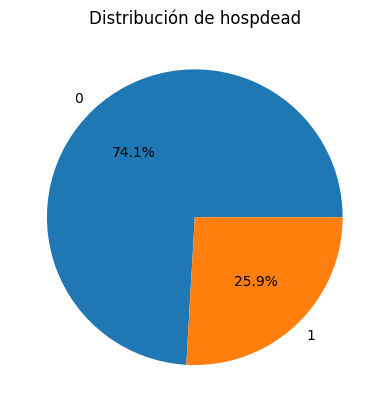

In [14]:
data['hospdead'].value_counts(normalize=True).plot(kind='pie', autopct='%1.1f%%', title="Distribución de hospdead", ylabel='')


value_counts = data['hospdead'].value_counts()
percentages = data['hospdead'].value_counts(normalize=True) * 100

results = pd.DataFrame({'Conteos': value_counts, 'Porcentaje (%)': percentages})
results

Si bien la distribución entre ambas etiquetas no es homogénea, y está un poco subrepresentada la etiqueta 1. No parece tratarse de un caso de desbalance de datos.

### VARIABLES NUMÉRICAS

Se realiza ahora un análisis separado para las variables numéricas.

In [15]:
numeric_columns=data.select_dtypes(include=['float64', 'int64']).columns
numeric_columns

Index(['age', 'num.co', 'scoma', 'avtisst', 'sps', 'aps', 'surv2m', 'surv6m',
       'hday', 'dnrday', 'meanbp', 'hrt', 'resp', 'temp', 'crea', 'sod',
       'adlsc'],
      dtype='object')

In [16]:
len(numeric_columns)

17

Se cuenta con 17 variables numéricas

#### ESTADÍSTICOS DESCRIPTIVOS DE LAS VARIABLES NUMÉRCIAS

In [17]:
df_num_describe=data[numeric_columns].describe().T
df_num_describe['variance']=data[numeric_columns].var()
cols = df_num_describe.columns.tolist()
std_index = cols.index('std') 

cols.insert(std_index + 1, cols.pop(cols.index('variance')))


df_num_describe = df_num_describe[cols]
df_num_describe

count        mean        std    variance         min         25%  \
age      9105.0   62.650823  15.593710  243.163788   18.041990   52.797000   
num.co   9105.0    1.868644   1.344409    1.807436    0.000000    1.000000   
scoma    9104.0   12.058546  24.636694  606.966692    0.000000    0.000000   
avtisst  9023.0   22.610928  13.233248  175.118858    1.000000   12.000000   
sps      9104.0   25.525872   9.899377   97.997667    0.199982   19.000000   
aps      9104.0   37.597979  19.903852  396.163309    0.000000   23.000000   
surv2m   9104.0    0.635870   0.248175    0.061591    0.000000    0.507690   
surv6m   9104.0    0.520096   0.253343    0.064183    0.000000    0.342957   
hday     9105.0    4.400000   9.126811   83.298682    1.000000    1.000000   
dnrday   9075.0   14.582590  19.944216  397.771749  -88.000000    4.000000   
meanbp   9104.0   84.546408  27.687692  766.608277    0.000000   63.000000   
hrt      9104.0   97.156711  31.559292  995.988902    0.000000   72.000000   
resp     9104.0   23.330294   9.573801   91.657674    0.000000   18.000000   
temp     9104.0   37.103341   1.251796    1.566992   31.699220   36.195310   
crea     9038.0    1.770961   1.686041    2.842735    0.099991    0.899902   
sod      9104.0  137.568541   6.029326   36.352766  110.000000  134.000000   
adlsc    9105.0    1.888272   2.003763    4.015065    0.000000    0.000000   

                50%         75%         max  
age       64.856990   73.998960  101.847960  
num.co     2.000000    3.000000    9.000000  
scoma      0.000000    9.000000  100.000000  
avtisst   19.500000   31.666656   83.000000  
sps       23.898438   30.199219   99.187500  
aps       34.000000   49.000000  143.000000  
surv2m     0.715942    0.825928    0.969971  
surv6m     0.574951    0.725952    0.947998  
hday       1.000000    3.000000  148.000000  
dnrday     9.000000   17.000000  285.000000  
meanbp    77.000000  107.000000  195.000000  
hrt      100.000000  120.000000  300.000000  
resp      24.000000   28.000000   90.000000  
temp      36.695310   38.195310   41.695310  
crea       1.199951    1.899902   21.500000  
sod      137.000000  141.000000  181.000000  
adlsc      1.000000    3.000000    7.073242

De aqui podemso concluir:

- Que la mayoría de pacientes son personas de la tercera edad (mayores de 60 años). Que si bien, hay un paciente joven mayor de edad de (18), la mayoría de la distribución se concentra en los adultos mayores. (esto podrá corroborarse aúnmás gráficamente con las distribuciones de esta variable, las cuales se verán más adelante).
- Que hay diferentes unidades de medida en las variables, vemos unidades de medida en años, en días, en grados, porcentajes, etc. Esto debería de atenderse en secciones posteriores (preprocesamiento), para lograra una homogeneización de las unidades de medida. Lo cual será importanet para ciertos algoritmos como la regresión logística, SVM, etc. Quizá hacer este preprocesamiento no sea tan relevante para modelos que son más robustos para tratar con diferentes unidades de medida, como lo son la mayoría d emodelo arboreos como el árbol de decisión, random forest, xgboost, etc.
- La varianza de añgunas de las variables es muy baja, lo cual puede indicarnos que quiza no hay amucha variabilidad en esta. Cuando tenemso valores muy cercanos a cero, se podría omitir esta variable, pues indicaría qu eno varia  y se comportaría como una constante, lo cual no añadiría inforamción al modelo.

#### HISTOGRAMAS

Para calcular el número de bins que se han de usar en el histograma, se utiliza la regla de Sturges, la cual se resume en la siguiente fórmula:


$k=1+log2(n)$

In [18]:
n=len(data)
k=int(1+np.log2(n))
k

14

De acuerdo con la regla de Sturges, el número óptimo de bins es 14.

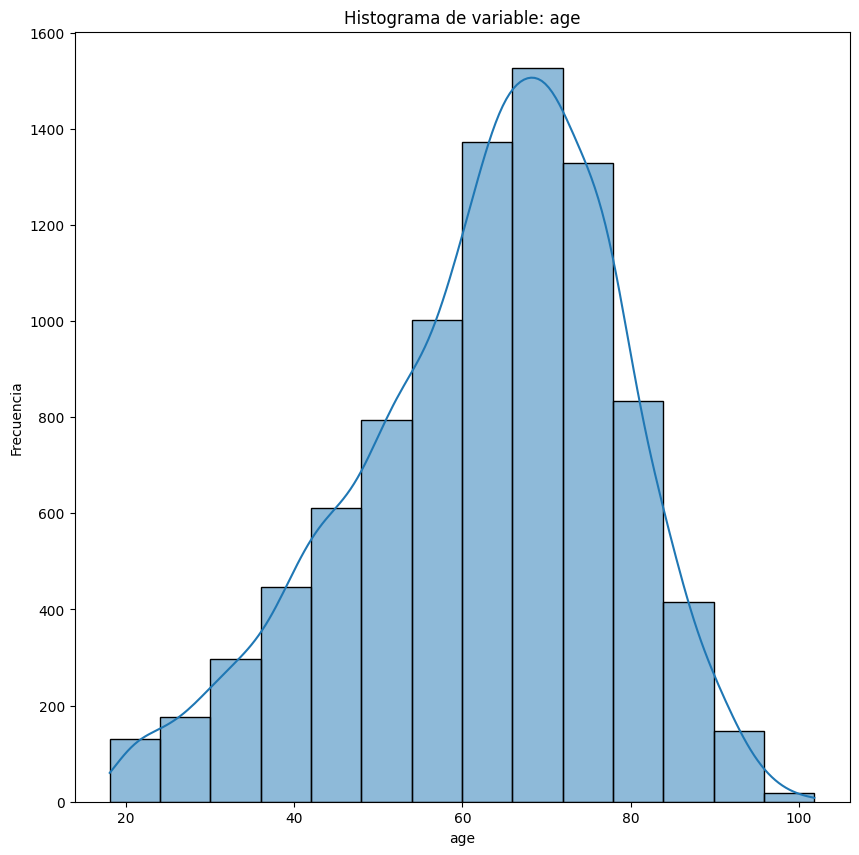

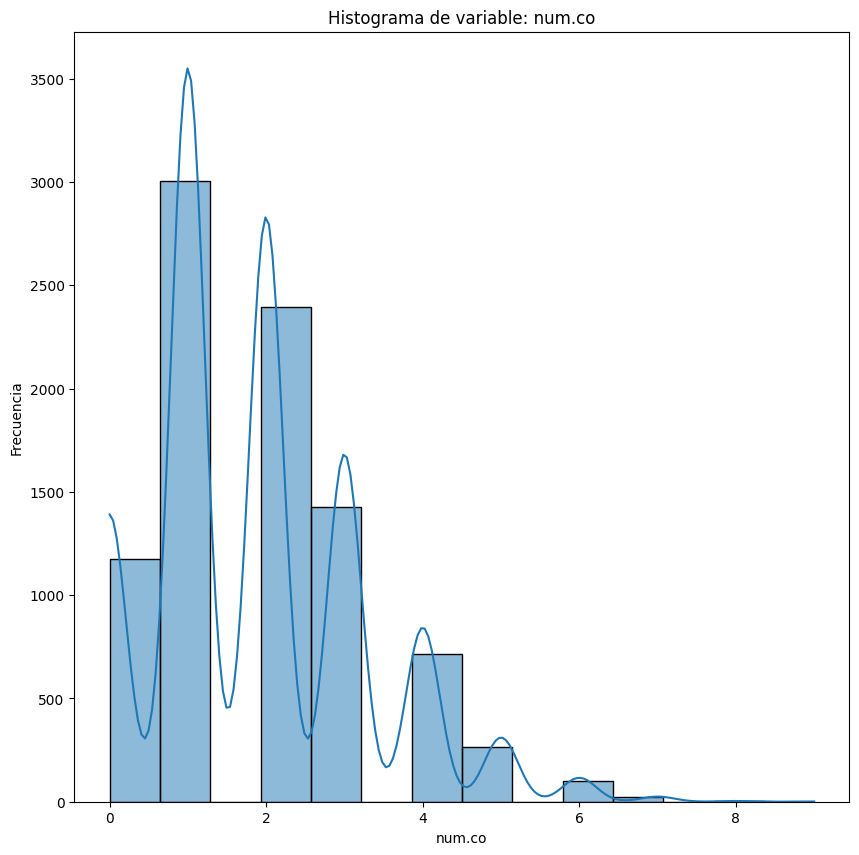

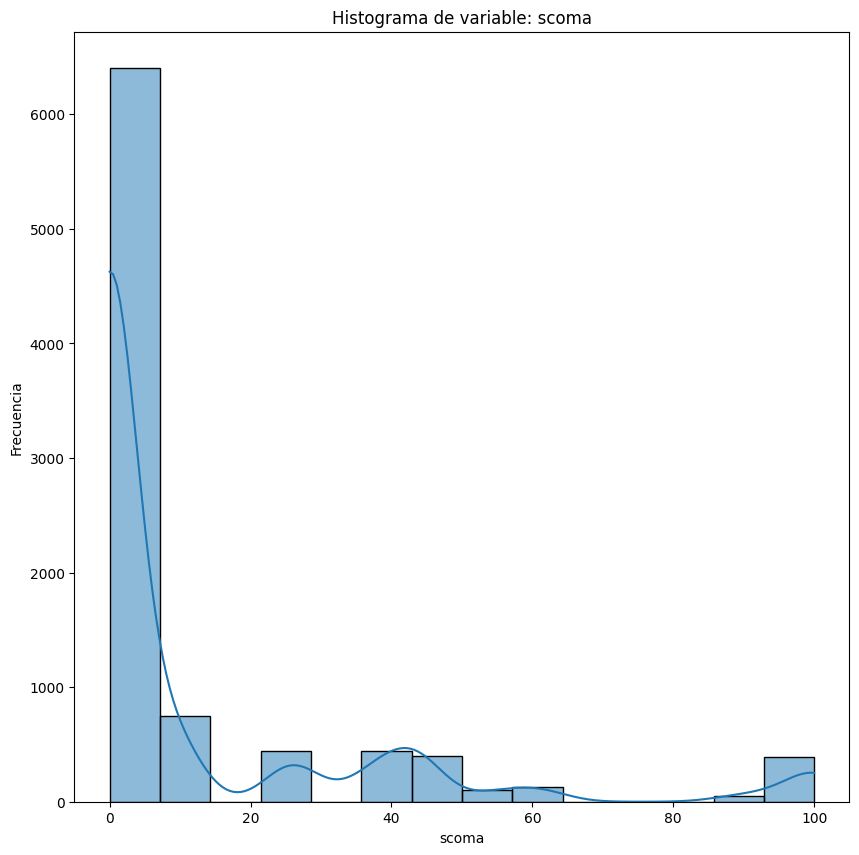

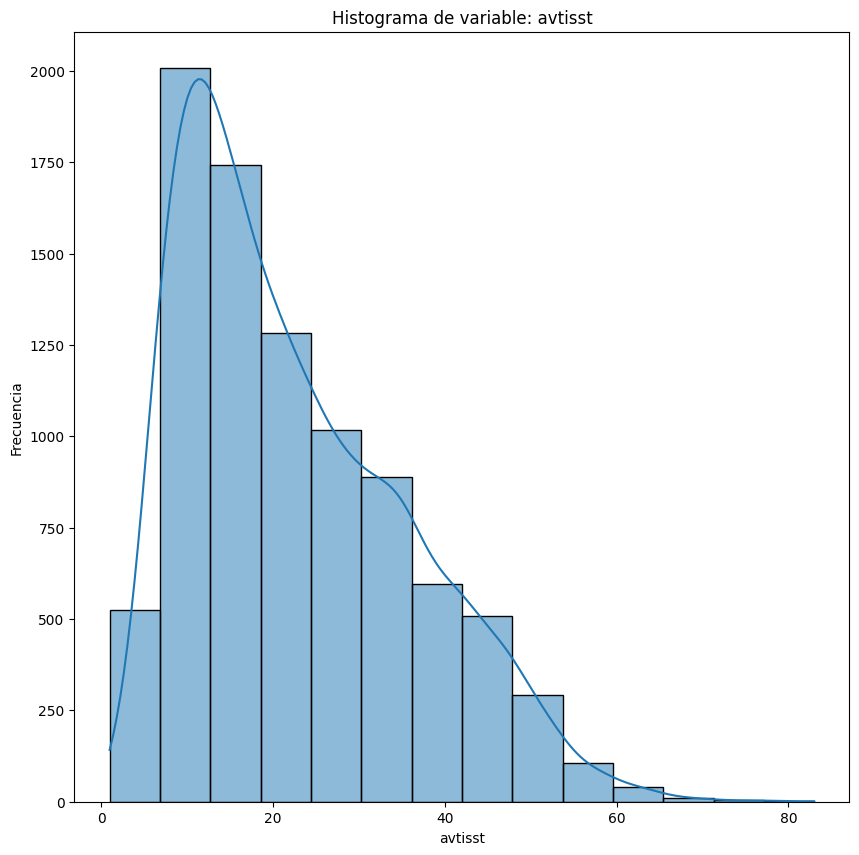

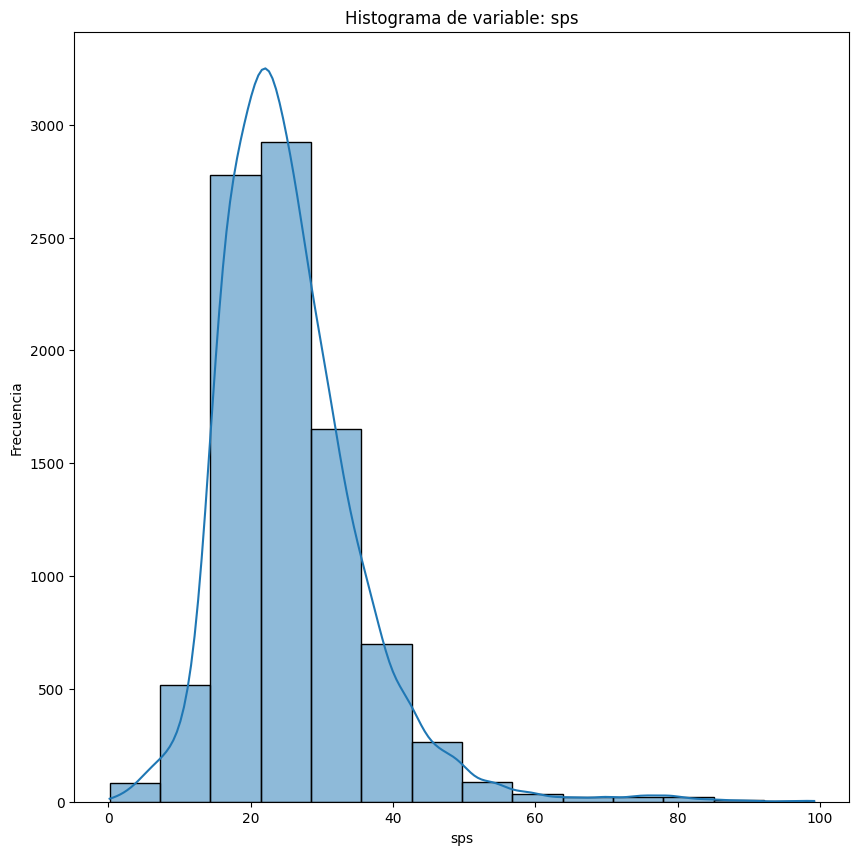

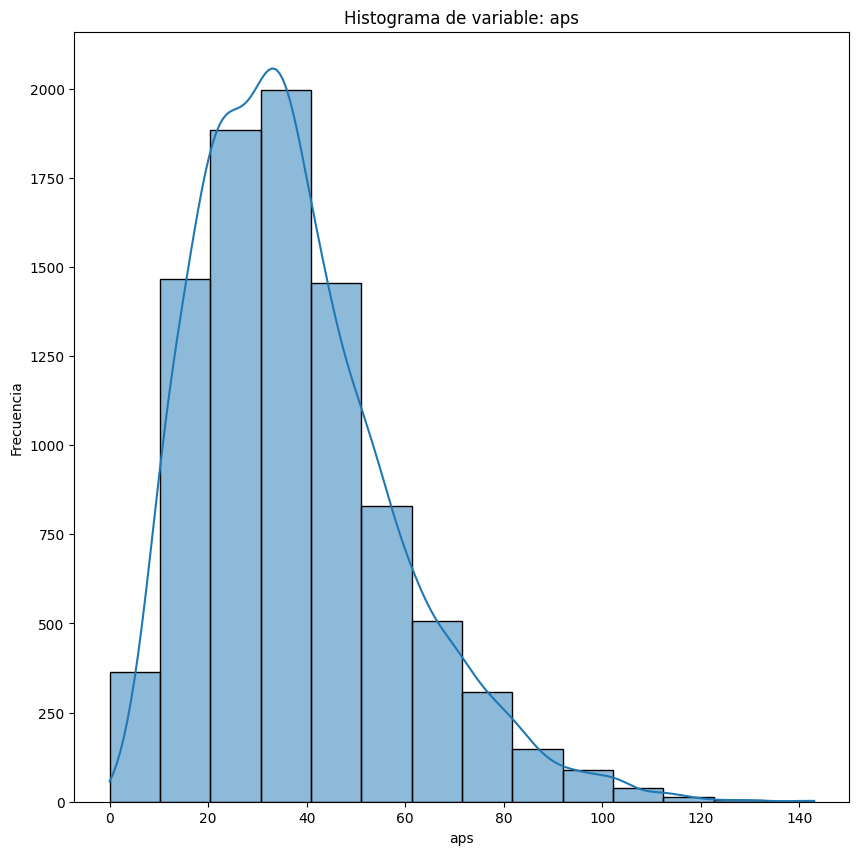

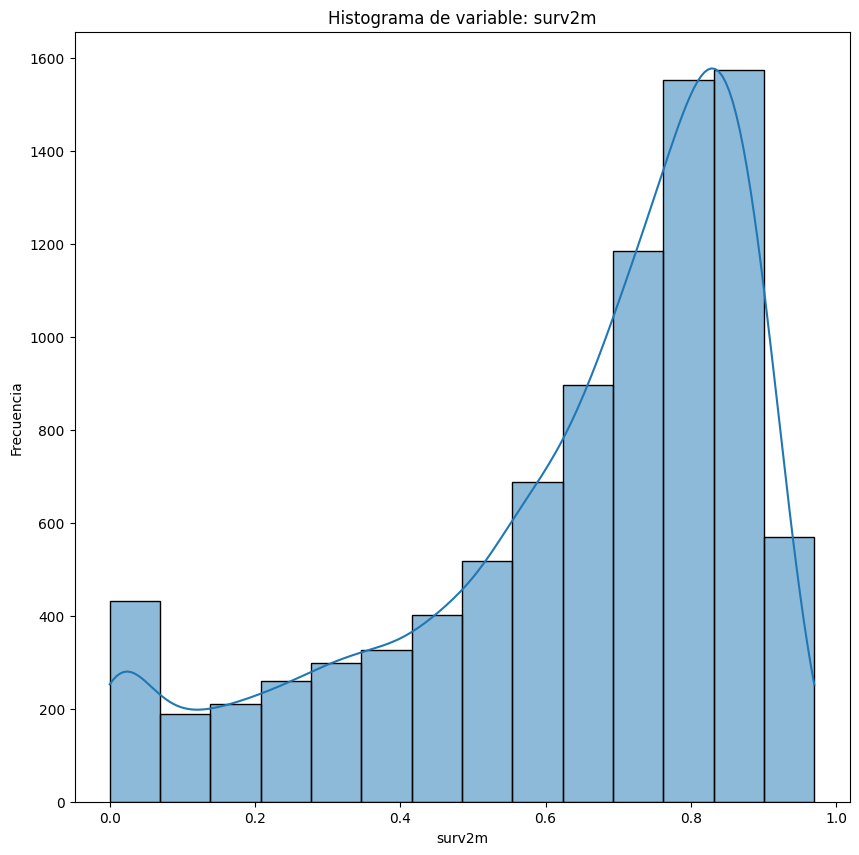

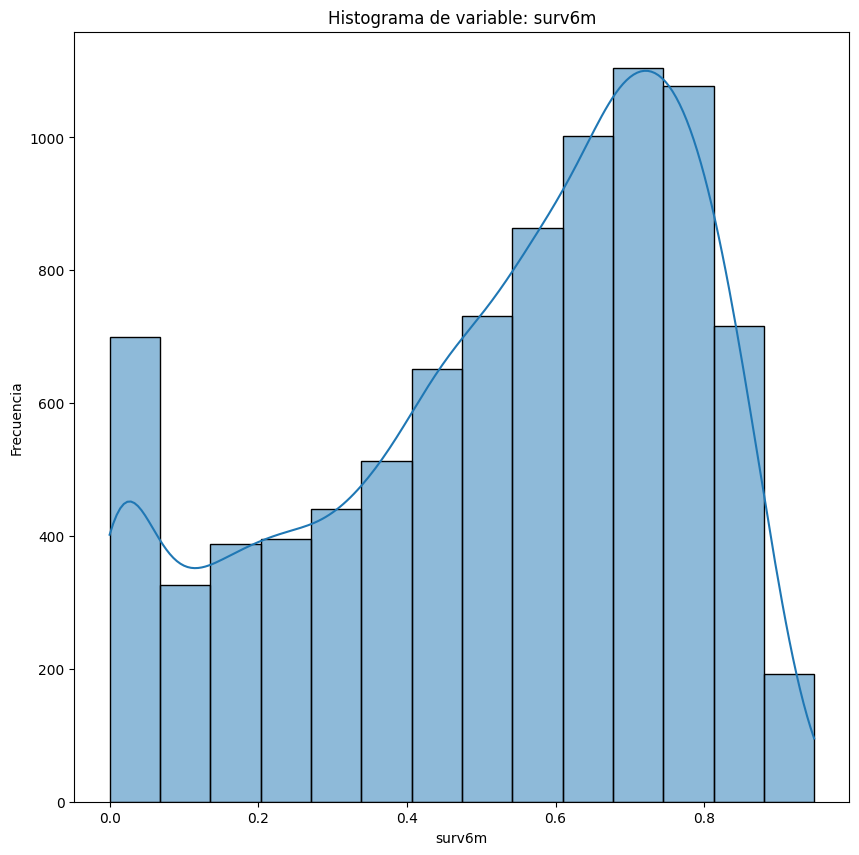

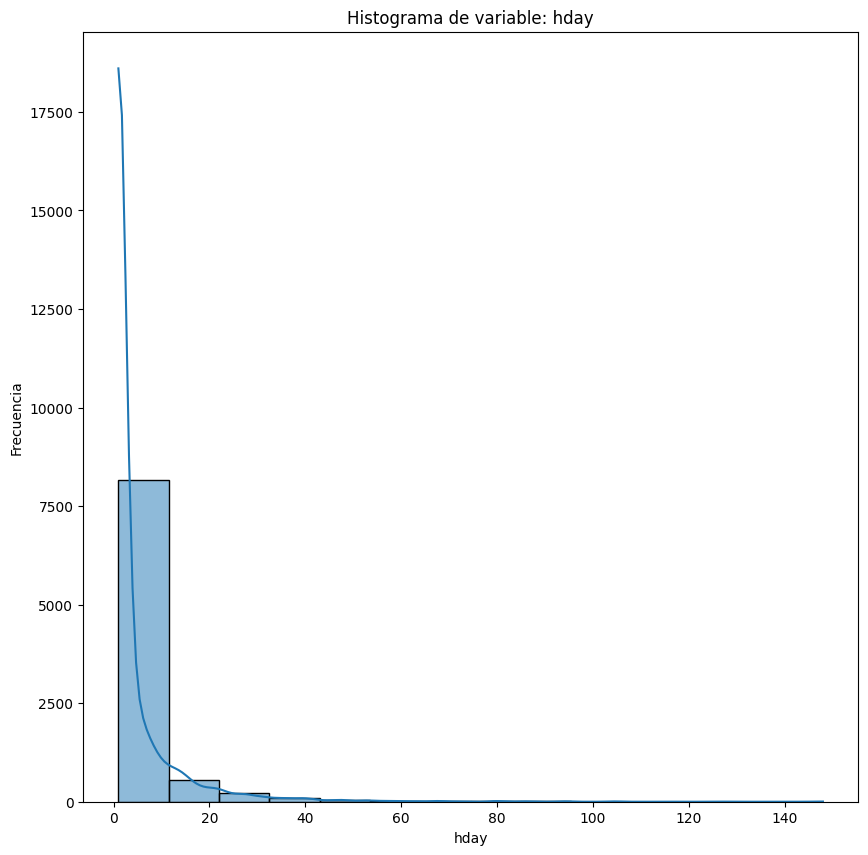

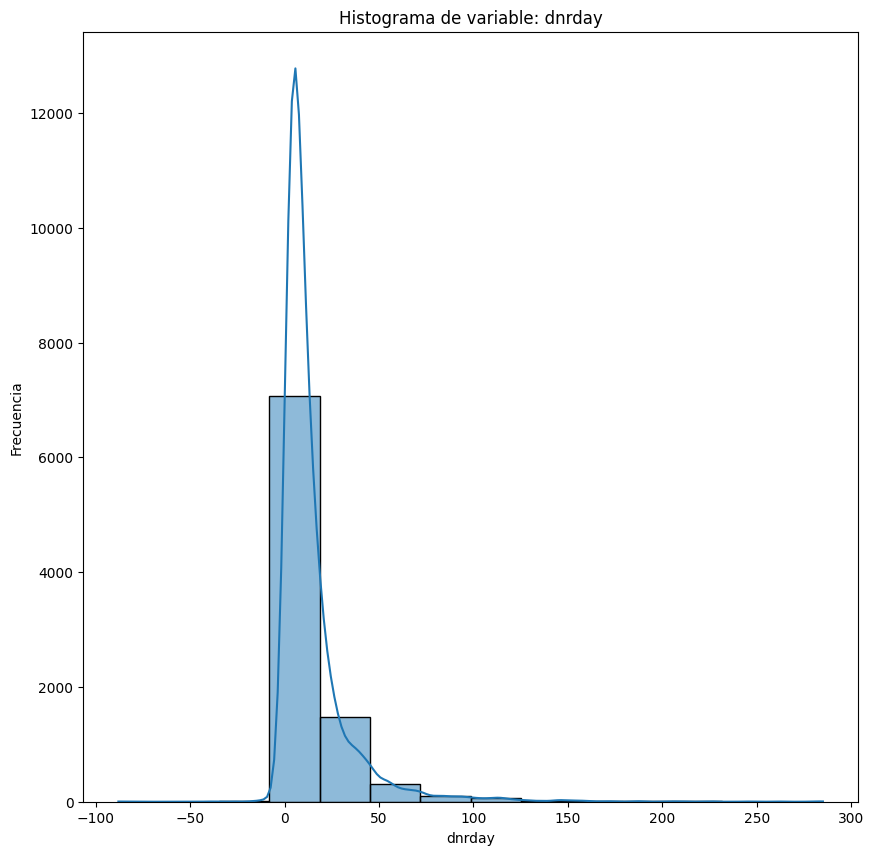

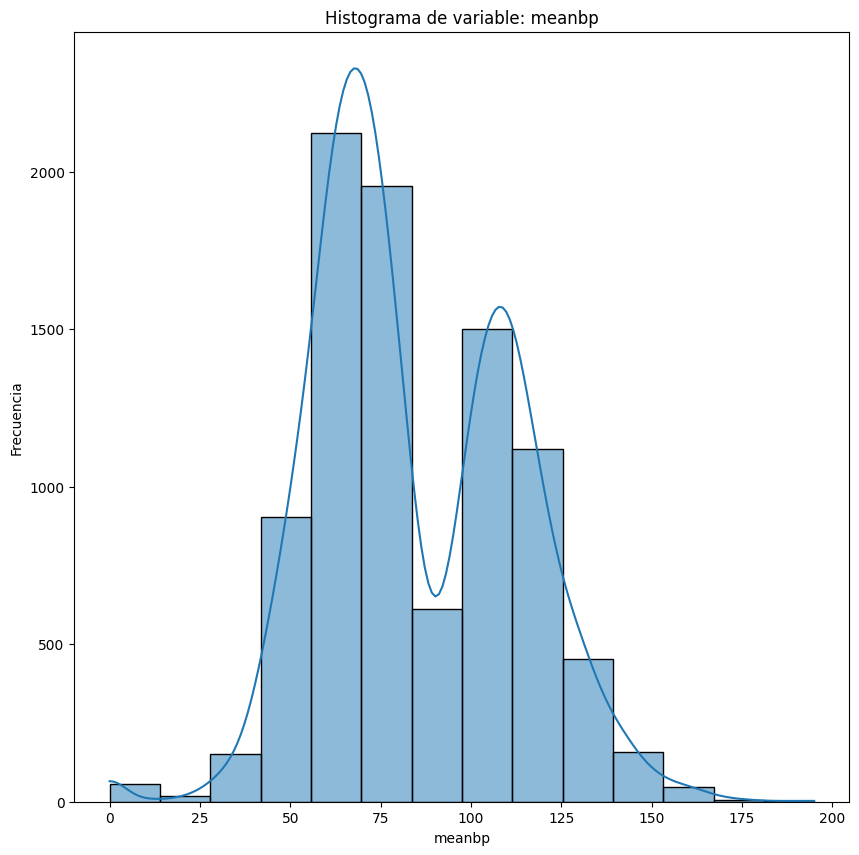

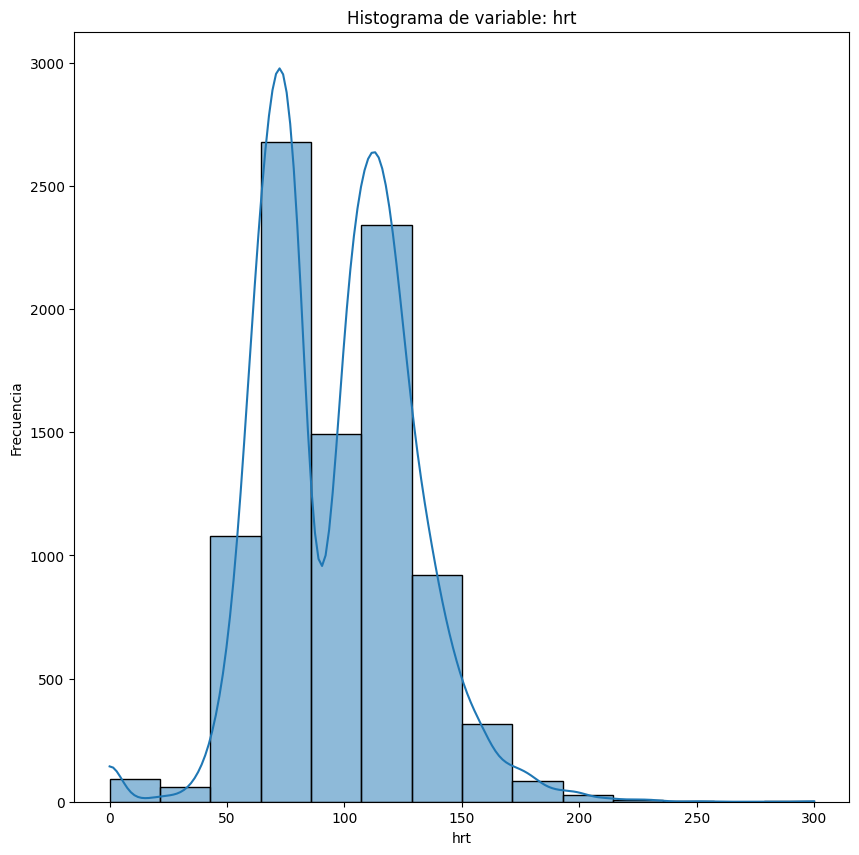

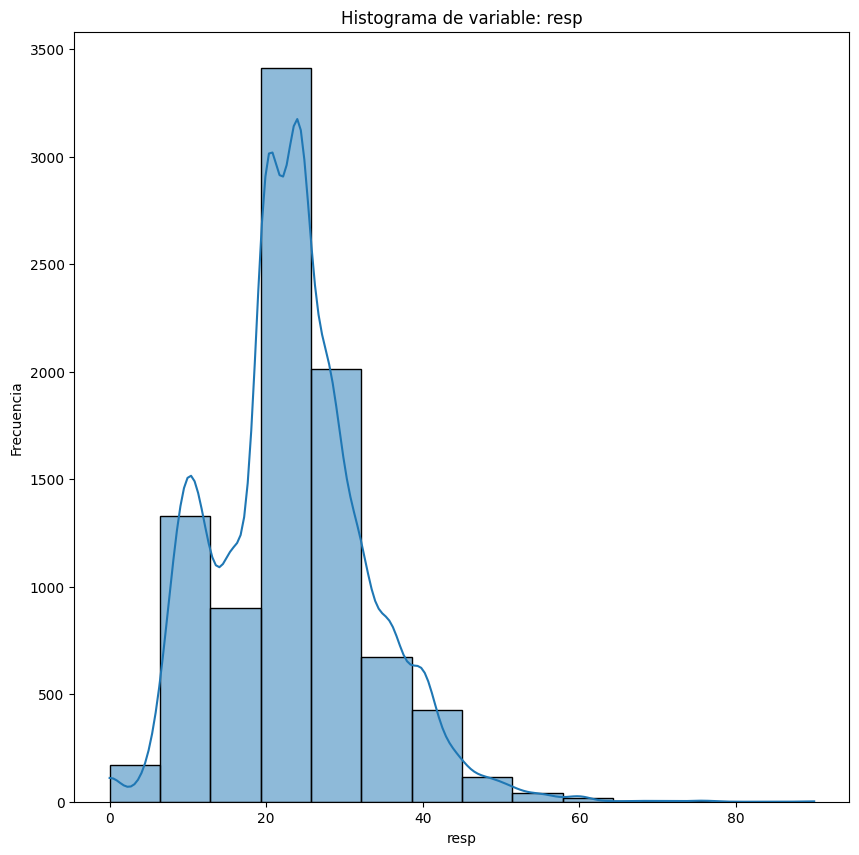

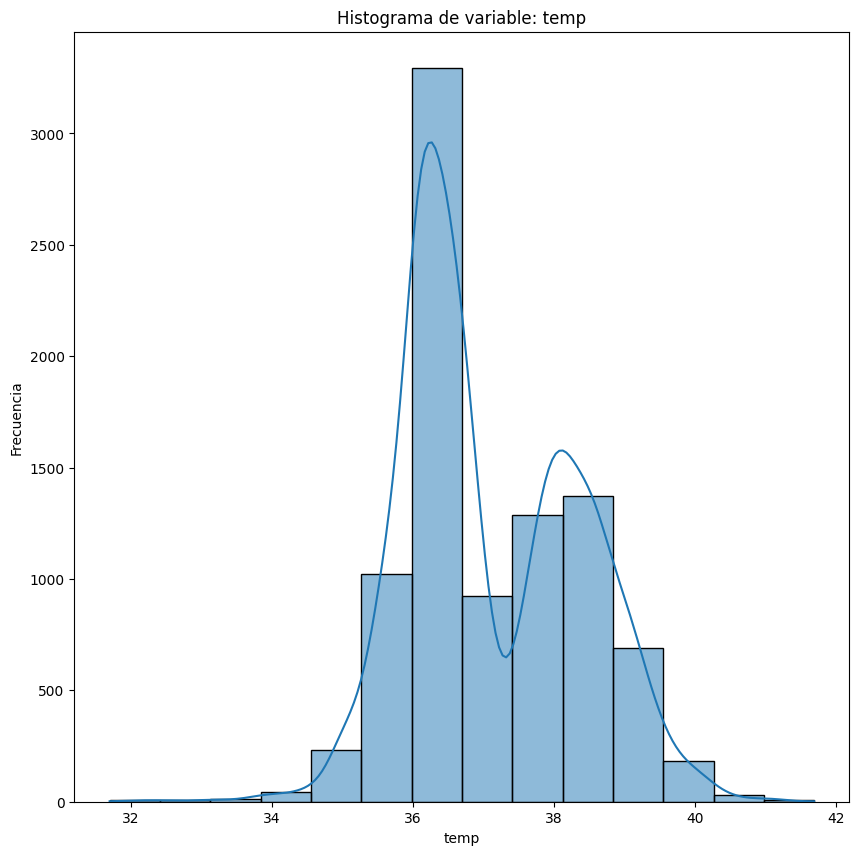

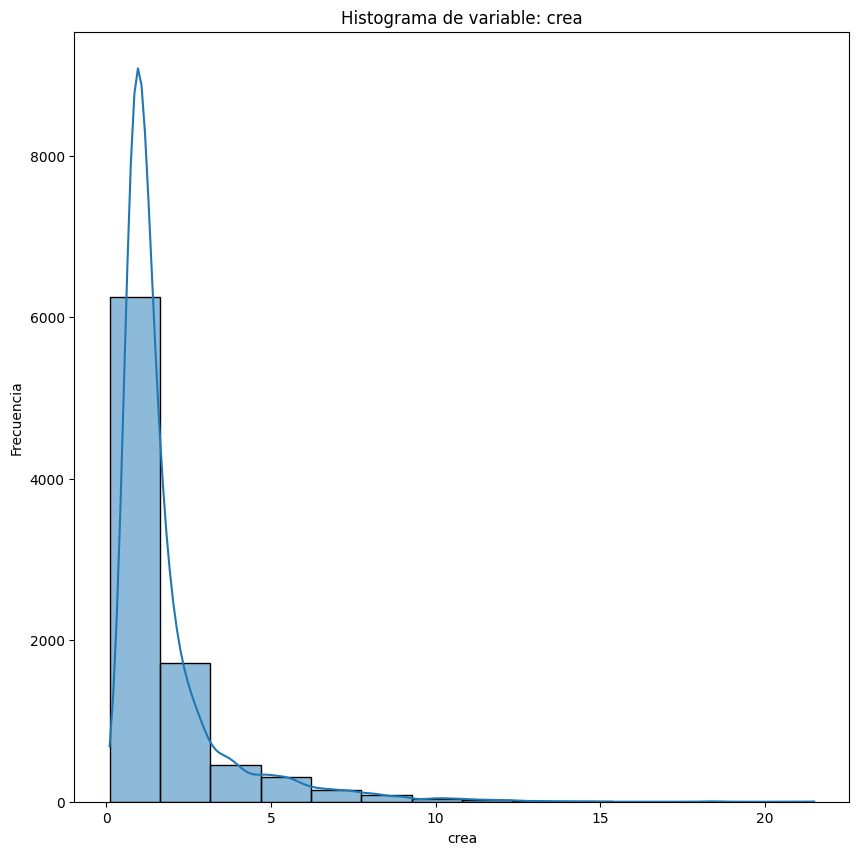

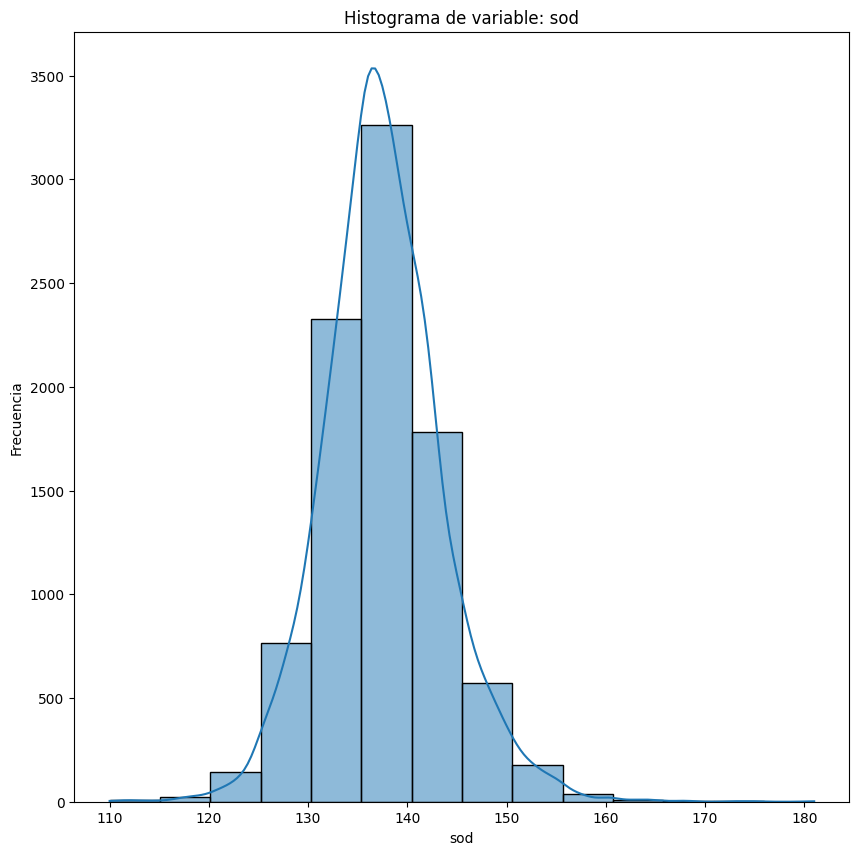

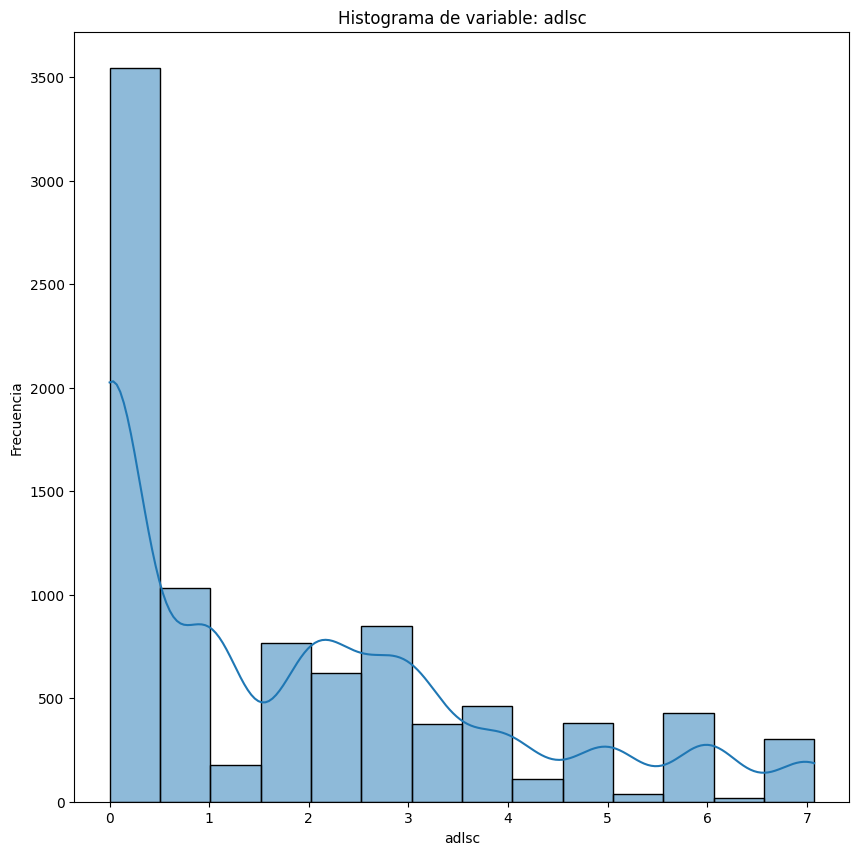

In [19]:
for column in numeric_columns:
    plt.figure(figsize=(10,10))
    sns.histplot(data[column], kde=True, bins=k)
    plt.title(f'Histograma de variable: {column}')
    plt.xlabel(column)
    plt.ylabel('Frecuencia')
    plt.show()

Luego de revisar gráficamente mediante los histogramas y superponiendo la curva de densidad estimada (KDE), vemos que no hay una variable numérica que se pueda propiamente decir que se comporta con una distribución normal (Esto se puede constantar con un test de Shapiro o de normalidad). Vemos también que por ejemplo para ciertas variables, la distribución tiene cierta tendencia hacia valores altos o valores pequeños, según sea el caso. Así por ejemplo:
- La variable edad, tiende hacia valores más altos indicándonos que la mayoría de los pacientes son adultos mayores.
- La variable avttist que mide de alguna manera los costos de la UCI se concentra en valores bajos.


Esta primera exploración gráfica nos permite por ejemplo corroborar la suposición, que la mayoría de los pacientes son adultos mayores.
Frente al reto de las variables, no dejan ver patrones claros, por ejemplo, frente a la temperatura en grados Celsius, esta en el rango que se espera de un adulto cercano a los 37 grados.
En cuanto al ritmo cardiaco (los picos de la densidad se encuentra cerca de 100, lo cual para ser en reposo, puede ser alto, no obstante, so se tiene información de si esa medición es en reposo o no). Hay casos no obstante alarmantes como los de 200 pulsaciones (dado que esto valores son muy elevados incluso cuando una persona esta haciendo ejercicio.).

Se considera que este ejercicio puede complementarse aún más contrastando estas densidades y distribuciones contra la variable objetivo. Pero  antes de hacerlo se aplicará el test de normalidad de Kolmogorov (Inicialmente se aplico Shapiro, pero obtenía un warning por el tamaño de muestra grande, dado que este test no se desempeña bien en muestras grandes después de cierto valor de observaciones).

#### TEST DE NORMALIDAD KOLMOGOROV

En este test de Kolmogorov se realizará para cada variable numérica pero discriminando contr ala variable objetivo, esto nos dirá entonces si por ejemplo la distribución de X variable frenet a la etiqueta Y de la variable objetivo sigue una distribución normal o no. Esto nos empezará a dar luces sobre la relación que guarda la variable numérica frente a la variable objetivo.

Se determina una prueba de hipótesis, teniendo como hipótesis nula H0: Que los datos siguen una distribución normal y H1: Que los datos no siguen una distribución normal. Se rechazará la hipótesis nula si se obtiene un p-value menor a 0.05% (normalmente se usa este umbral)

In [20]:
for column in numeric_columns:
    group1 = data[data['hospdead'] == 1][column]
    group0 = data[data['hospdead'] == 0][column]

    stat1, p_value1 = kstest(group1.dropna(), 'norm')
    stat0, p_value0 = kstest(group0.dropna(), 'norm')

    print(f"Variable: {column}")
    print(f"p_value1: {p_value1}, p_value0: {p_value0}")
    print(f"Grupo 1 - p-value: {p_value1} (Normalidad)" if p_value1 > 0.05 else "No Normal")
    print(f"Grupo 0 - p-value: {p_value0} (Normalidad)" if p_value0 > 0.05 else "No Normal")


Variable: age
p_value1: 0.0, p_value0: 0.0
No Normal
No Normal
Variable: num.co
p_value1: 0.0, p_value0: 0.0
No Normal
No Normal
Variable: scoma
p_value1: 0.0, p_value0: 0.0
No Normal
No Normal
Variable: avtisst
p_value1: 0.0, p_value0: 0.0
No Normal
No Normal
Variable: sps
p_value1: 0.0, p_value0: 0.0
No Normal
No Normal
Variable: aps
p_value1: 0.0, p_value0: 0.0
No Normal
No Normal
Variable: surv2m
p_value1: 0.0, p_value0: 0.0
No Normal
No Normal
Variable: surv6m
p_value1: 0.0, p_value0: 0.0
No Normal
No Normal
Variable: hday
p_value1: 0.0, p_value0: 0.0
No Normal
No Normal
Variable: dnrday
p_value1: 0.0, p_value0: 0.0
No Normal
No Normal
Variable: meanbp
p_value1: 0.0, p_value0: 0.0
No Normal
No Normal
Variable: hrt
p_value1: 0.0, p_value0: 0.0
No Normal
No Normal
Variable: resp
p_value1: 0.0, p_value0: 0.0
No Normal
No Normal
Variable: temp
p_value1: 0.0, p_value0: 0.0
No Normal
No Normal
Variable: crea
p_value1: 0.0, p_value0: 0.0
No Normal
No Normal
Variable: sod
p_value1: 0.0, p

Como se puede observar, en todas las variable numéricas frente a los valores de las etiquetas de la variable objetivo, se obtuvo un p-value de 0, rechazando la hipótesis nula de normalidad en las distribuciones. Esto nos lleva a concluir que las variables numéricas no se distribuyen normalmente frente a la variable objetivo. Esto se verá gráficamente a continuación al ver las densidades de estas variables frente a la objetivo.

#### GRÁFICOS DE DENSIDAD VARIABLES NUMÉRICAS VS VARIABLE OBJETIVO

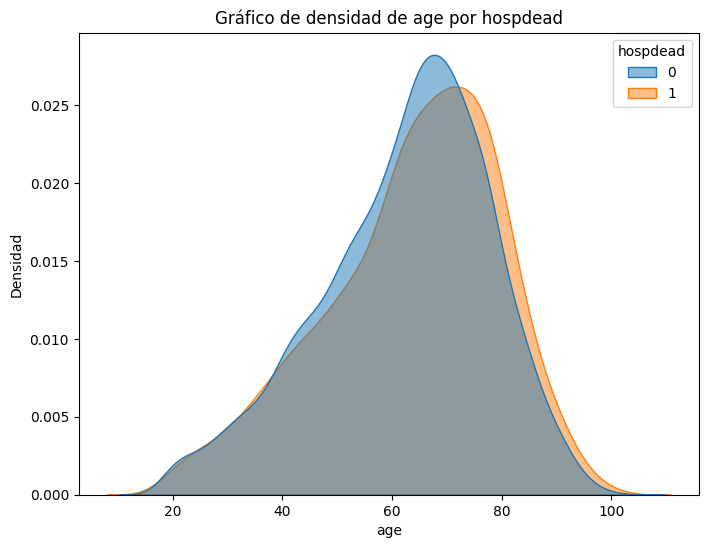

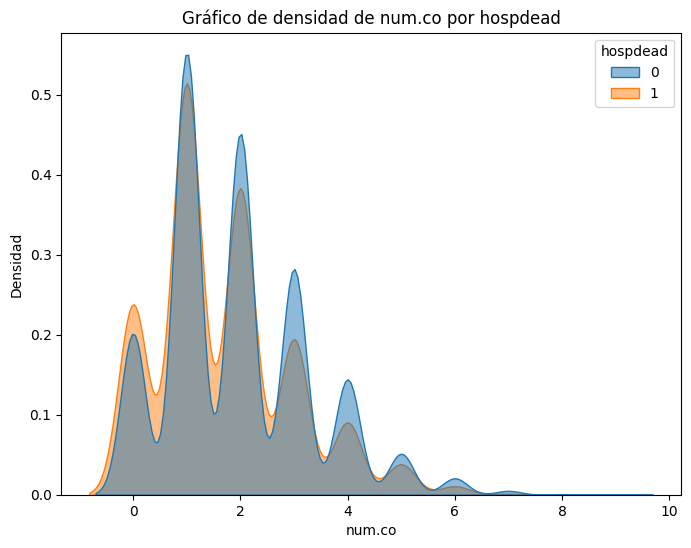

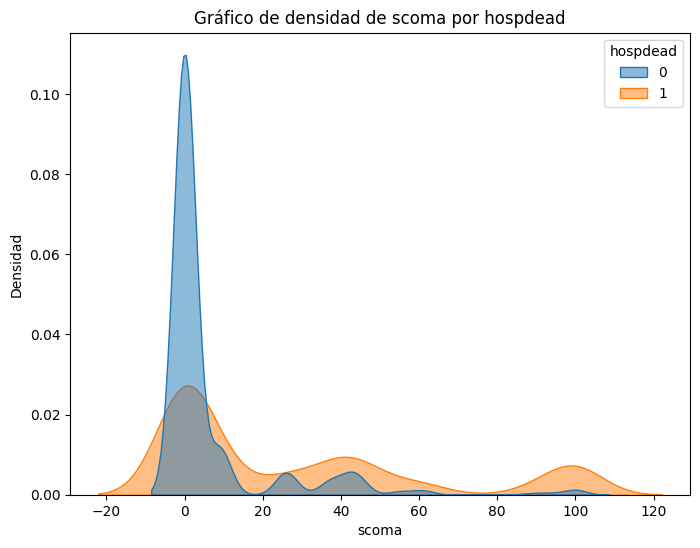

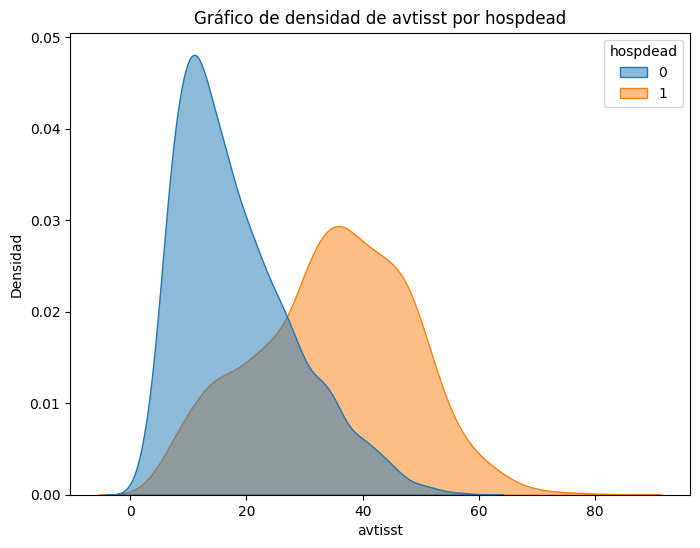

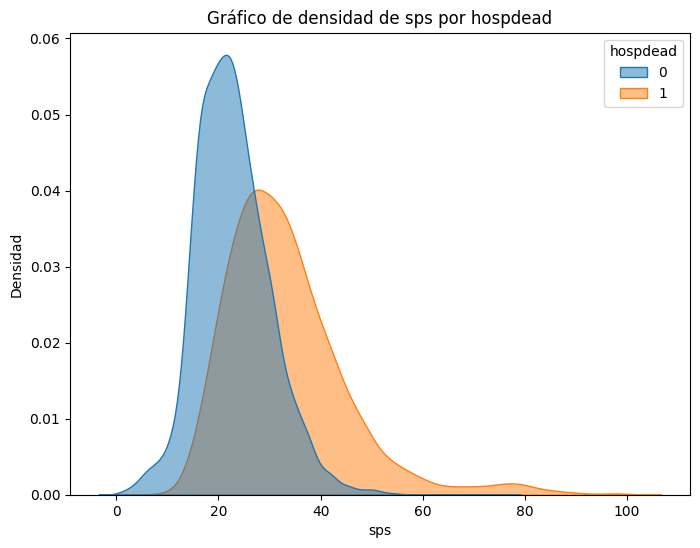

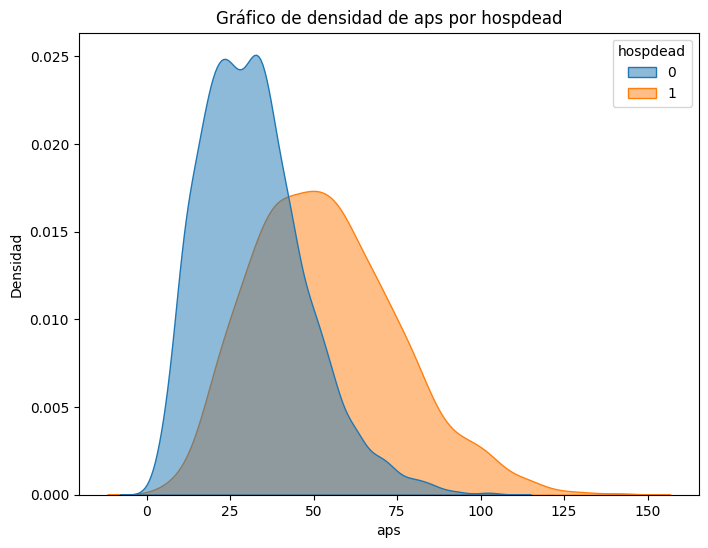

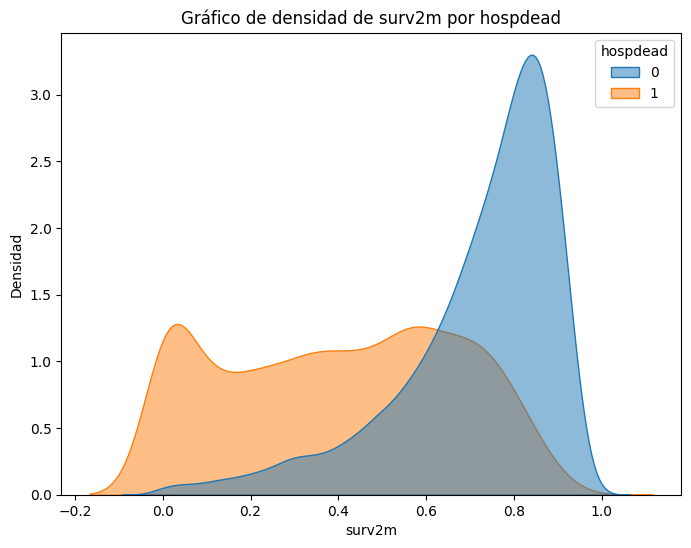

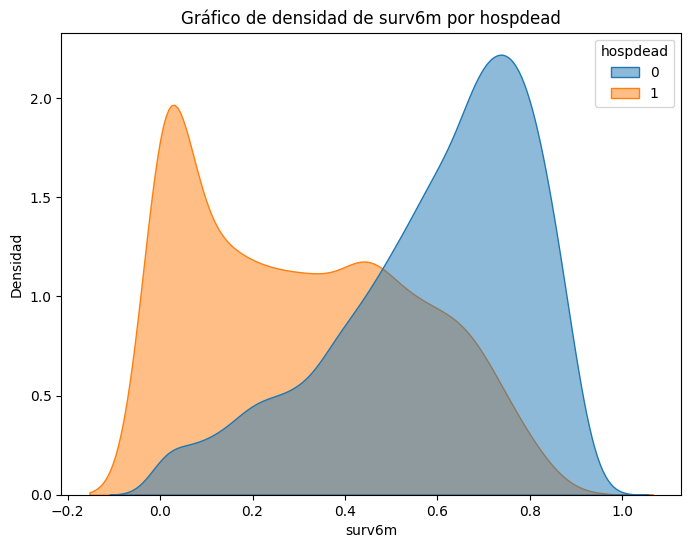

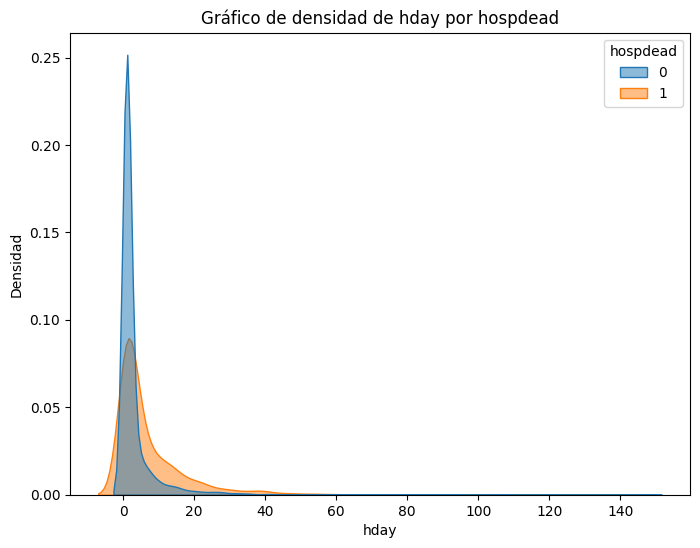

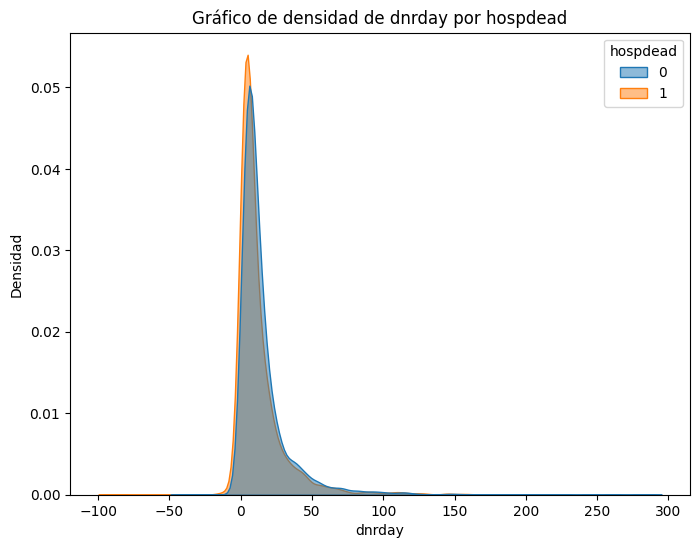

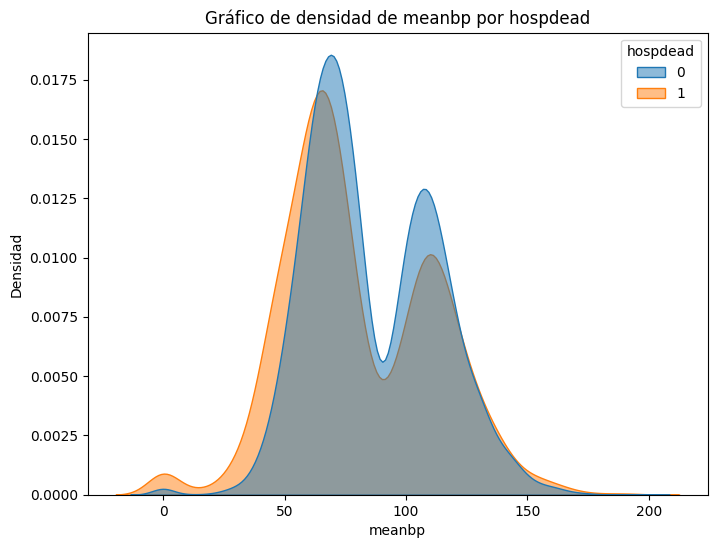

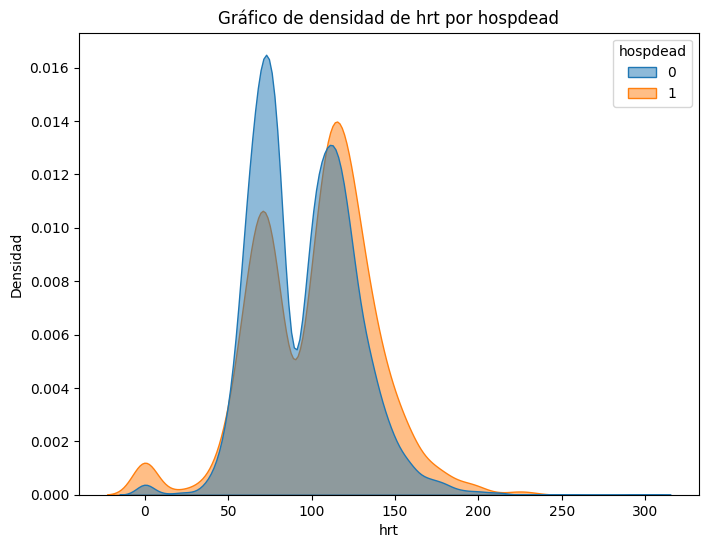

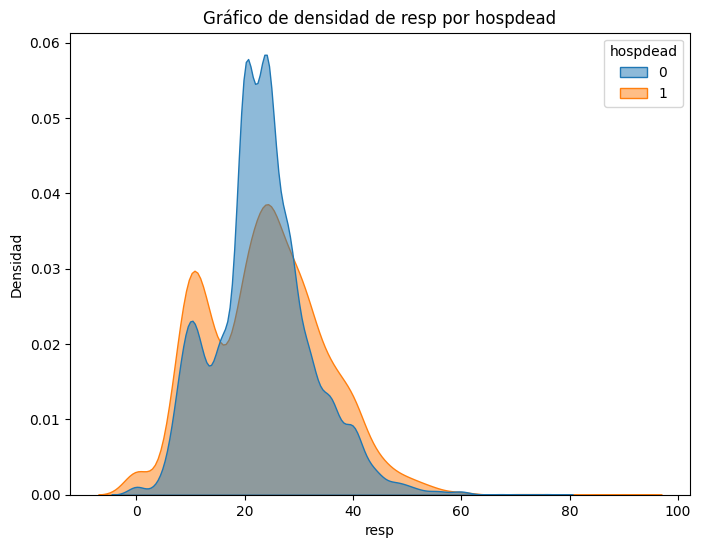

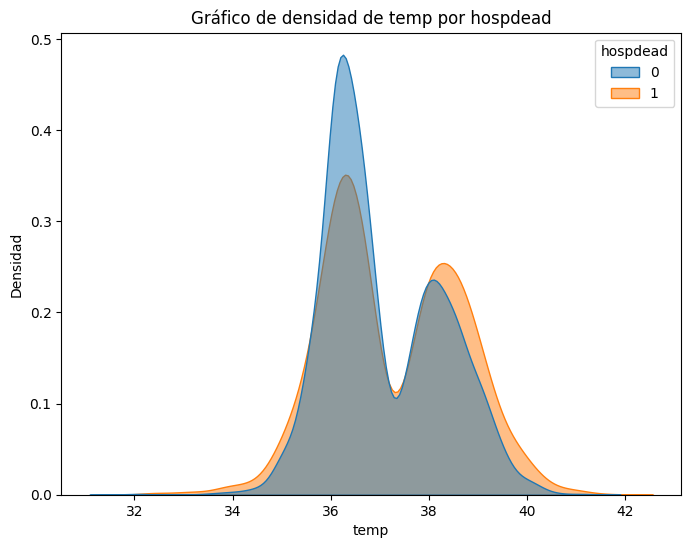

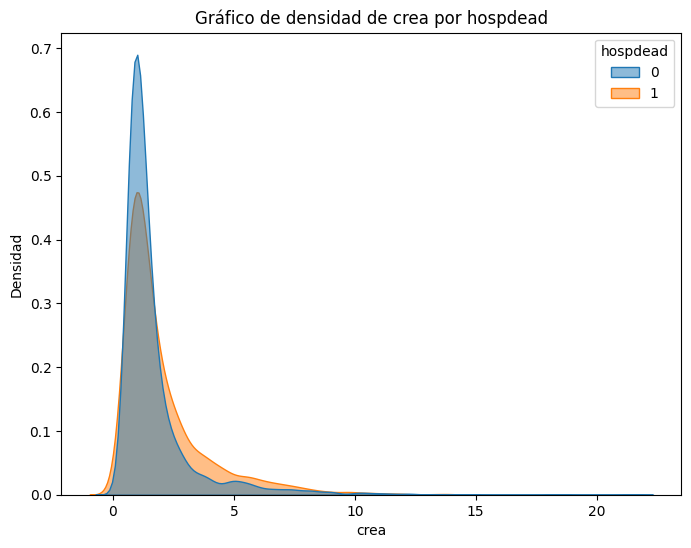

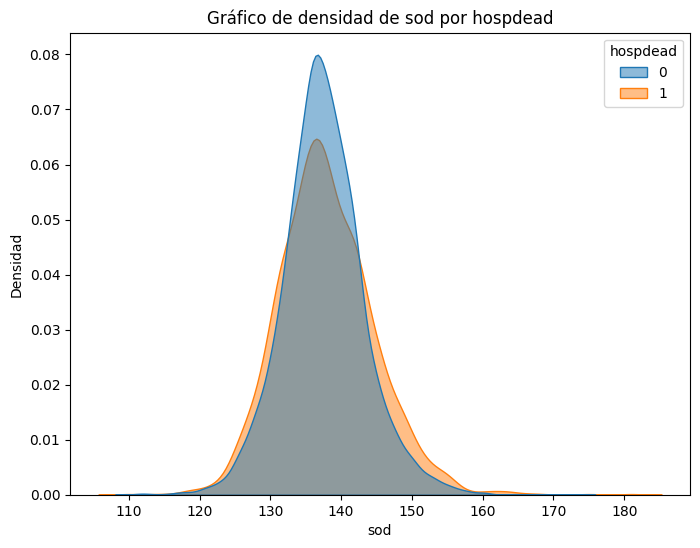

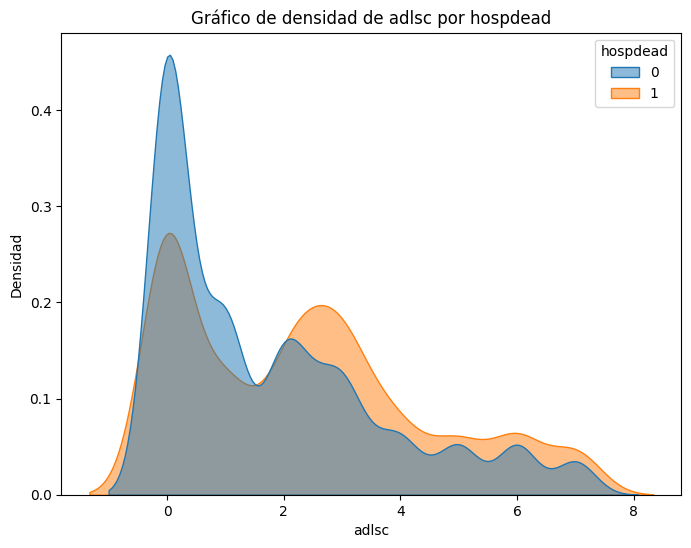

In [21]:
for column in numeric_columns:
    plt.figure(figsize=(8, 6))
    sns.kdeplot(data=data, x=column, hue='hospdead', common_norm=False, fill=True, alpha=0.5)
    
    plt.title(f'Gráfico de densidad de {column} por hospdead')
    plt.xlabel(column)
    plt.ylabel('Densidad')
    plt.show()

Como puede verse, efectivamente ninguna de las variables al menos visualmente sigue una distribución normal frente a la variable objetivo. En muchos de los casos la distribución frente a las etiquetas es similar, por ejemplo en edad o dnrday.
No obstante, hay otros casos en donde si se puede apreciar visualmente una cierta diferencia en a densidad frente a la etiqueta, empezando a dejarnos ver que posiblemente si haya una cierta correlación entre esa variable explicativa y la variable objetivo. Tal es el caso de:

- scoma: El puntaje de coma, la distribución de esta variable es diferente entre los pacientes que mueren (el cual tiende a ser mayor), que en las personas que no mueren (cuya distribución tiende a concentrarse en cero).
- avtisst: La cual se relaciona con el costo de la UCI, como es de esperar, en las personas que sobreviven, quizá el costo sea menor, dado que posiblemente estuvieron poco tiempo en UCI o ni siquiera entraron en esta. Mientras que en la población de pacientes que murieron se espera que la distribución se concentre en valores mayores, lo que indicaría que entraron a UCI, y tal vez duraron varios días en UCI (debido a su condición crítica).
- Las variables surv2m y surv6m: Que mide la estimación de sobrevivencia del paciente en 2 y 6 meses respectivamente, se espera que la población que no murió tenga una distribución en los valores más altos de este indicador, diciendonos que tienen más chances de sobrevivir (esto es también lo que se puede ver gráficamente en las densidades).

#### BOX-PLOT

A continuación se realiza un análisis gráfico de Boxplot e cual nos dejará ver también la distribución de los datos, pero además nos dejará ver como se concentra esta de acuerdo a los quiartiles. Asimismo, nos permitirá ver la presencia de valores atípicos.

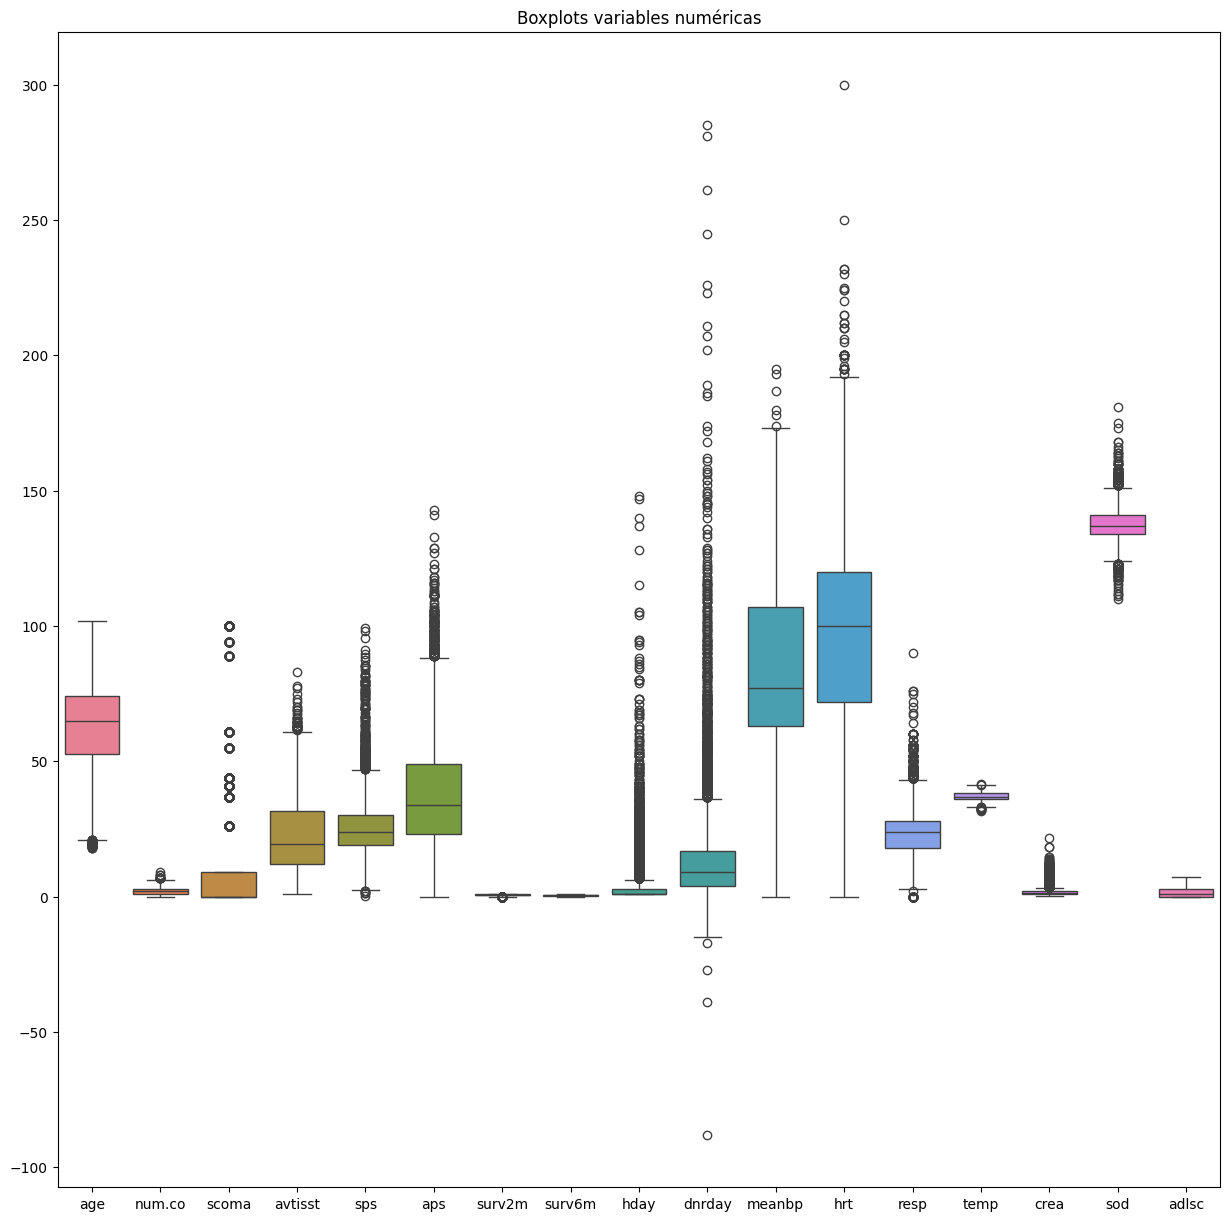

In [22]:
plt.figure(figsize=(15,15))
sns.boxplot(data=data[numeric_columns])
plt.title('Boxplots variables numéricas')
plt.show()

La primera observación es que los boxplots se ven distribuidos a lo largo de los valores del eje Y de acuerdo a sus unidades de medida (esto porque aún no se han estandarizado los valores de estos). Por tal motivo, vemos como hay distribuciones que van a los números negativos y otros que tienen escalas muy grandes, y otros que se concentran en escalas entre [0-1].

Vemos también que en varias de las variables numéricas hay valores outliers, los cuales son tan extremos que podrían afectar en algunos algoritmos de clasificación su desempeño (como es el caso de la regresión logística, SVM, entre otroos. Mientras que para otros algoritmos basados en árboles, los cuales son más robustos a los valores atípicos, esto no les afectaría tanto, como en el caso de (árboles de decisión, random forest, xgboost, etc)).

Se considera que al igual que como se hizo el gráfico de las densidades de estas variables contra la variable objetivo, que esto mismo se puede hacer con los boxplot y puede añadir más valor al análisis, pues nos dejará ver las concentraciones en los cuartiles y valores atípico según la etiqueta de la variable objetivo.

#### BOXPLOT VARIABLES NUMÉRICAS VS VARIABLE OBJETIVO

Se grafica un boxplot para cada variable numérica, pero teniendo en cuenta la variable objetivo. Esto nos permite ver la distribución de la variable numérica frente a cad aetiqueta de la variable objetivo. Este ejericico visual se parece en parte al gráfico de densidad ya presentado de la variable numérica contra la variable objetivo. No obstante, en el box plot podemso ver un poco mejor la distribución de lso datos en los cuartiles y ver la presencia de outliers.

<Figure size 1000x1000 with 0 Axes>

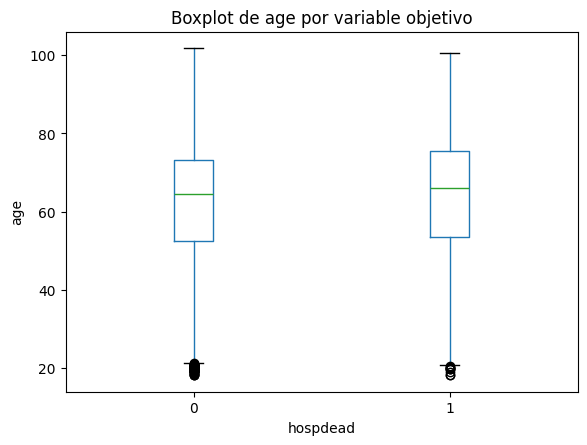

<Figure size 1000x1000 with 0 Axes>

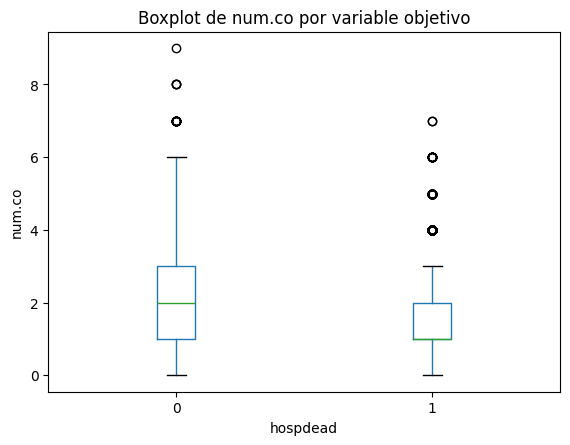

<Figure size 1000x1000 with 0 Axes>

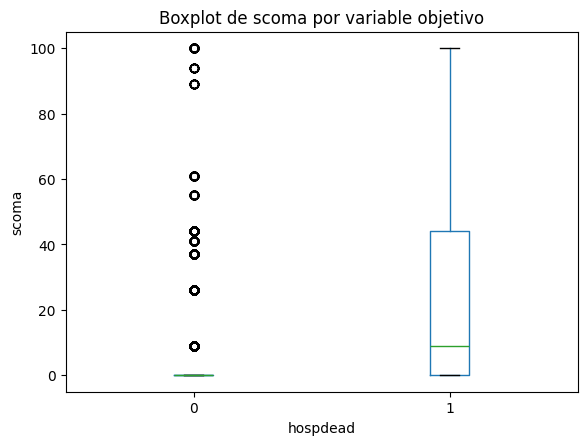

<Figure size 1000x1000 with 0 Axes>

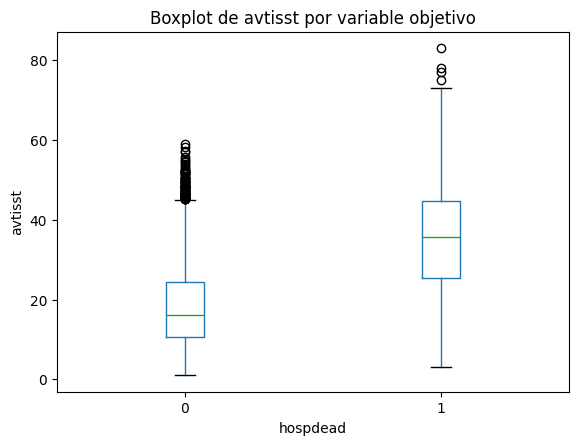

<Figure size 1000x1000 with 0 Axes>

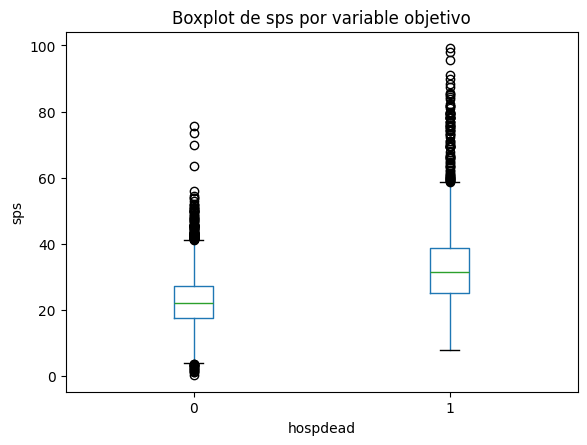

<Figure size 1000x1000 with 0 Axes>

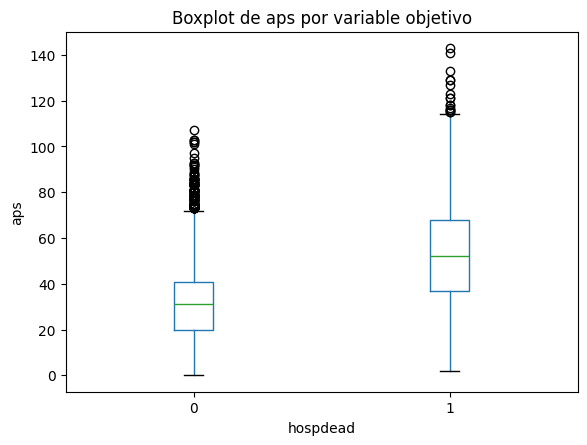

<Figure size 1000x1000 with 0 Axes>

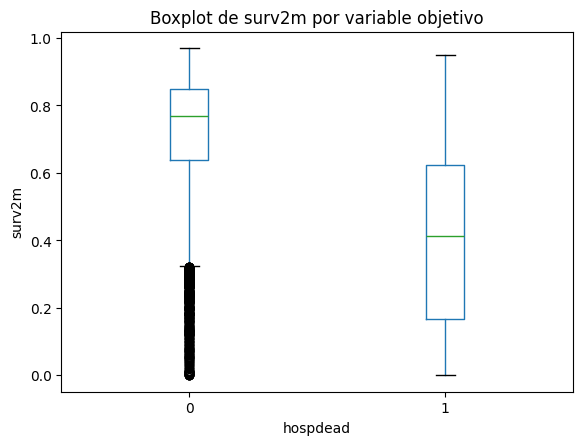

<Figure size 1000x1000 with 0 Axes>

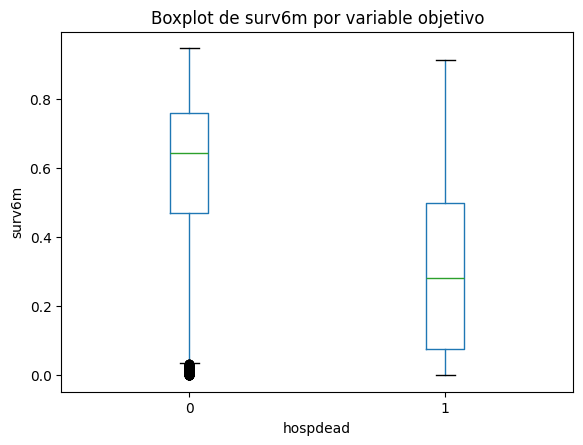

<Figure size 1000x1000 with 0 Axes>

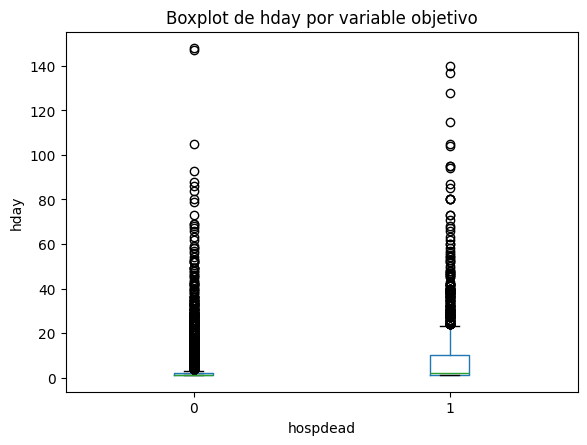

<Figure size 1000x1000 with 0 Axes>

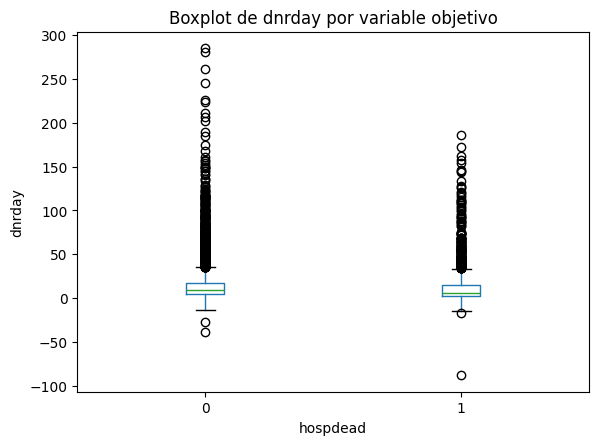

<Figure size 1000x1000 with 0 Axes>

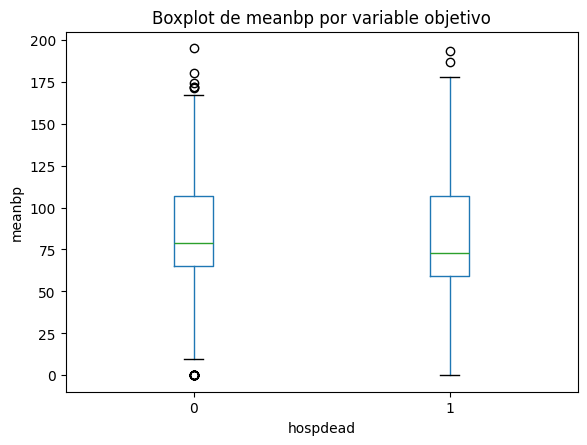

<Figure size 1000x1000 with 0 Axes>

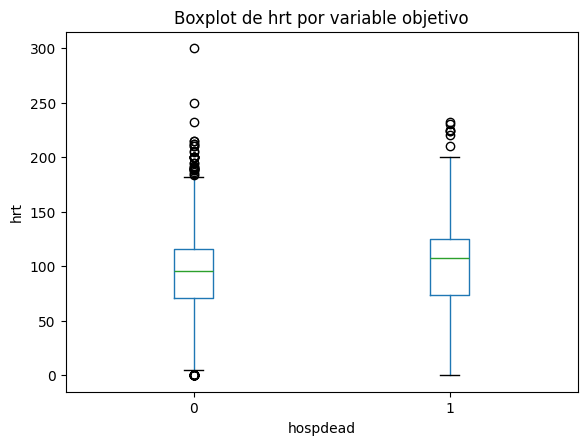

<Figure size 1000x1000 with 0 Axes>

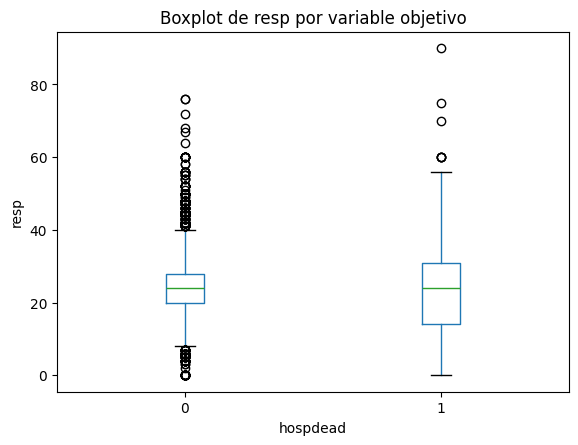

<Figure size 1000x1000 with 0 Axes>

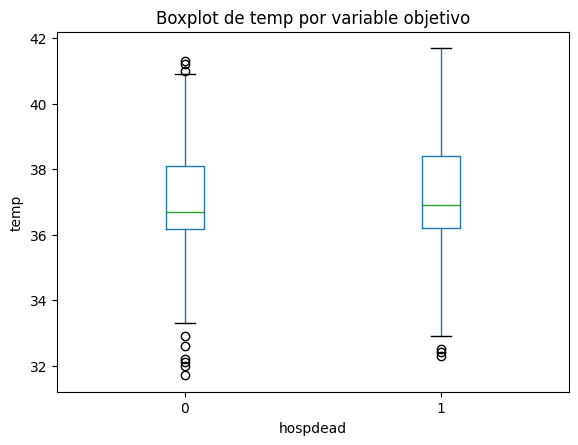

<Figure size 1000x1000 with 0 Axes>

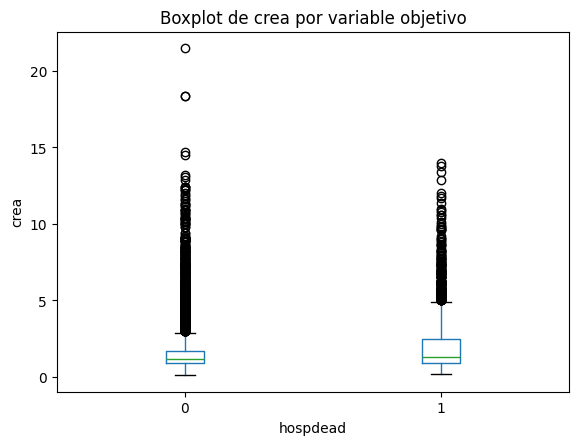

<Figure size 1000x1000 with 0 Axes>

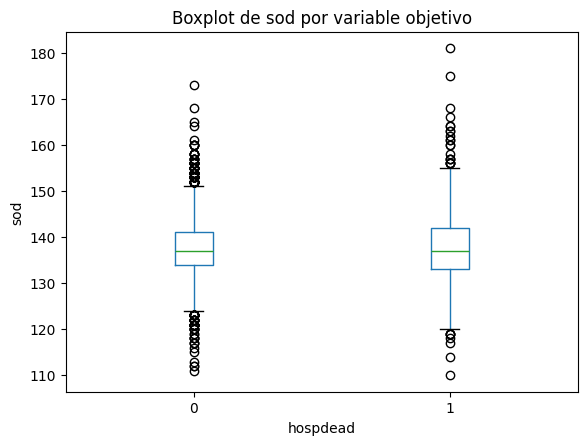

<Figure size 1000x1000 with 0 Axes>

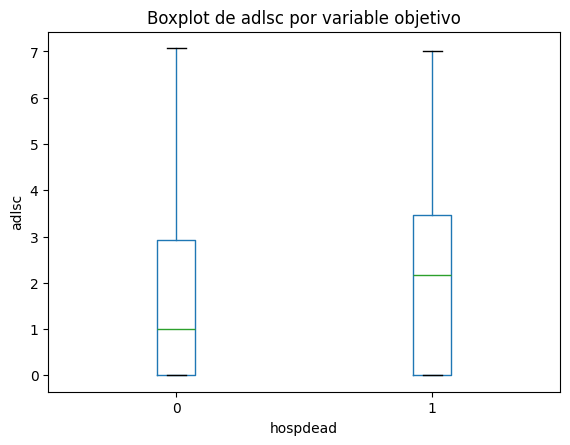

In [23]:

for column in numeric_columns:
    plt.figure(figsize=(10, 10))
    data.boxplot(column=column, by='hospdead', grid=False)   
    plt.title(f'Boxplot de {column} por variable objetivo')
    plt.suptitle("")
    plt.xlabel('hospdead')
    plt.ylabel(column)
    plt.show()

Como se puede apreciar hay algunas distribuciones de las variables numéricas que varían de acuerdo a la etiqueta de la variable objetivo. Así:
- La variable edad, la distribución es muy parecida, de hecho los valores atípicos frente a la variable objetivo, son los jóvenes de 18 años.
- En la variable num.co,  casi toda la distribución se concentra en el valor 2 cuando la persona muere en el hospital, lo cual es contradictorio, pues esta variable nos dice que a mayor valor de comorbilidades más riesgo de morir tiene la persona. No obstante gráficamente se ve que la mayoría de los pacientes que mueren solo tenían dos comorbilidades.
- La distribución de la variable scoma, es casi inexistente en el caso de no muerte en el hospital, aunque si bien se presentan casos atípcios. Mientras que los pacientes que murieron tuvieron una mayor distribución en los días que pasaron en coma.
- Los valores de las variables avtisst, sps y aps, son mayores en las personas que mueren en el hospital. Avtisst al estar relacionado con el costo de la UCI, nuevamente nos deja ver que posiblemente las personas que murieron necesitaron ingresar a la UCI y dada su condición duraron mucho tiempo en eta incrementando los gastos de esta.
- Los valores de las variables surv2m y surv6m son relativamente más bajos en el caso de muerte. Esto como ya se vió es el comportamiento esperado, pues al ser la probabilidad de muerte, nos confirma que quienes sobrevivieron tenían valores más altos dados por este score.
- hdy: esta variable son los días que estuve el paciente en el hospital. Es más común que quienes murieron pasaran más días en el hospital que en los casos en los cuales el paciente no murió. No obstante, en el caso de no muerte hay presencia de varios valores atípicos.

#### OUTLIERS

Cómo pudo observarse de manera gráfica hay presencia de outliers en algunas de las variables numéricas. Se corroborará esto empleando el rango intercuartílico IQR. 

Esto puedo ser un problema, dependiendo del modelo de clasificación que se emplee, lo cual podría llevar a que se necesite corregir este problema. No obstante, como ya se mencionó, depende del clasificador usado, dado que si se emplean modelos árboreos, estos tienden a ser más robustos frente a la presencia de outliers.

In [24]:
outlier_summary = pd.DataFrame()
for column in numeric_columns:
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)][column]
    
    percentage = (len(outliers) / len(data[column])) * 100

    if not outliers.empty:
        temp_df = pd.DataFrame({'Variable': [column], 'Outliers': [len(outliers)], 'Percentage': [percentage]})
        outlier_summary = pd.concat([outlier_summary, temp_df], ignore_index=True).sort_values(by='Percentage', ascending=False).reset_index(drop=True)
outlier_summary

Variable  Outliers  Percentage
0     scoma      1955   21.471719
1      hday      1543   16.946733
2      crea       987   10.840198
3    dnrday       799    8.775398
4      resp       313    3.437672
5    surv2m       307    3.371774
6       sps       283    3.108182
7       sod       256    2.811642
8       aps       178    1.954970
9       age        56    0.615047
10  avtisst        43    0.472268
11      hrt        40    0.439319
12   num.co        25    0.274574
13     temp        14    0.153762
14   meanbp         6    0.065898

Como puede observarse, Hay 15 de 17 variables numéricas que tienen presencia de outliers. Unas en menor medida, como meanbp, que sólo tiene 6 valores atípicos que representan menos del 0.07% y otras como scoma que tienen cerca del 21% de sus datos como valores atípicos. En ese orden de ideas, vemos que el problema de outliers es de tomar en cuenta, pues esta presente en varias variables y en al menso 4 de ellas tiene valores por encima del 8% del total de sus observaciones.

Cómo ya se mencionó, para algunos de los algoritmos de clasificación esto podría suponer un problema en caso de no tratarse (podría por ejemplo para tratar este problema: truncar los valores y sustituirlos por una medida de tendencia central, o podría usarse alguna transformación como logaritmo natural para suavizar este comportamiento o podría usarse un escalador robusto de los datos como el robust standard scaler, o podría en última instancia eliminarse los datos.). No obstante, también debe tenerse en cuenta que los algoritmos arbóreos son más robustos a este tipo de valores atípicos y no se verán tan afectados como otro modelos (SVM, regresión logística, etc).

#### CORRELACIÓN LINEAL PEARSON ENTRE VARIABLES NÚMERICAS (MATRIZ DE CORRELACIÓN) - EN BUSCA DE MULTICOLINEALIDAD.

A continuación, se realizará la matriz de correlación entre las variables númericas, esto con el fin de ver si linealmente algunas de las variables están muy correlacionadas y puede haber riesgo de multicolinealidad. Este problema, nuevamente afectará a ciertos algoritmos de clasificación como la regresión logística, mientras que a otrso algoritmos qu eson más robustos a esto, no los afectará en igual medida. Asismismo, vale la pena ver este comportamiento, pues porque en caso de existir, tendriamso variables que son muy simialres y qu eno aportan nada nuevo al modelo, siendo reduandantes y dandonos la posibilidad de eliminar alguna de ellas.

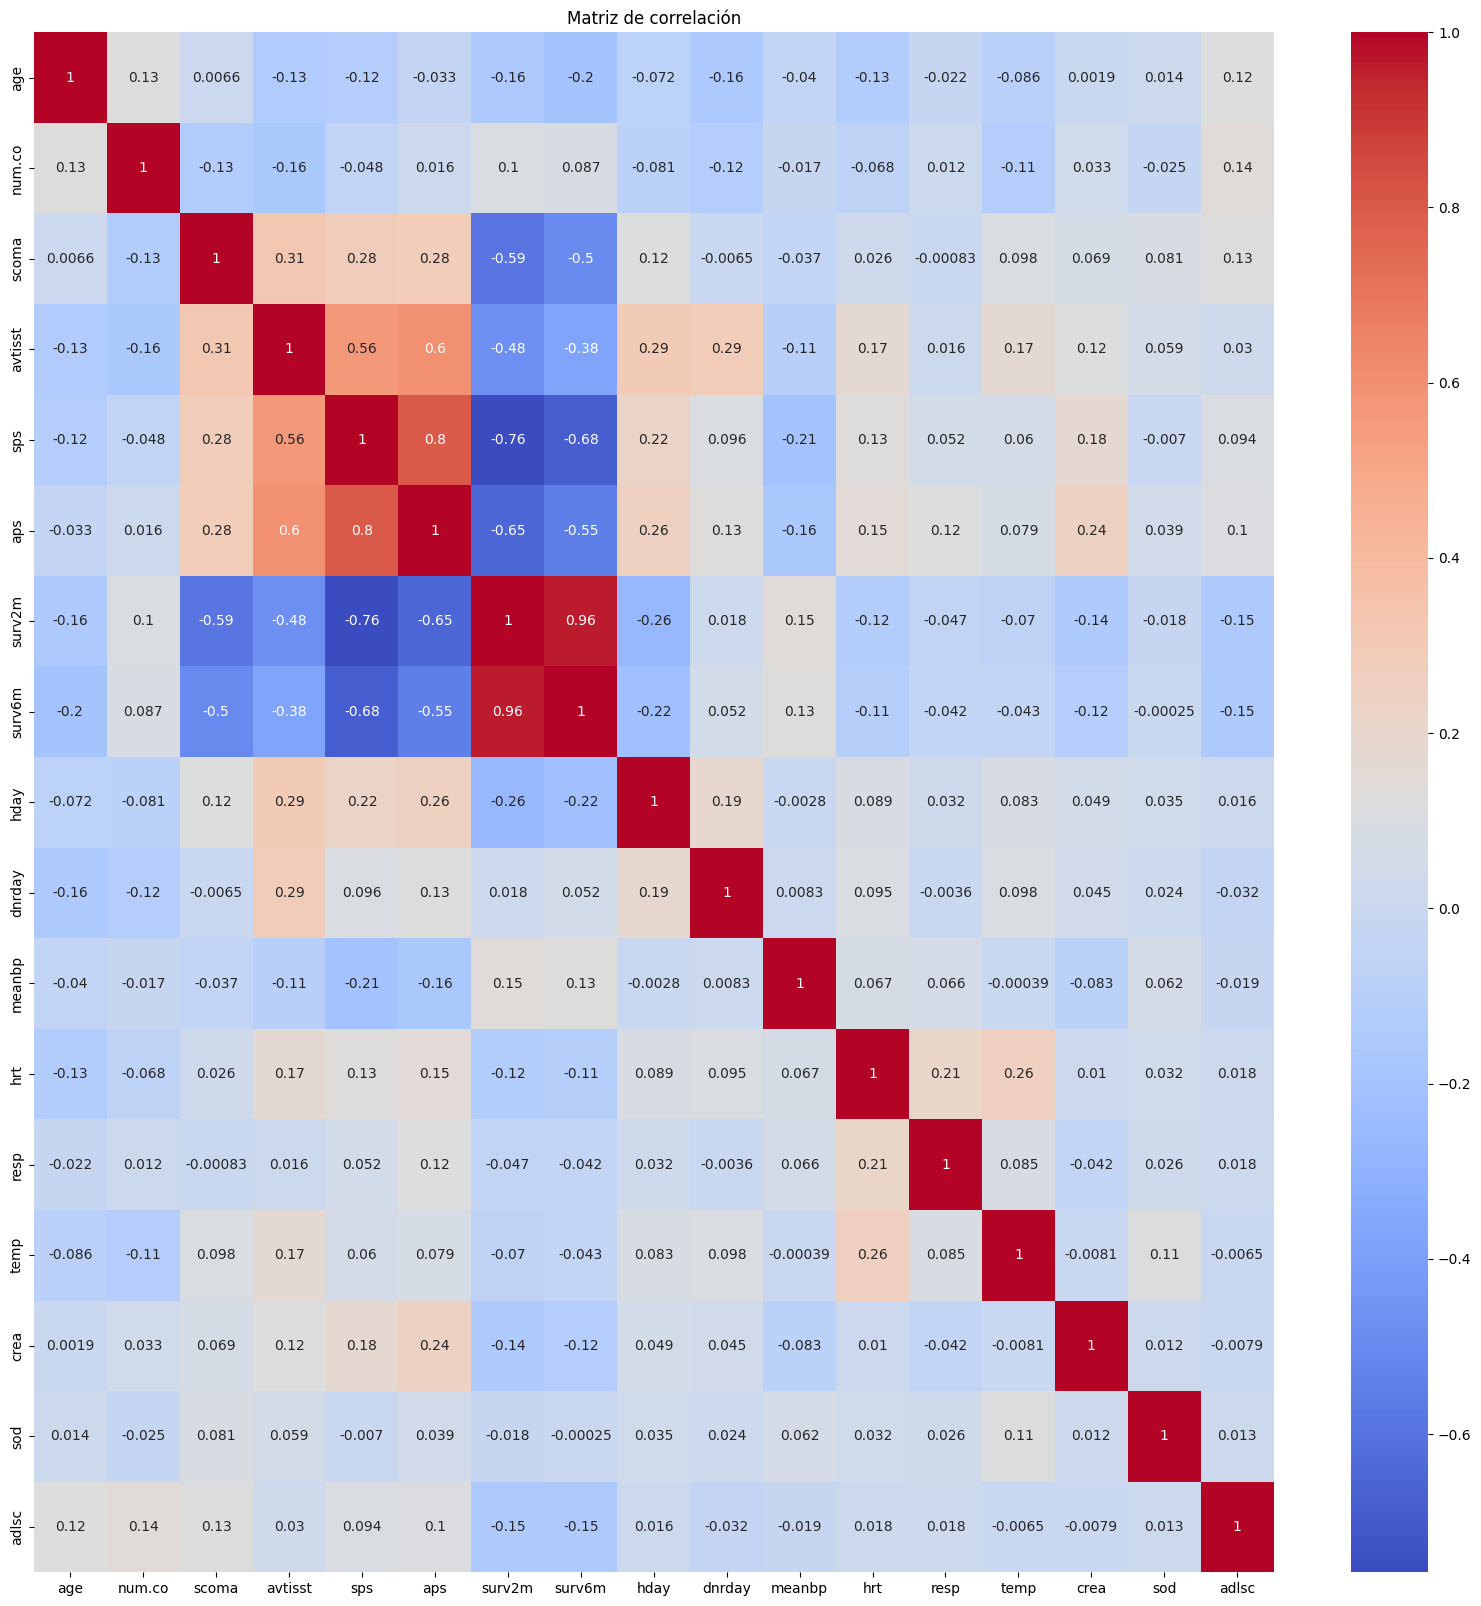

In [25]:
correlation_matrix = data[numeric_columns].corr()
plt.figure(figsize=(20,20))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Matriz de correlación')
plt.show()

AL realizar la matriz de correlación entre las variables numéricas, vemos que hay correlaciones lineales fuertes (directas(positivas) e indirectas (negativas)). Vemos así por ejemplo que la correlación entre las variables sps y aps es de 0.8. Asimismo, hay alta correlación indirecta entre las variables surv2m y surv6m con la variable sps y aps. Estas correlaciones tan fuertes podrían decirnos que podría existir un cierto problema de multicolinealidad lineal entre algunas de las variables. en potras palabras que al menos linealmente, estas variables están muy relacionadas, tanto que son muy parecidas. Lo cual no agrega variabilidad al modelo y si agrega redundancia además del problema de la multicolinealidad. No obstante, el tener variables así de correlacionadas, nos lleva a pensar en la posibilidad de quitar una de ellas.

#### CORRELACIÓN BISERAL PUNTUAL

Se aplicará ahora la correlación biserial entre las variables numéricas y la variable objetivo (dicótoma o que toma dos valores). Esta correlación es muy similar a la de pearson, pero está adaptada al la variable objetivo dicotoma. Para calcular esta, se creará otro data frame solo con las variables numéricas (la razón para esto y no para hacer el slice del data frame original como se venía haciendo usando las columnas numéricas, es porque para poder calcular la correlación biserial, se debe tener un data frame sin valores vacios, y como vimos en la data original hay valores vacios. Y como en esta sección aún no se corregirá el problema de missing values, por ende, se decidió crear un data frame alterno en el cual se eliminan los valores vacios, para poder calcular la correlación biserial. 

   Variable  Correlación Biserial Puntual
0   avtisst                      0.552142
1       aps                      0.472545
2       sps                      0.459813
3     scoma                      0.376871
4      hday                      0.212163
5     adlsc                      0.125542
6      crea                      0.096681
7       hrt                      0.095366
8      temp                      0.071904
9       age                      0.038491
10      sod                      0.030707
11     resp                      0.021502
12   dnrday                     -0.058195
13   num.co                     -0.077084
14   meanbp                     -0.087515
15   surv6m                     -0.496531
16   surv2m                     -0.555823


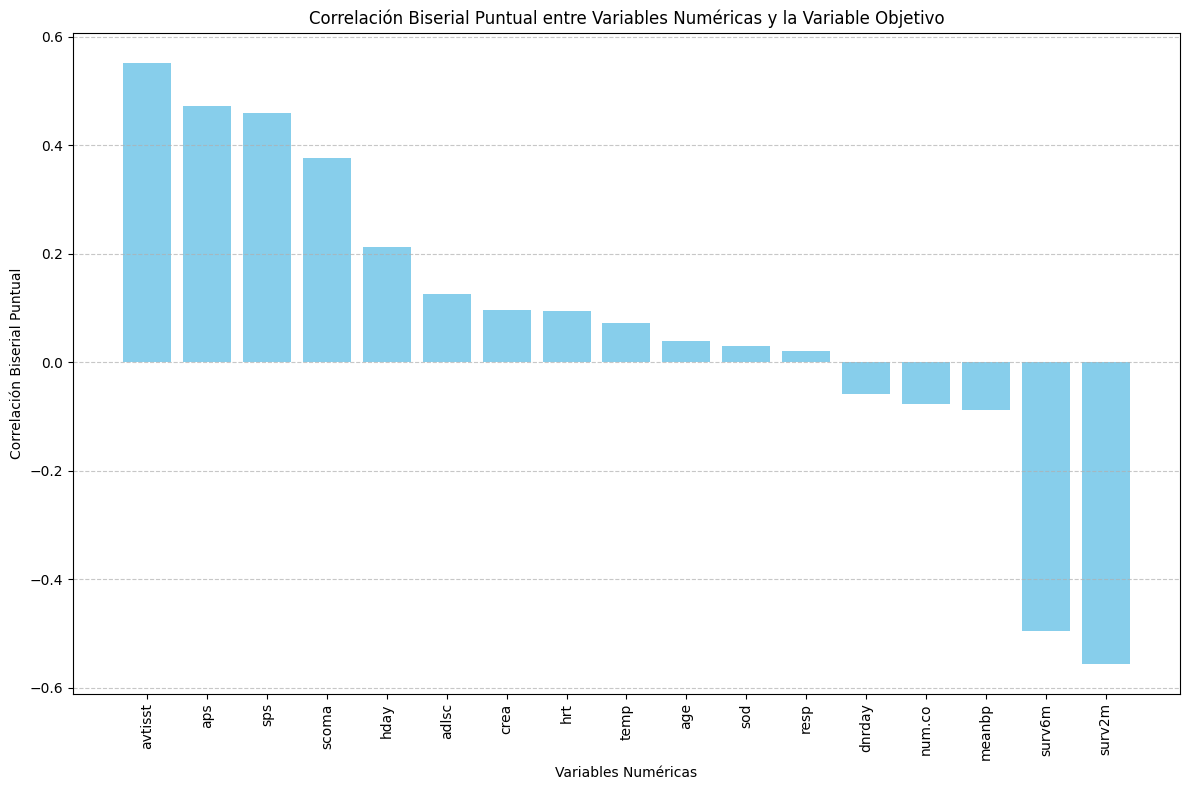

In [26]:
numeric_data = data.select_dtypes(include=['float64', 'int64'])
numeric_data = numeric_data.dropna()
data['hospdead_numeric']=data['hospdead'].astype('int')
numeric_data_clean = numeric_data.join(data['hospdead_numeric'])

numeric_columns_clean = numeric_data_clean.drop(columns=['hospdead_numeric'])
hospdead_clean = numeric_data_clean['hospdead_numeric']

correlations = []
for column in numeric_columns_clean.columns:
    corr, _ = pointbiserialr(numeric_columns_clean[column], hospdead_clean)
    correlations.append((column, corr))

correlation_df = pd.DataFrame(correlations, columns=['Variable', 'Correlación Biserial Puntual']).sort_values(by='Correlación Biserial Puntual', ascending=False).reset_index(drop=True)
print(correlation_df)
plt.figure(figsize=(12, 8))
plt.bar(correlation_df['Variable'], correlation_df['Correlación Biserial Puntual'], color='skyblue')
plt.xlabel('Variables Numéricas')
plt.ylabel('Correlación Biserial Puntual')
plt.title('Correlación Biserial Puntual entre Variables Numéricas y la Variable Objetivo')
plt.xticks(rotation=90)  # Rotar etiquetas del eje x para mejor legibilidad
plt.tight_layout()       # Ajustar el diseño para evitar que se corten las etiquetas
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Las correlaciones positivas implican que a medida que aumentan los valores de estas variables numérica, aumenta asímismo el probable resultado de muerte o etiqueta 1. Esto corroborá lo hasta aqui visto y analizado de la variable avtisst, scoma, hday entre otras. Por otra parte, la correlación negativa indicaría lo contrario, uan relación indirecta, implicando que a mayor valor de esa variable menor es la probabilidad de tener la etiqueta 1. Este es el caso de las variables surv6m y surv2m, que como se ha visto, a mayor valor de este menor es la distribución de lso datos en la etiqueta 1, pues indican mayor probabilidad de score de sobrevivir en 2 y 6 meses.

#### MANN-WHITNEY U

Finalmente se realiza la prueba de Mann-Whiteney U, dado que por falta de normalidad en las variables no se podía emplear la prueba ANOVA.
Esta prueba nos mostrará estadísticamente si los grupos formados por las etiquetas de la variable objetivo (paciente muere (1), paciente sobrevive (0)), para cada variable numérica son diferentes.
Aquí, también se realizará una prueba de hipótesis, teniendo como hipótesis nula H0: Que hay diferencia significativa entre ambos grupos (etiquetas de la variable objetivo) vs H1: No hay diferencia significativa. Se empleará el umbral de P-Value de 0.05. De obtenerse un valor menor, se rechazaría la H0.

In [27]:
for column in numeric_columns:

    group1 = data[data['hospdead'] == 1][column].dropna()
    group0 = data[data['hospdead'] == 0][column].dropna()
    
    stat, p_value = mannwhitneyu(group1, group0, alternative='two-sided')
    
    print(f"Variable: {column}")
    print(f"Mann-Whitney U Statistic: {stat}, p-value: {p_value}")
    
    if p_value < 0.05:
        print("Diferencia significativa entre los grupos.\n")
    else:
        print("No hay diferencia significativa entre los grupos.\n")

Variable: age
Mann-Whitney U Statistic: 8436555.5, p-value: 1.3976845531607691e-05
Diferencia significativa entre los grupos.

Variable: num.co
Mann-Whitney U Statistic: 7162648.0, p-value: 7.586768876642057e-14
Diferencia significativa entre los grupos.

Variable: scoma
Mann-Whitney U Statistic: 10916548.0, p-value: 2.454976880047977e-244
Diferencia significativa entre los grupos.

Variable: avtisst
Mann-Whitney U Statistic: 13083735.0, p-value: 0.0
Diferencia significativa entre los grupos.

Variable: sps
Mann-Whitney U Statistic: 12527611.0, p-value: 0.0
Diferencia significativa entre los grupos.

Variable: aps
Mann-Whitney U Statistic: 12579373.0, p-value: 0.0
Diferencia significativa entre los grupos.

Variable: surv2m
Mann-Whitney U Statistic: 2535919.5, p-value: 0.0
Diferencia significativa entre los grupos.

Variable: surv6m
Mann-Whitney U Statistic: 3014872.0, p-value: 0.0
Diferencia significativa entre los grupos.

Variable: hday
Mann-Whitney U Statistic: 10539200.5, p-value:

Podemos ver así, que según esta prueba, existen diferencias significativas en los grupos dados por la etiqueta de la variable objetivo en todas las variables numéricas excepto en la variable sod. Esto implica que todas las variables numéricas a excepción del nivel de sodio (sod) parecen tener cierto impacto en la variable objetivo, pues dentro de ellas existen diferencias significativas y patrones que permiten diferenciar una etiqueta de la otra.

### VARIABLES CATEGÓRICAS

Al igual que se realizó un análisis para las variables numéricas se hará lo mismo para las variables categóricas

In [28]:
data=data.apply(lambda x: x.astype('category') if x.dtype == 'object' else x)

In [29]:
categorical_columns=data.select_dtypes(include='category').drop(['hospdead'], axis=1).columns
categorical_columns

Index(['sex', 'dzgroup', 'dzclass', 'race', 'diabetes', 'dementia', 'ca',
       'dnr'],
      dtype='object')

In [30]:
len(categorical_columns)

8

Se cuenta con 8 variables de tipo categórico, sin incluir la variable objetivo.

#### DESCRIPTIVOS DE LAS VARIABLES CATEGÓRICAS

In [31]:
data[categorical_columns].describe().T

count unique                top  freq
sex       9105      2               male  5125
dzgroup   9105      8  ARF/MOSF w/Sepsis  3515
dzclass   9105      4           ARF/MOSF  4227
race      9063      5              white  7191
diabetes  9105      2                  0  7327
dementia  9105      2                  0  8809
ca        9105      3                 no  5995
dnr       9075      3             no dnr  5880

Puede observarse como la mayor cantidad de categorías reca sobre la variable dzgroup que es la subcategoria de la enfermedad del paciente, con 8 posibles valores. Seguida de la variable race con 5 categorías (con una mayor prepronderacia de la raza blanca) y seguida por la variable dzclass (que indica la categoría de la enfermedad del paciente). Se espera entonces que ambas variables: dzgroup y dzclass, sean muy similares, pues una (dzgroup) esta contenida dentro de la otra (dzclass). Esto podría conllevar a problemas de multicolinealidad si se procesan usando OHE además de introducir redundancia de información al modelo.

Asimismo, hay que tener presente la cantidad de categorías presentes en estas variables, puesto que si han de numerizarse para que algunos de los algoritmos puedan procesarlas (como es el caso de la regresión logística y SVM), esto podría suponer un aumento en la dimensionalidad (en caso de usarse OHE para numerizarlas).

#### NÚMERO DE CATEGORIAS EN LAS VARIABLES CATEGÓRICAS

Relacionado con lo anterior, se hace una exploración de las categorias dentro de cada variable categórica.

In [32]:
category_counts = pd.DataFrame(columns=['Variable', 'Número de Categorías', 'Categorías'])
pd.set_option('display.max_colwidth', None)

for column in categorical_columns:
    unique_categories = data[column].nunique()  
    categories_list = data[column].unique()     

    temp_df = pd.DataFrame({'Variable': [column], 
                            'Número de Categorías': [unique_categories],
                            'Categorías': [categories_list]})
    
    category_counts = pd.concat([category_counts, temp_df], ignore_index=True)

category_counts

Variable Número de Categorías  \
0       sex                    2   
1   dzgroup                    8   
2   dzclass                    4   
3      race                    5   
4  diabetes                    2   
5  dementia                    2   
6        ca                    3   
7       dnr                    3   

                                                                                                                                                                                                                                  Categorías  
0                                                                                                                                                                              ['male', 'female']
Categories (2, object): ['female', 'male']  
1  ['Lung Cancer', 'Cirrhosis', 'ARF/MOSF w/Sepsis', 'Coma', 'CHF', 'Colon Cancer', 'COPD', 'MOSF w/Malig']
Categories (8, object): ['ARF/MOSF w/Sepsis', 'CHF', 'COPD', 'Cirrhosis', 'Colon Cancer', 'Coma', 'Lung Cancer', 'MOSF w/Malig']  
2                                                                                                          ['Cancer', 'COPD/CHF/Cirrhosis', 'ARF/MOSF', 'Coma']
Categories (4, object): ['ARF/MOSF', 'COPD/CHF/Cirrhosis', 'Cancer', 'Coma']  
3                                                                                                             ['other', 'white', 'black', 'hispanic', 'asian', NaN]
Categories (5, object): ['asian', 'black', 'hispanic', 'other', 'white']  
4                                                                                                                                                                                                       [0, 1]
Categories (2, int64): [0, 1]  
5                                                                                                                                                                                                       [0, 1]
Categories (2, int64): [0, 1]  
6                                                                                                                                                            ['metastatic', 'no', 'yes']
Categories (3, object): ['metastatic', 'no', 'yes']  
7                                                                                                               ['no dnr', NaN, 'dnr after sadm', 'dnr before sadm']
Categories (3, object): ['dnr after sadm', 'dnr before sadm', 'no dnr']

#### DISTRIBUCIÓN DE LAS CATEGORIAS EN LAS VARIABLES CATEGÓRICAS

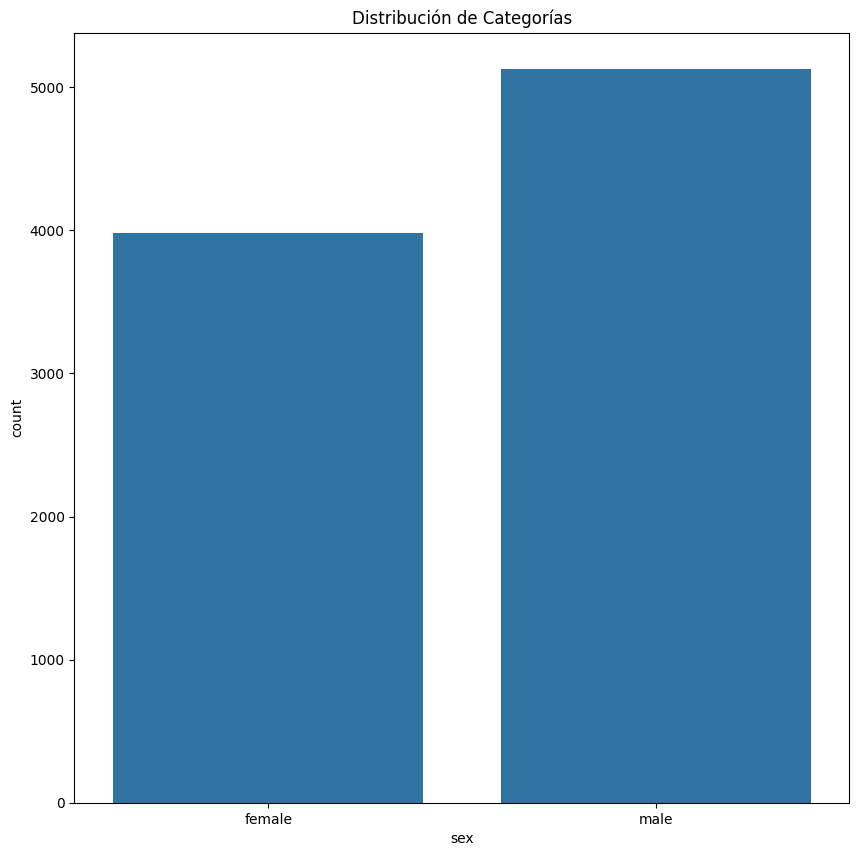

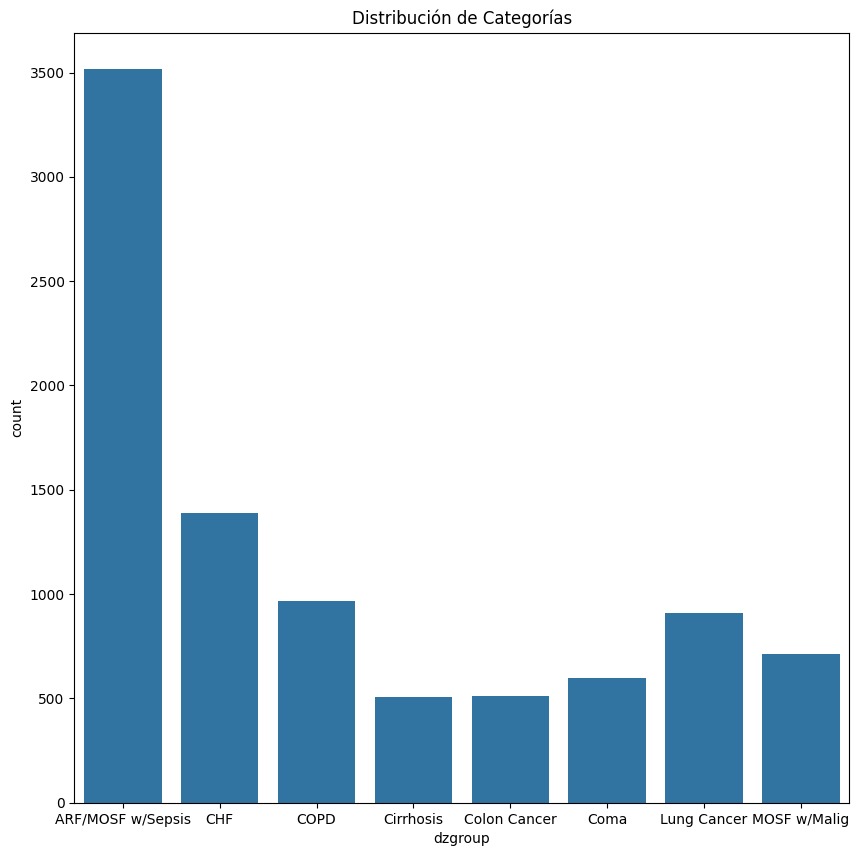

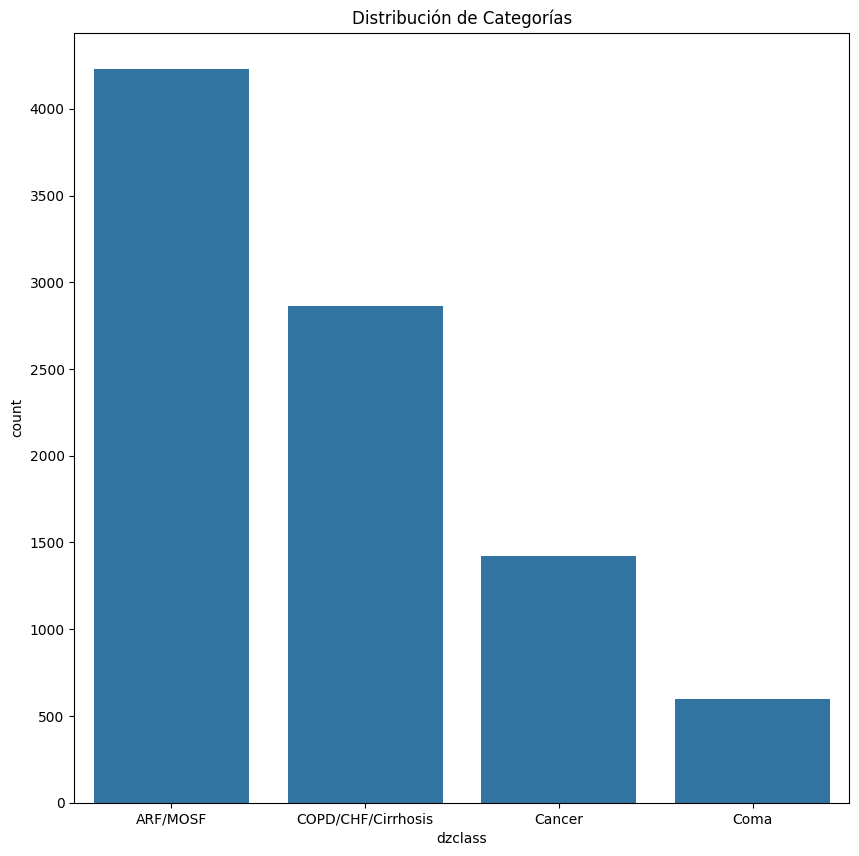

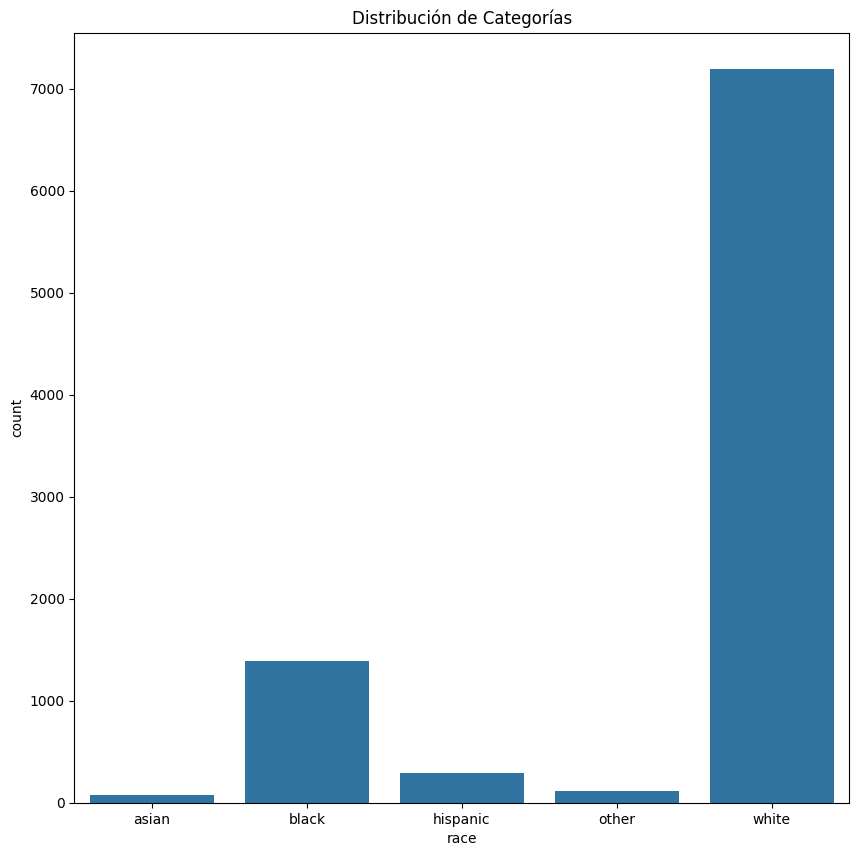

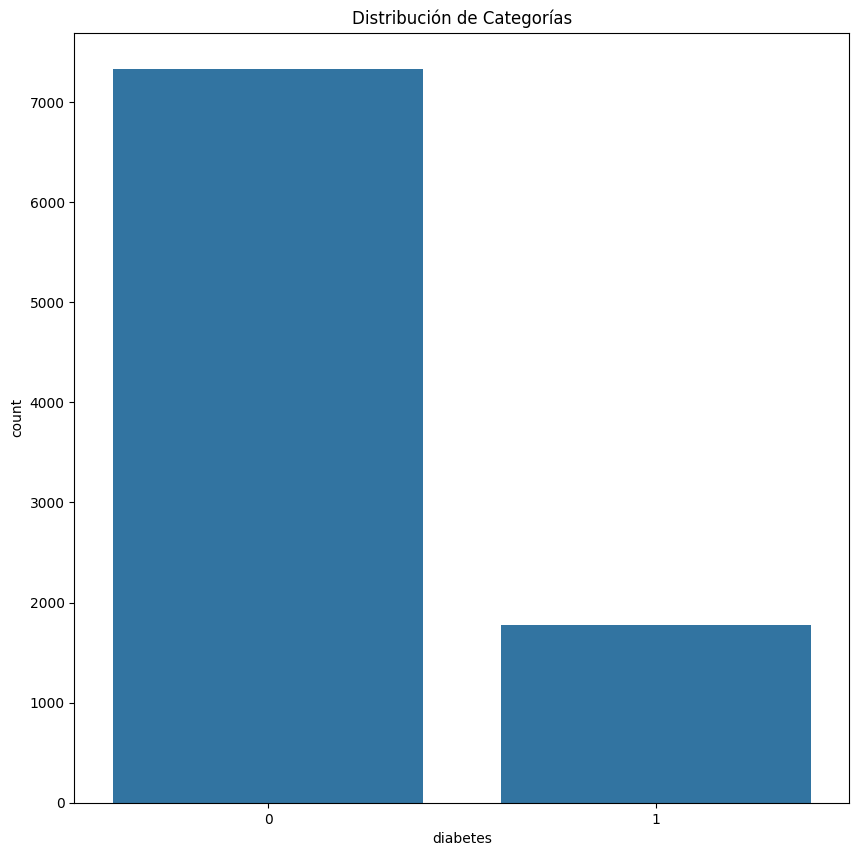

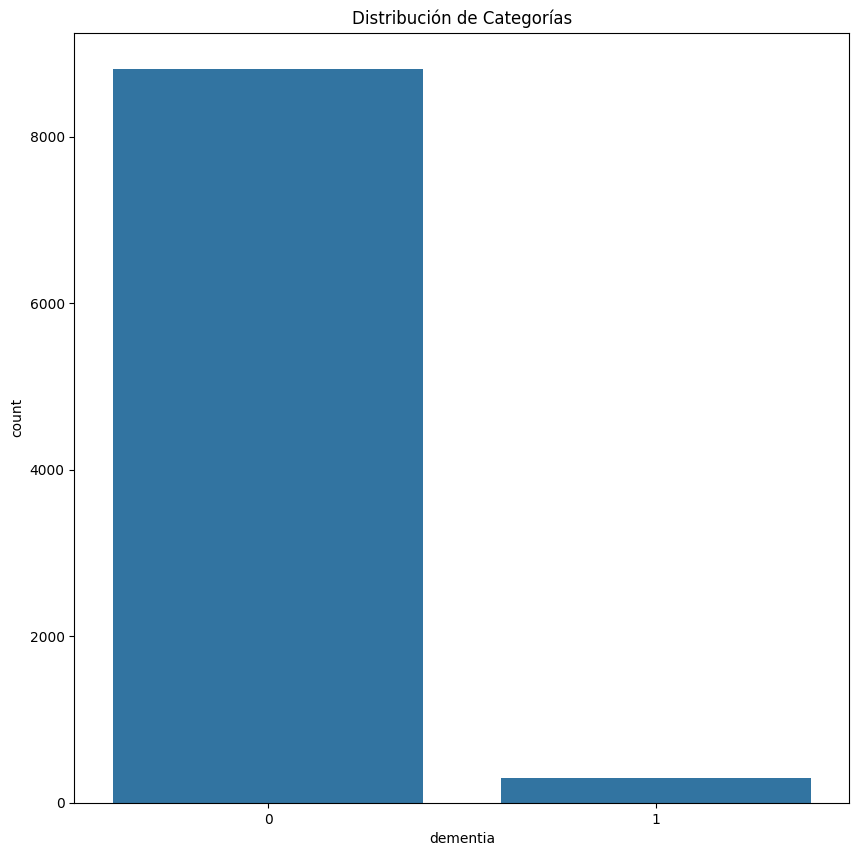

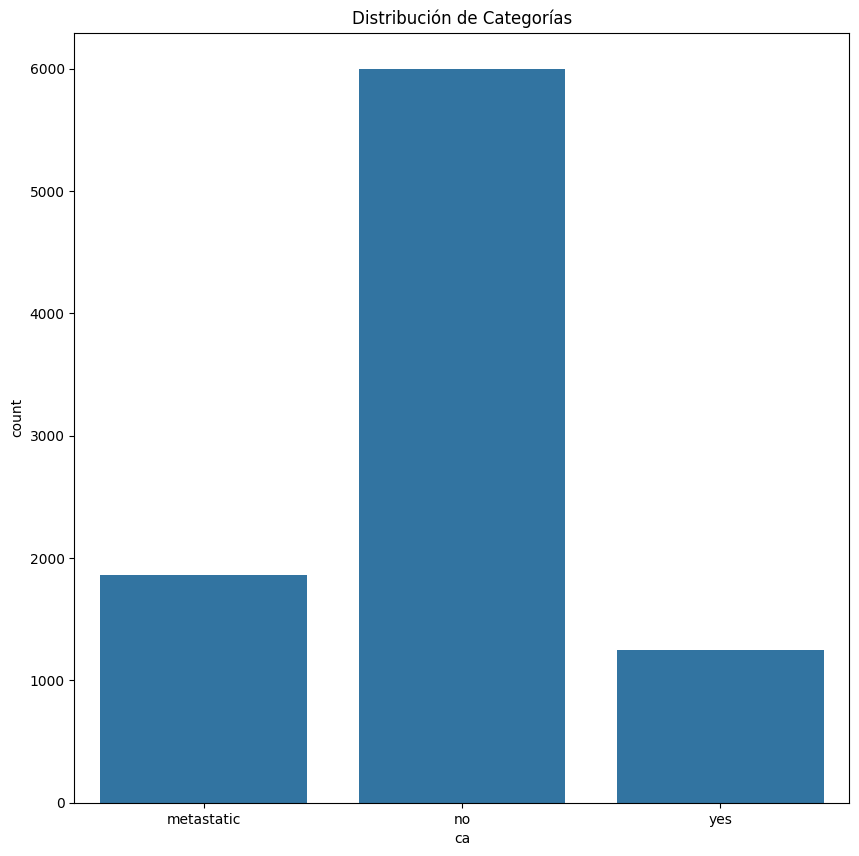

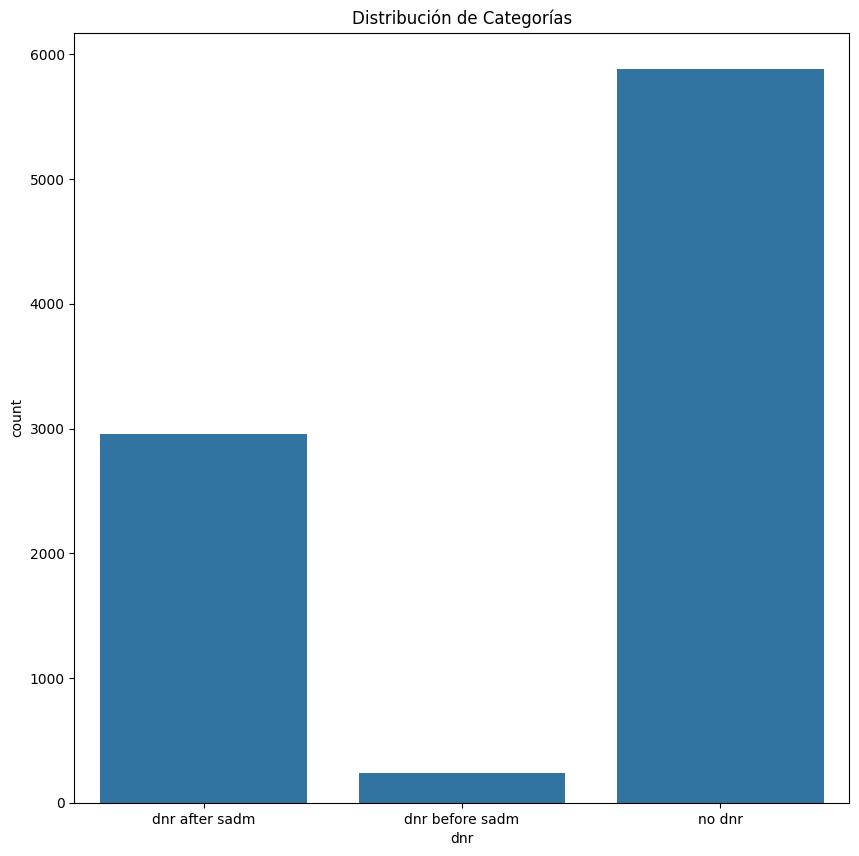

In [33]:
for column in categorical_columns:
    plt.figure(figsize=(10,10))
    sns.countplot(x=column, data=data)
    plt.title('Distribución de Categorías')
    plt.show()

Luego de ver como se distribuían las categorías dentro de cada variable gráficamente usando un gráfico de barras por variable categórica podemos concluir lo siguiente:
- Hay una mayor cantidad de hombres en el dataset (sex)
- La mayoría de los pacientes tenían enfermedades clasificadas en la subcategoria: ARF/MOSF w/Sepsis (dzgroup)
- La mayoría de los pacientes tenían enfermdades clasificadas en la categoría: ARF/MOSF, como ya se mencionó, la relción entre esta variable y dzgroup es muy alta, pues una es una subcategoria de la otra (dzclass)
- La mayoría de los pacientes son de raza blanca (race)
- La mayoría de los pacientes no presentaron diabetes (diabetes)
- La mayoría de lso pacientes no presentaron demencia (dementia)
- La mayoría de los pacientes no tenían cancer (ca)
- La mayoría de los pacientes no habían dado orden de reanimación (dnr)

#### DISTRIBUCIÓN VARIABLES CATEGÓRICAS RESPECTO A LA VARIABLE OBJETIVO.

Se realiza ahora gráficos de barras por cada variable categórica frente a la variable objetivo, para ver si existe alguna tendencia o relación entre estas.

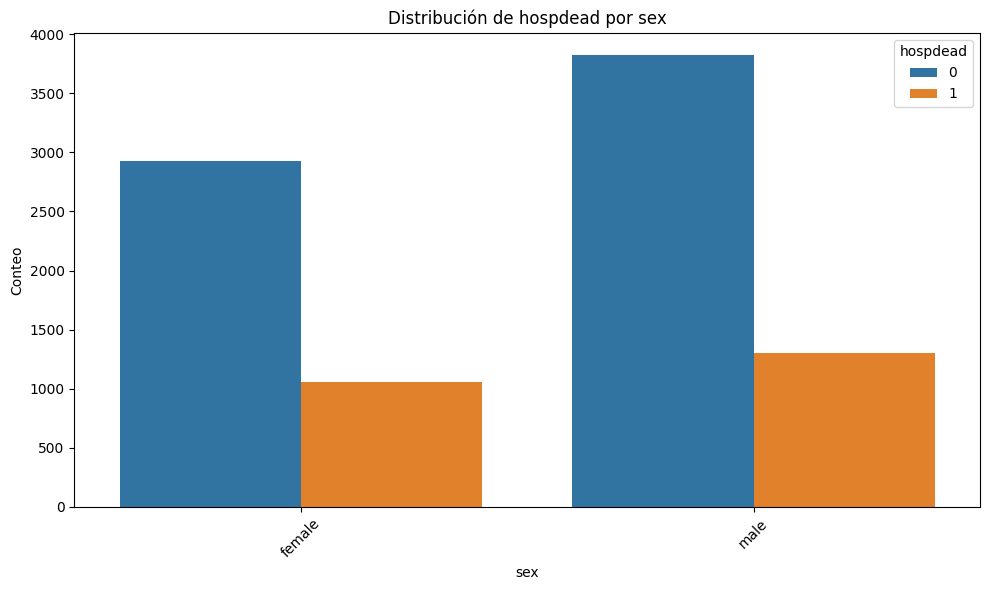

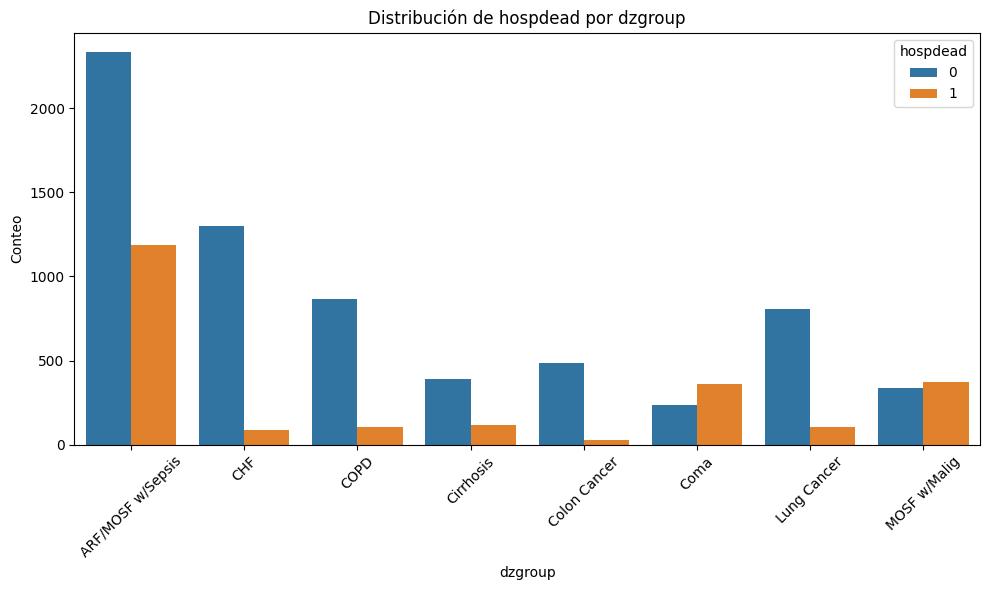

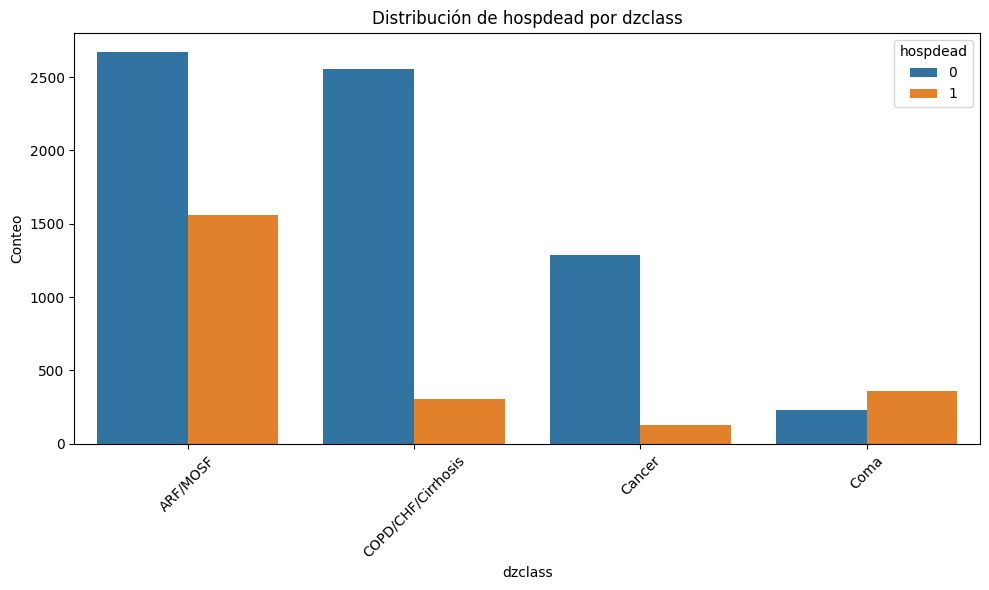

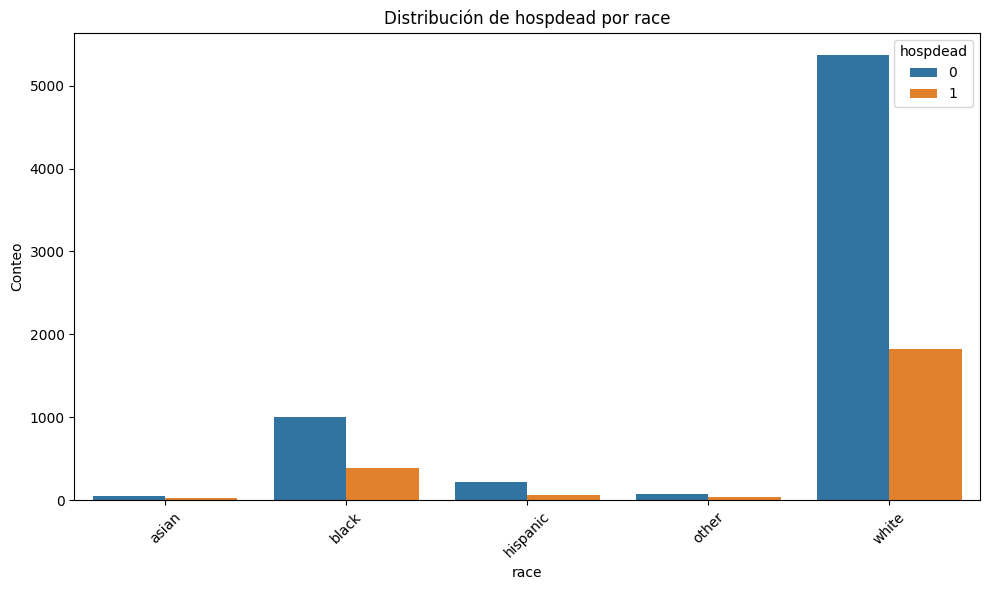

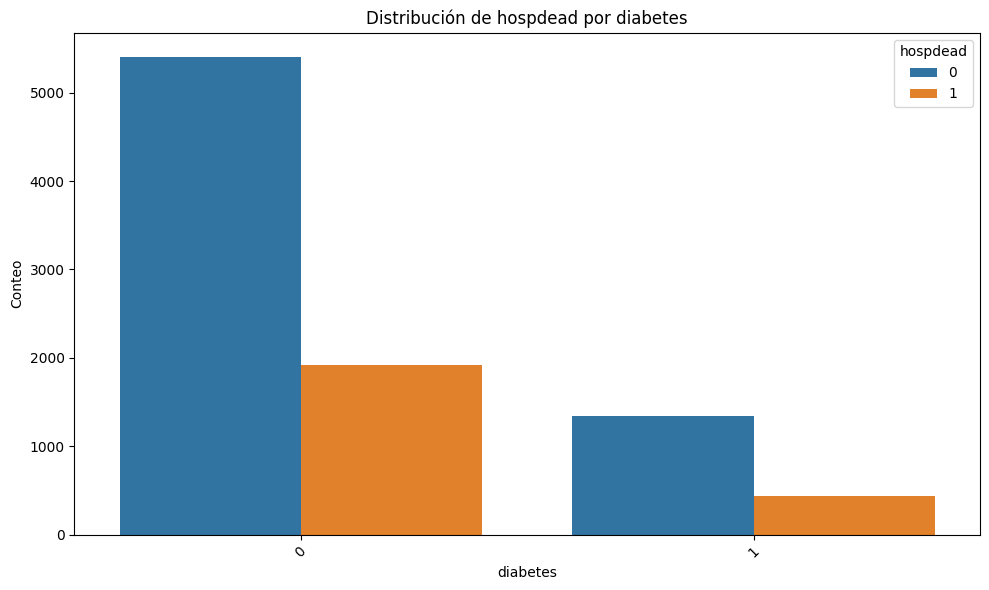

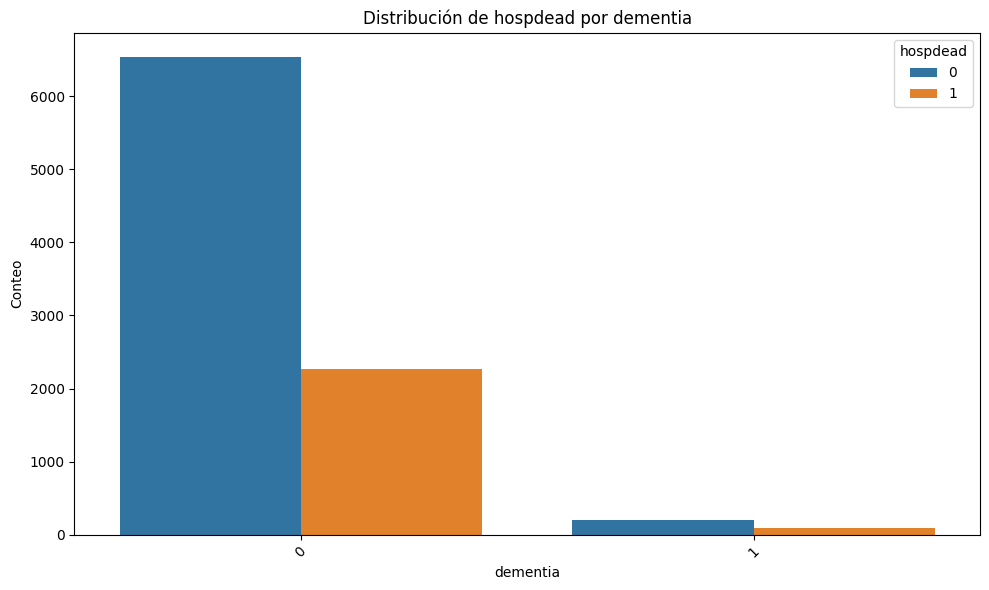

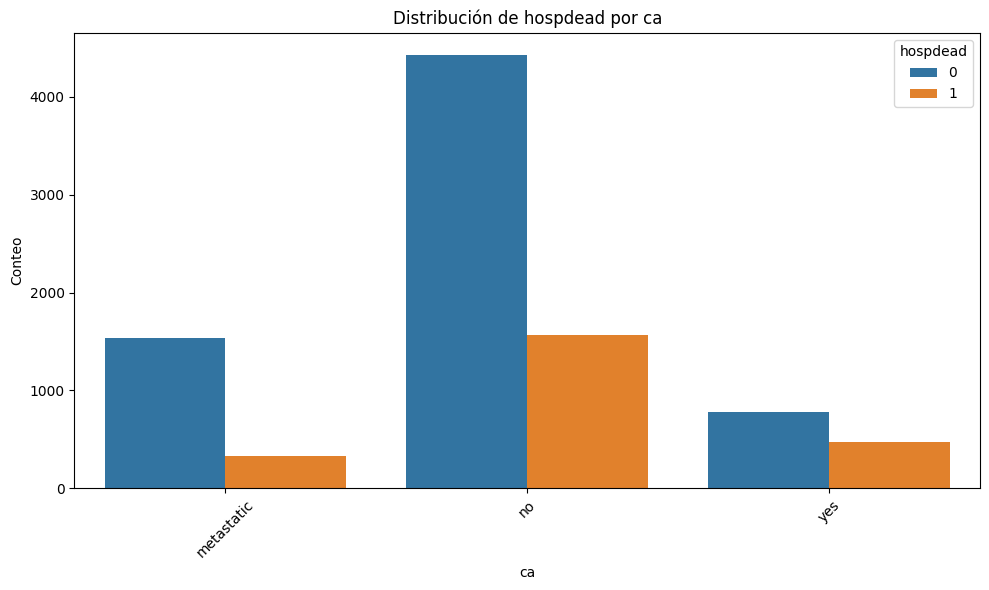

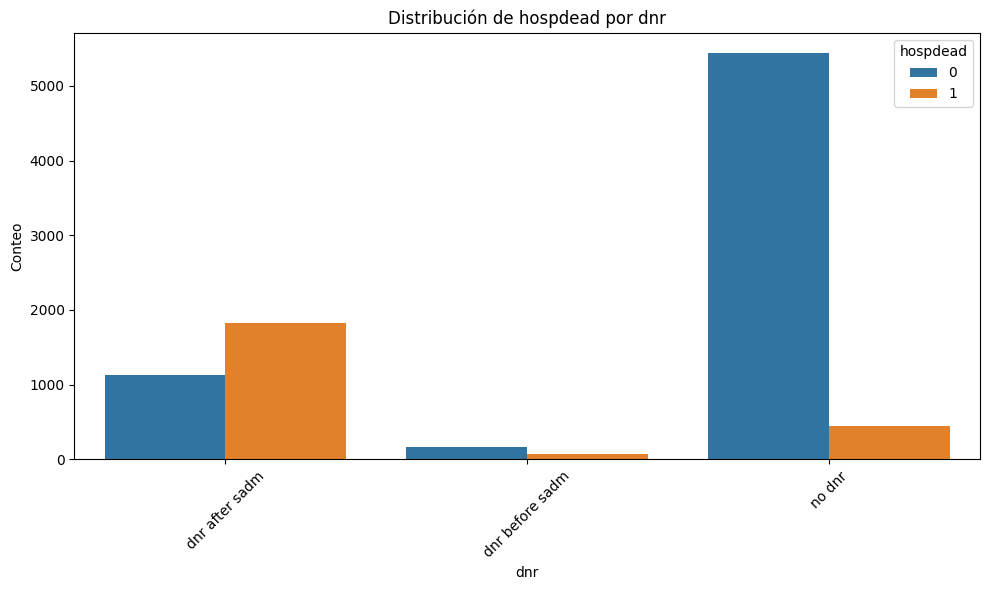

In [34]:
for column in categorical_columns:
    plt.figure(figsize=(10, 6))
    sns.countplot(x=column, hue='hospdead', data=data)
    plt.title(f'Distribución de hospdead por {column}')
    plt.xlabel(column)
    plt.ylabel('Conteo')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

Se puede concluir lo siguiente:

- Si bien hay más hombres en el estudio, la proporción de mujeres que mueren es muy similar a la de hombres.
- La proporción de pacientes que mueren por enfermedades categorizadas en la categoría ARF/MOSF w/Sepsis es más alta que en las demás categorías de enfermedades.
- Existe una mayor proporción de pacientes en coma que mueren al igual que los pacientes con enfermedades de fallo multiorganos con malignidad (MOSF/ Malig)

#### CATPLOT ENTRE LAS VARIABLES CATEGÓRICAS

Se realizará ahora gráficos de catplots entre las variables categóricas para entender un poco mejor las relaciones entre estas.

<Figure size 2000x40000 with 0 Axes>

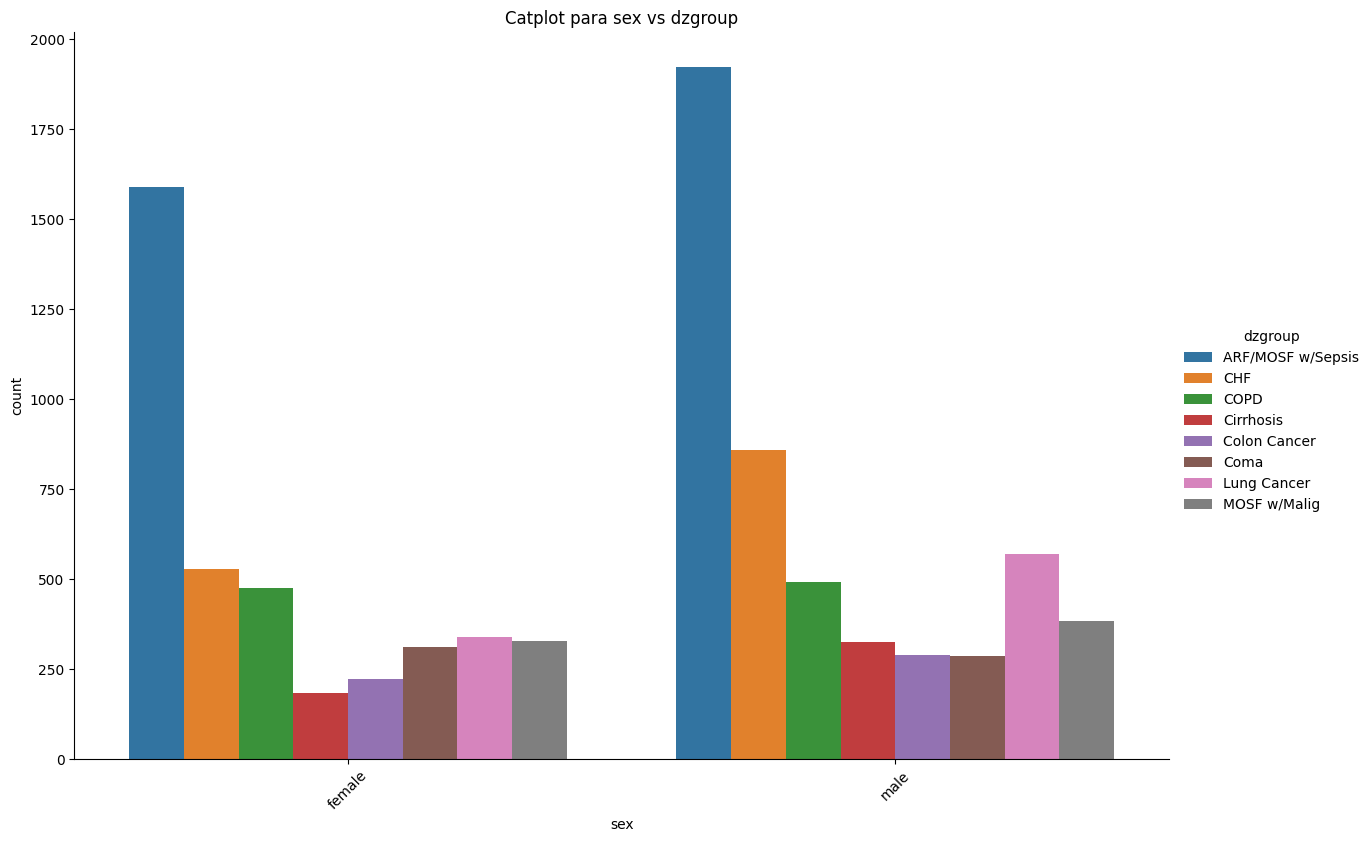

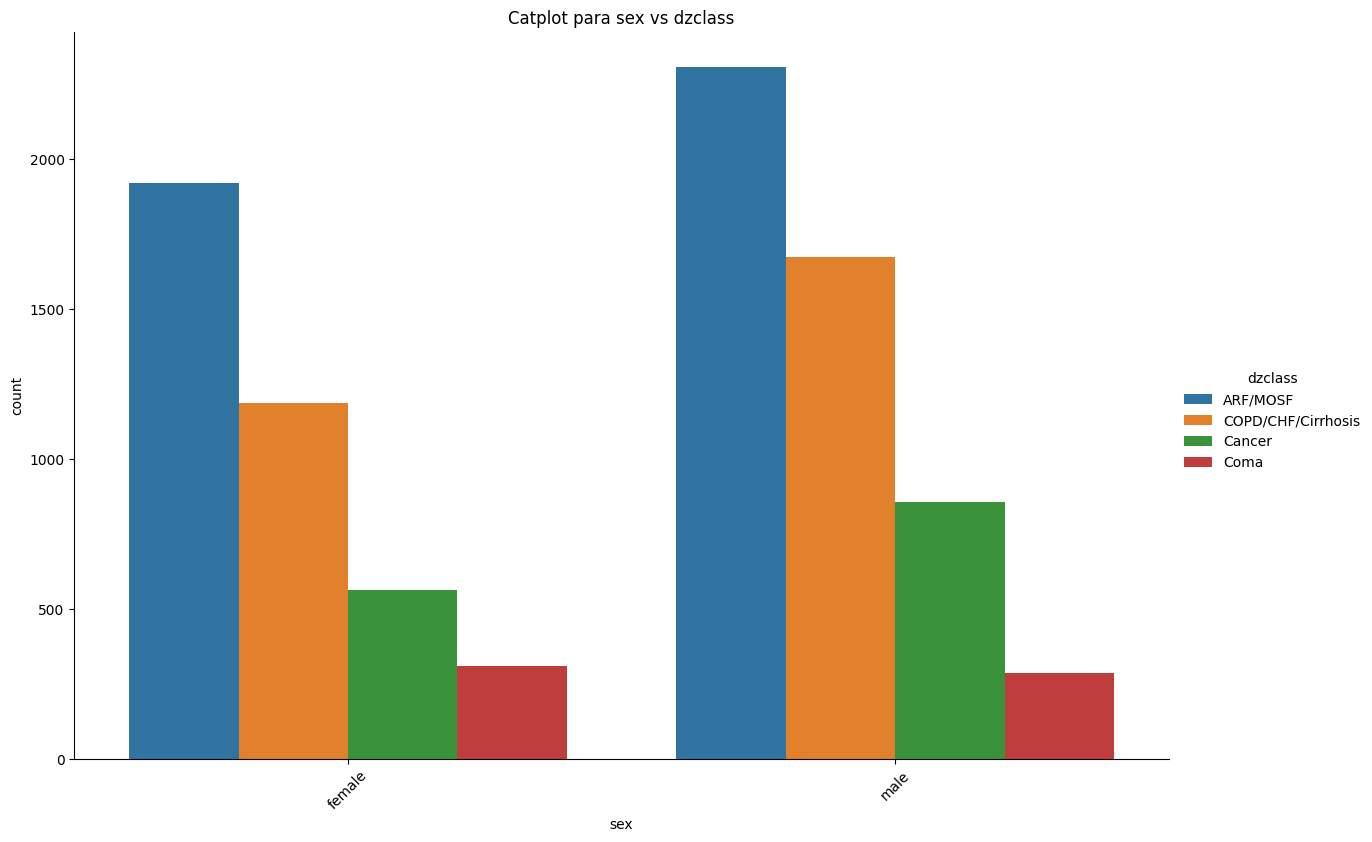

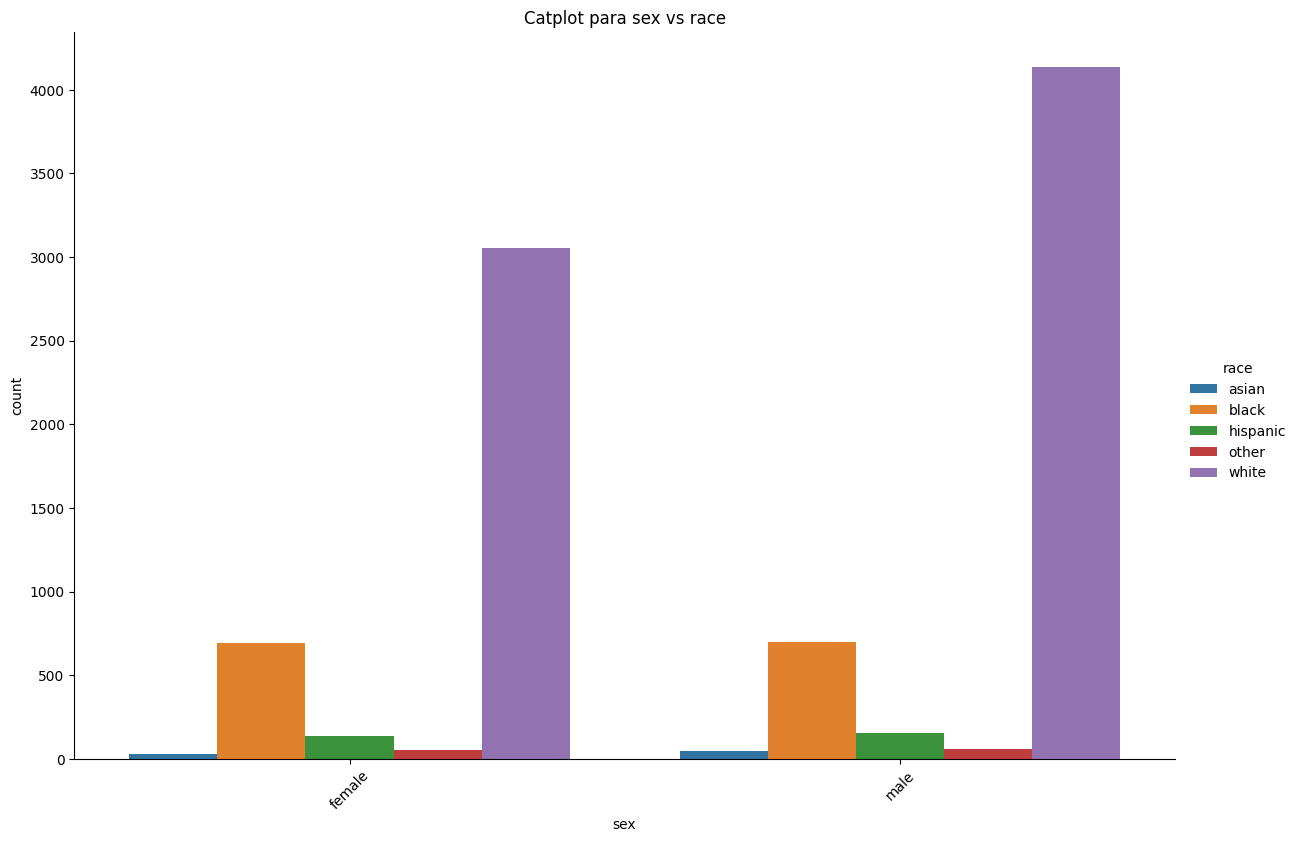

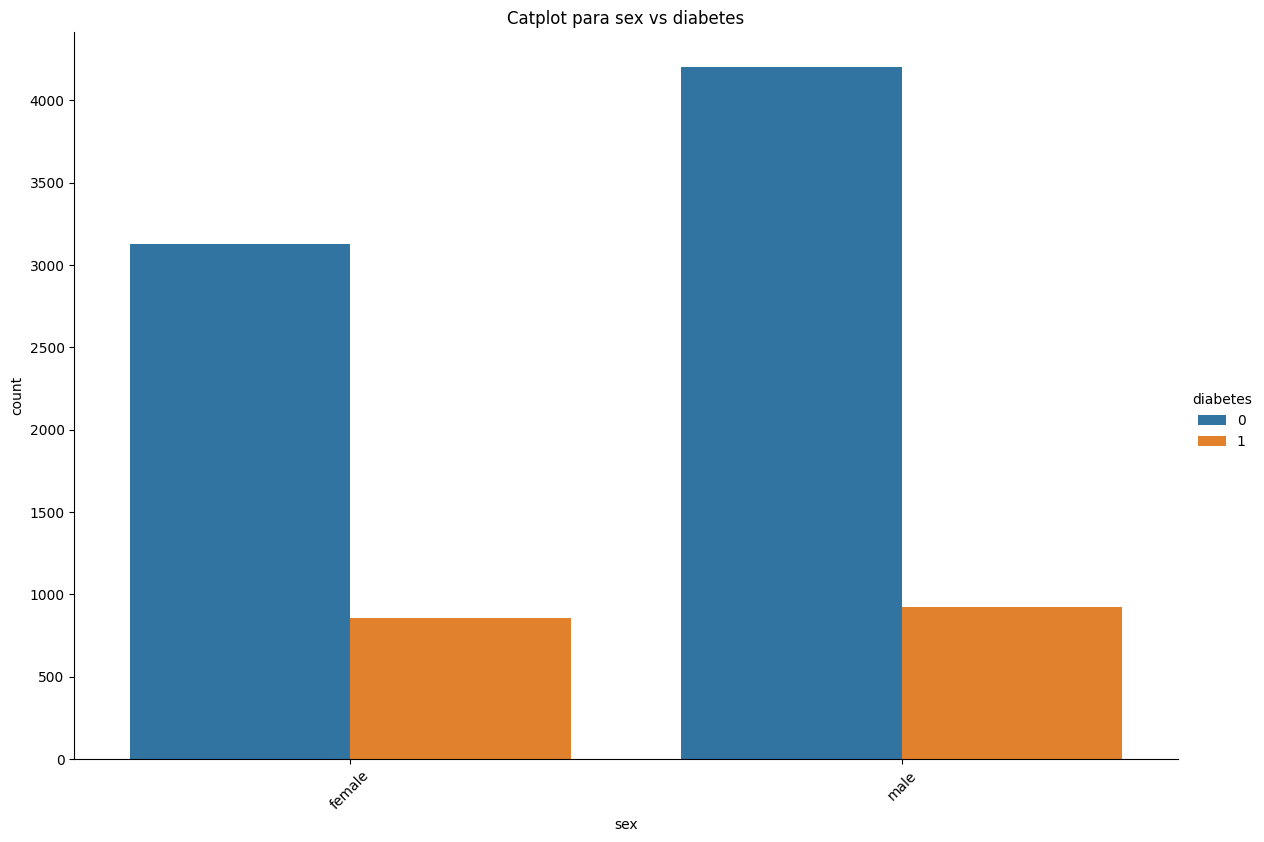

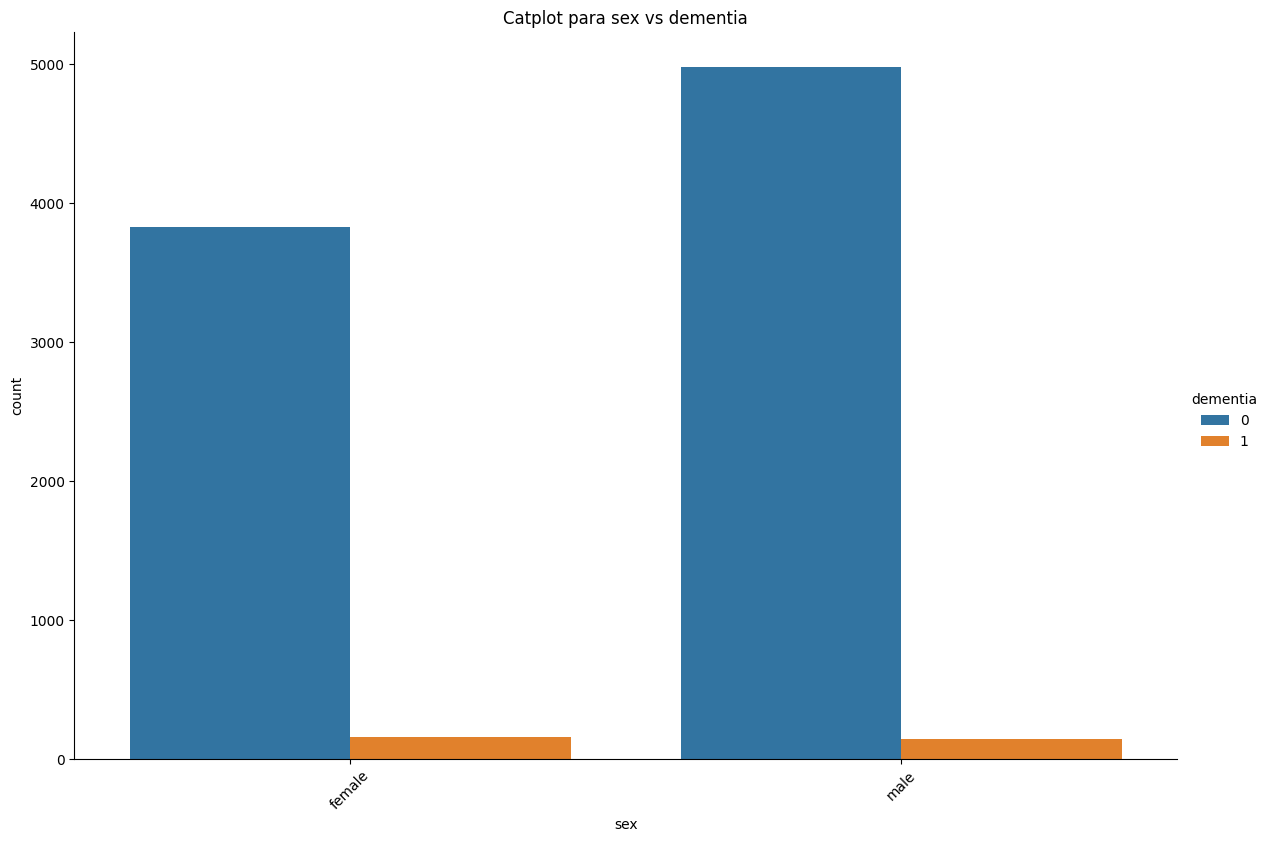

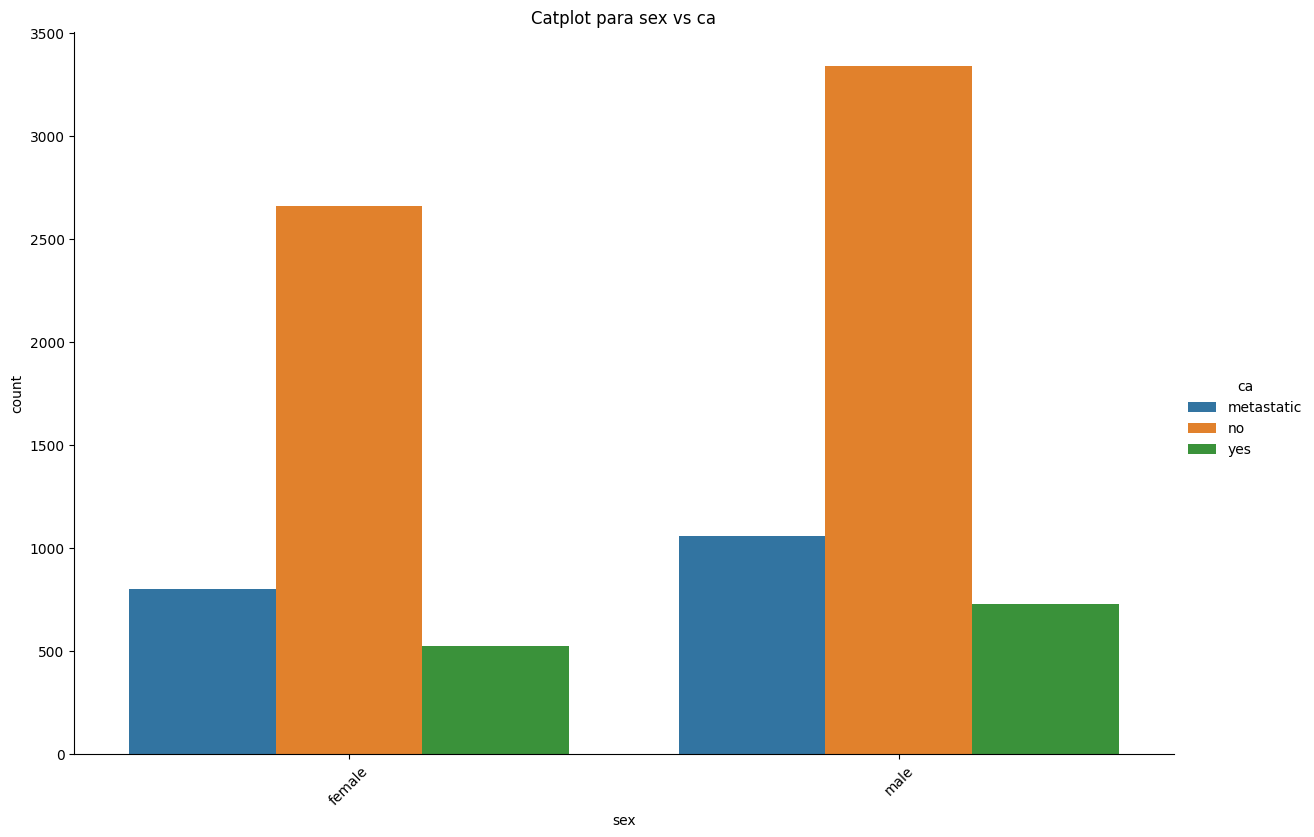

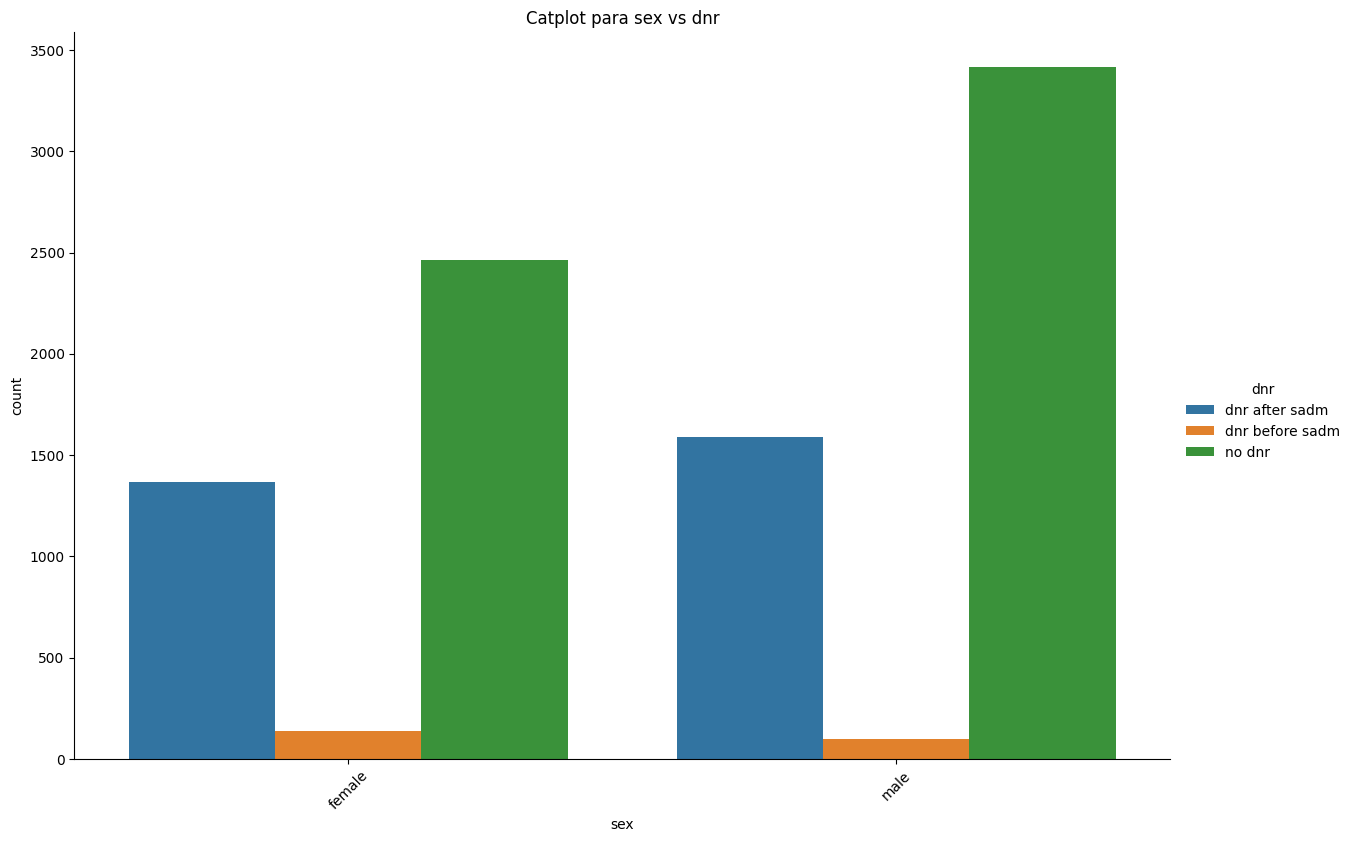

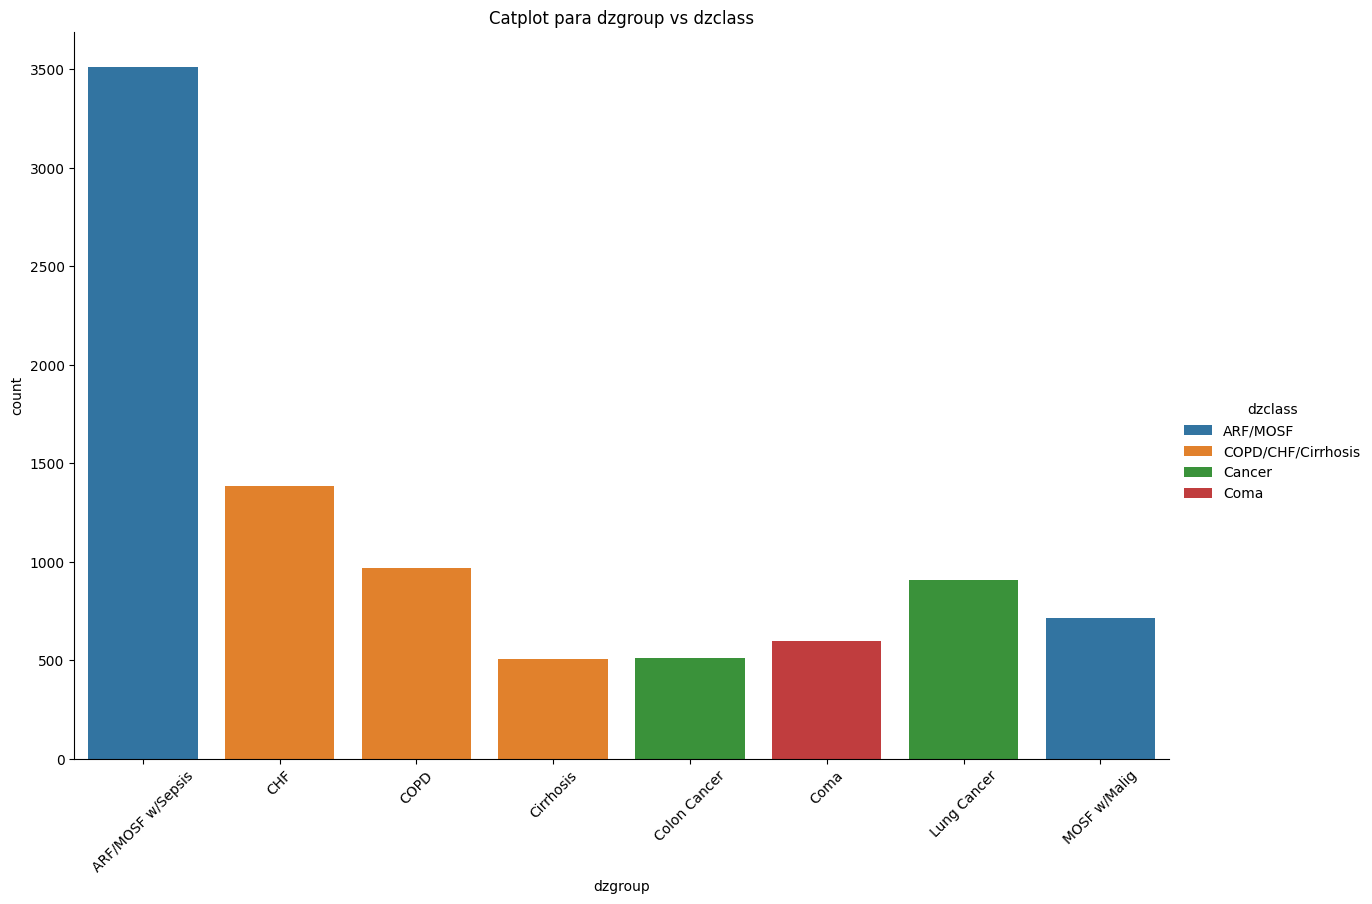

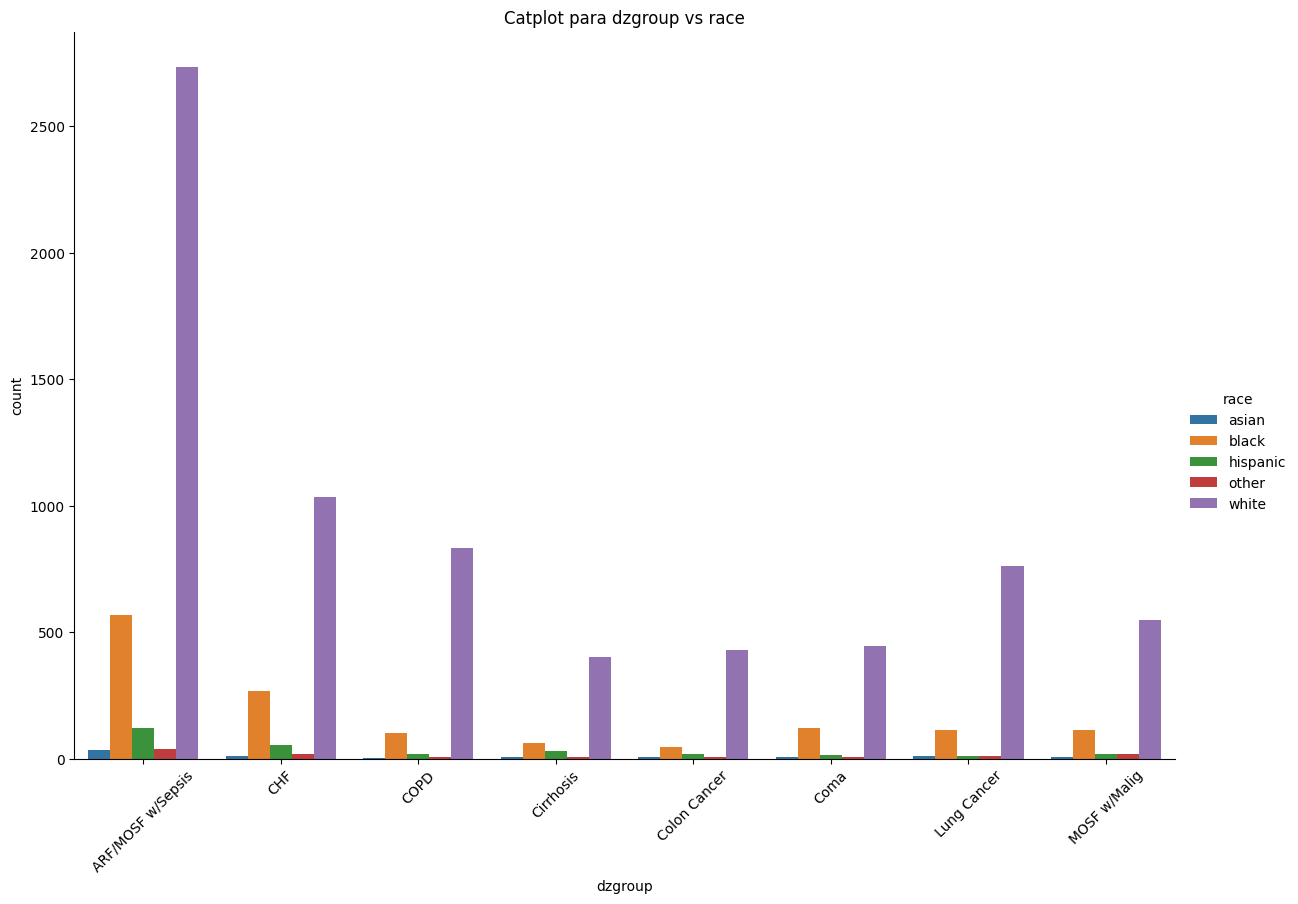

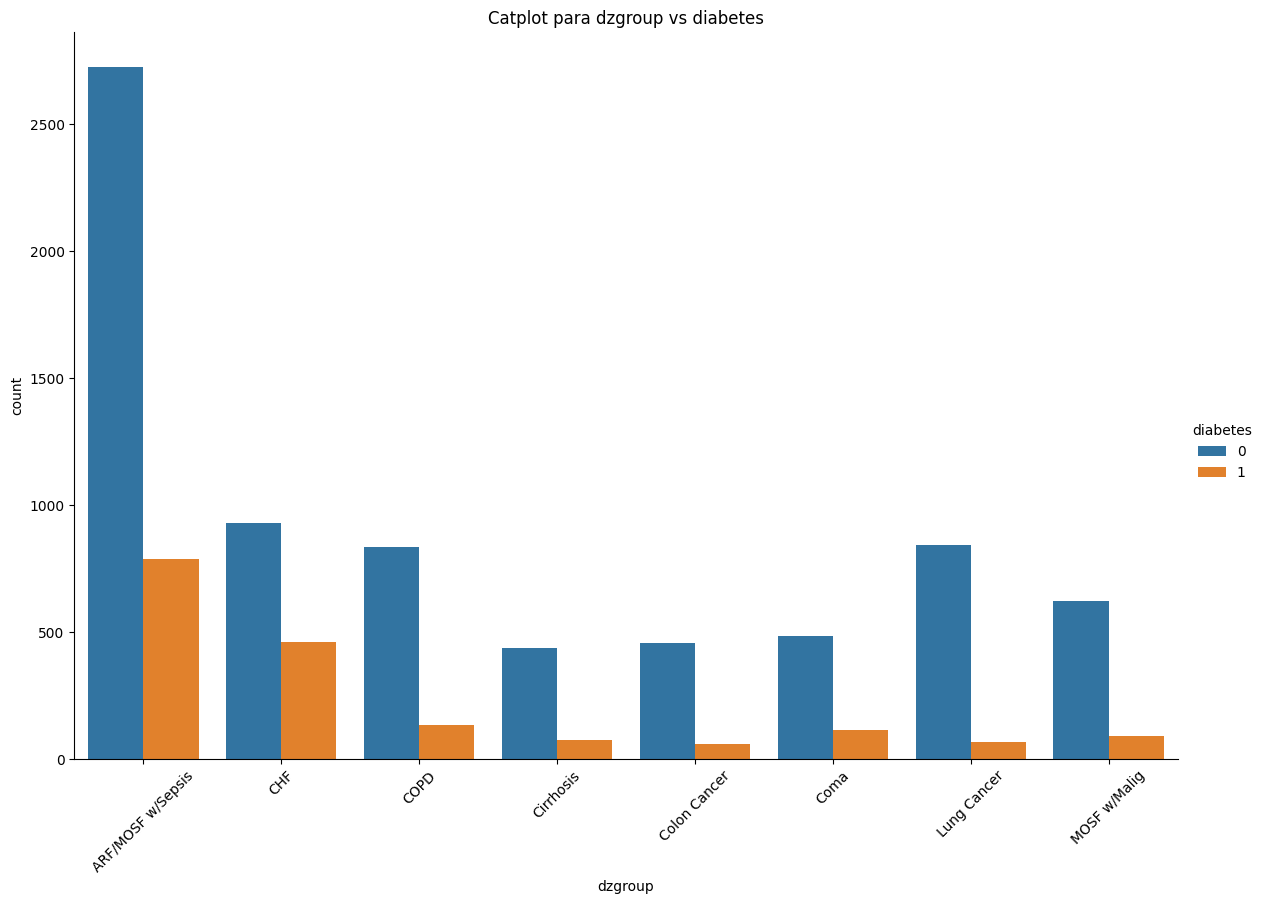

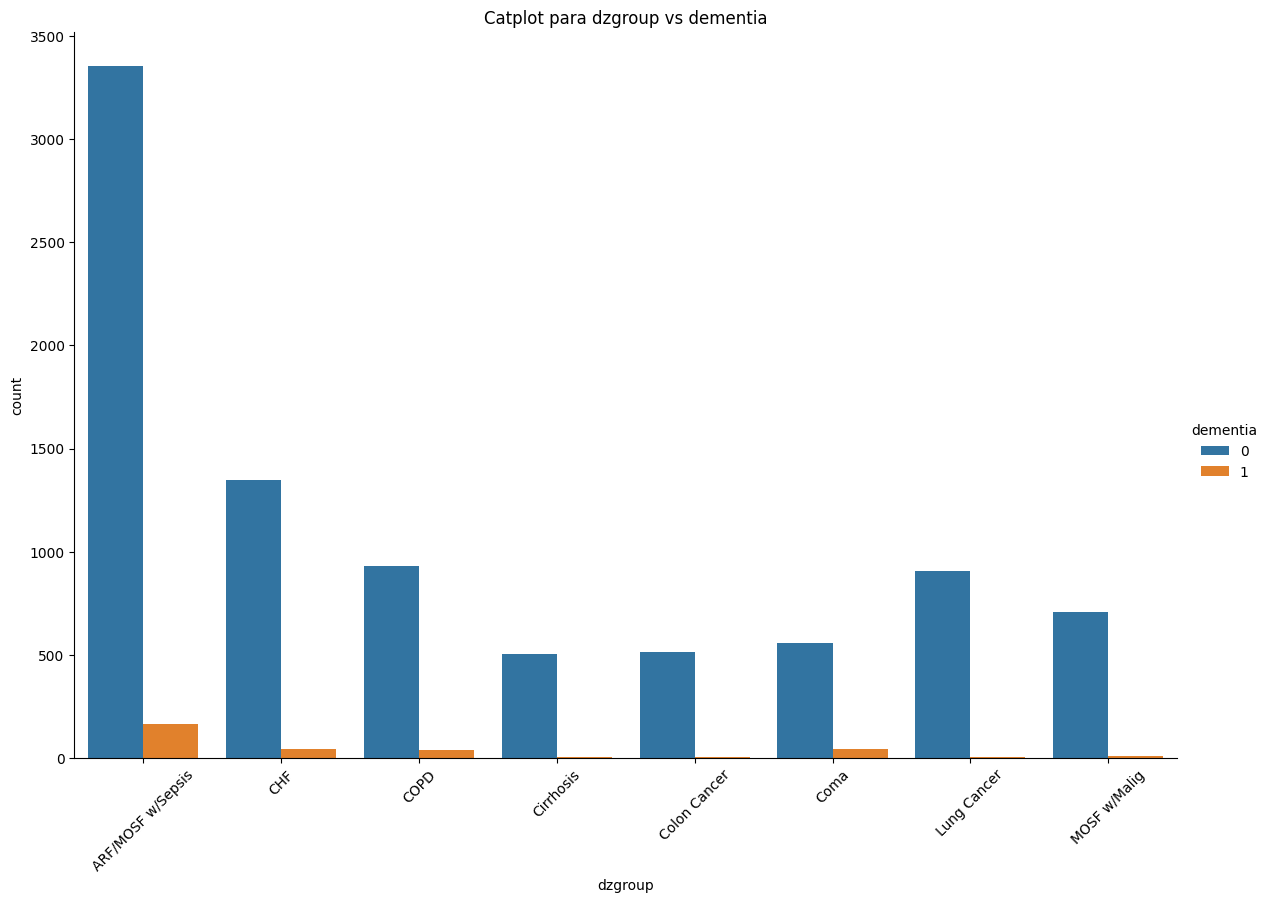

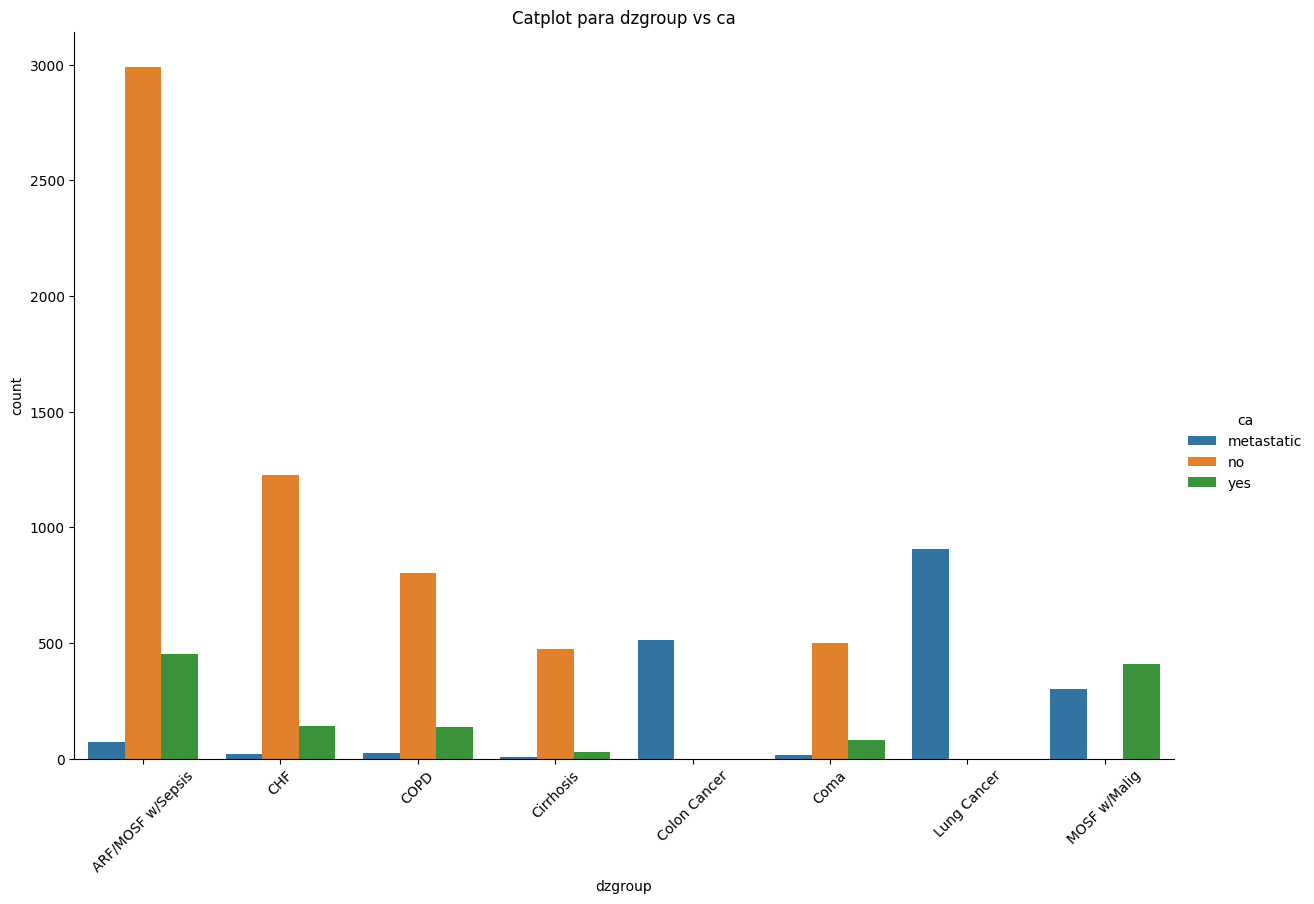

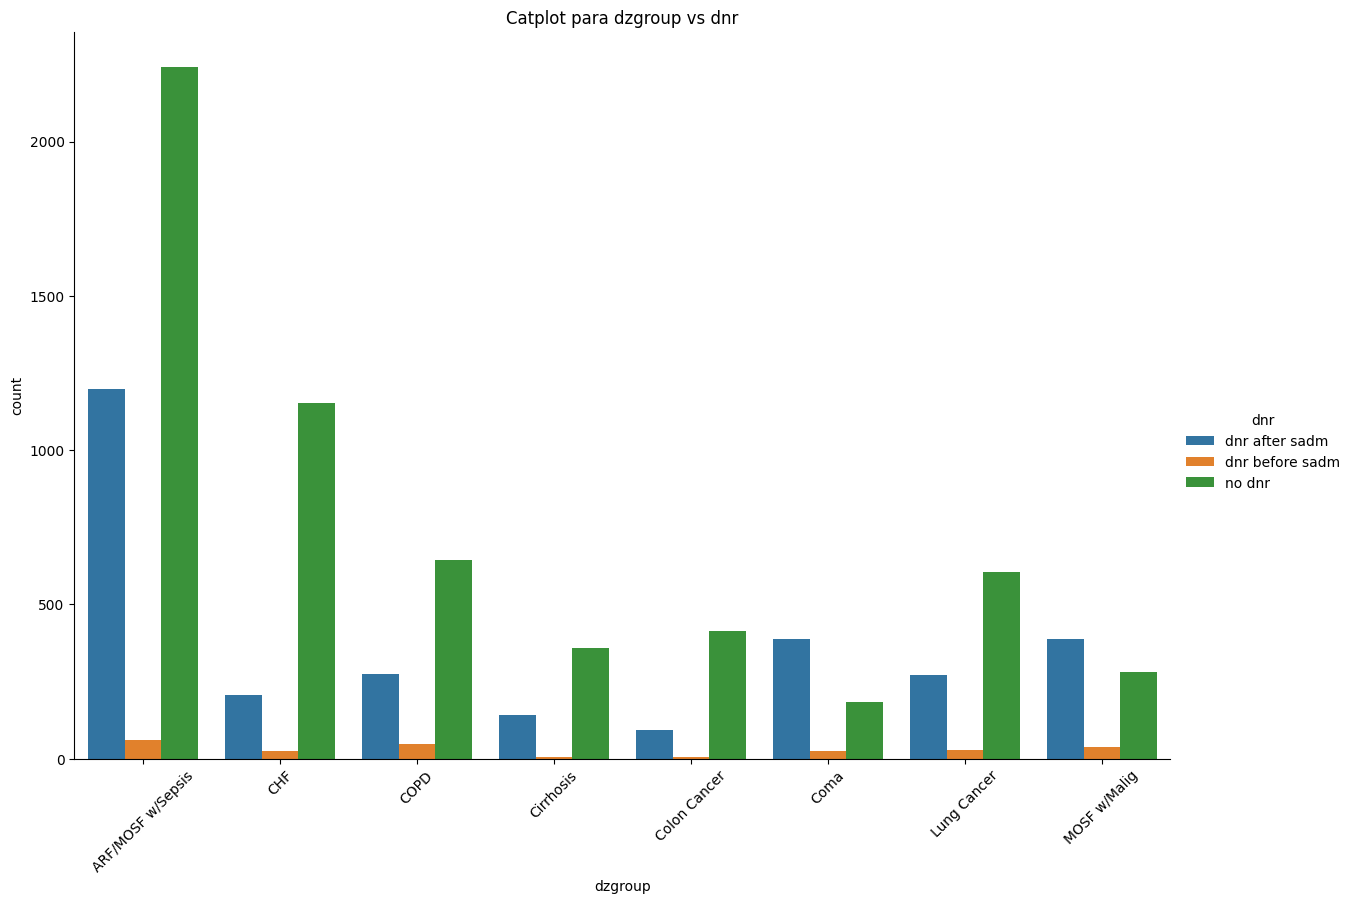

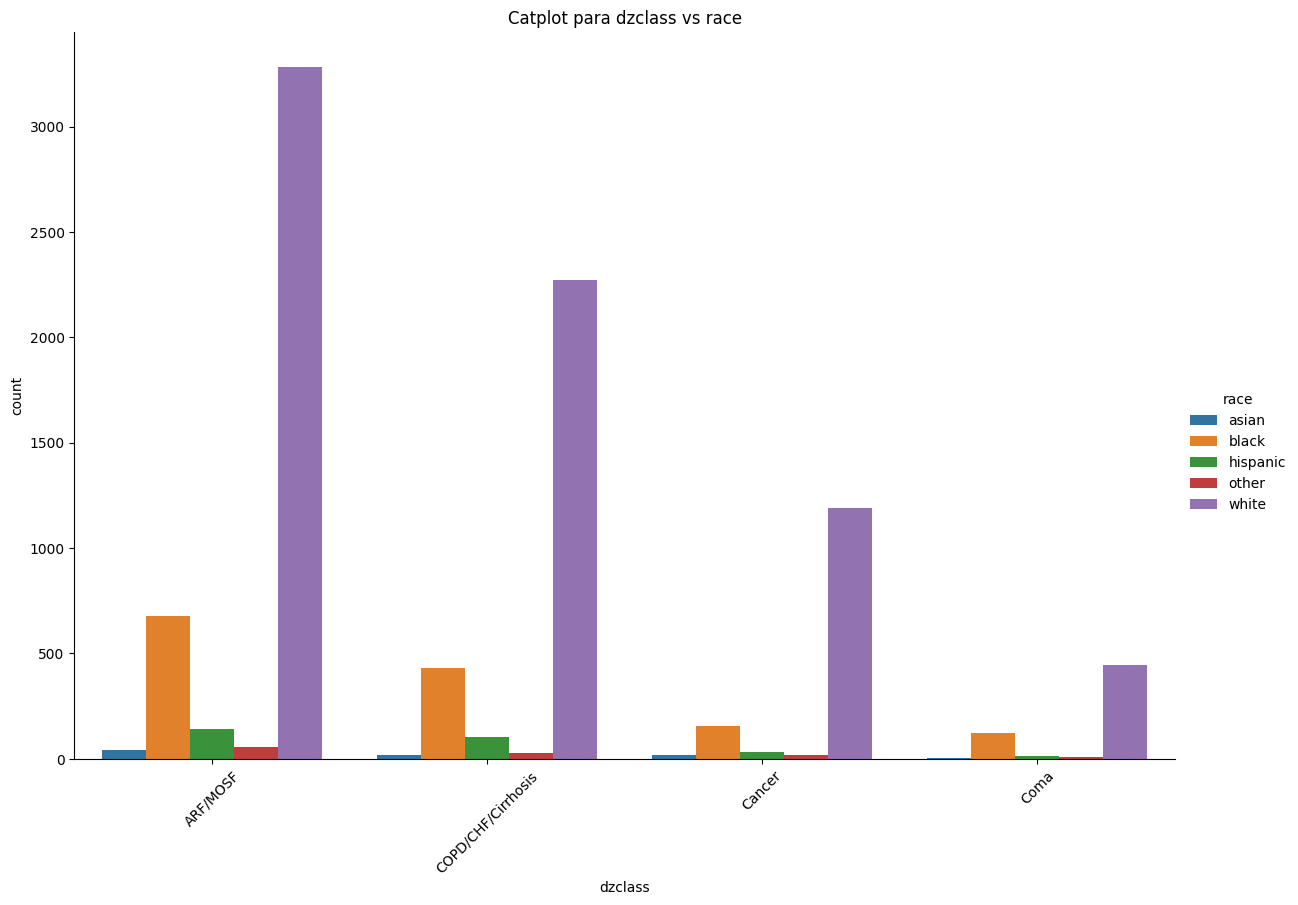

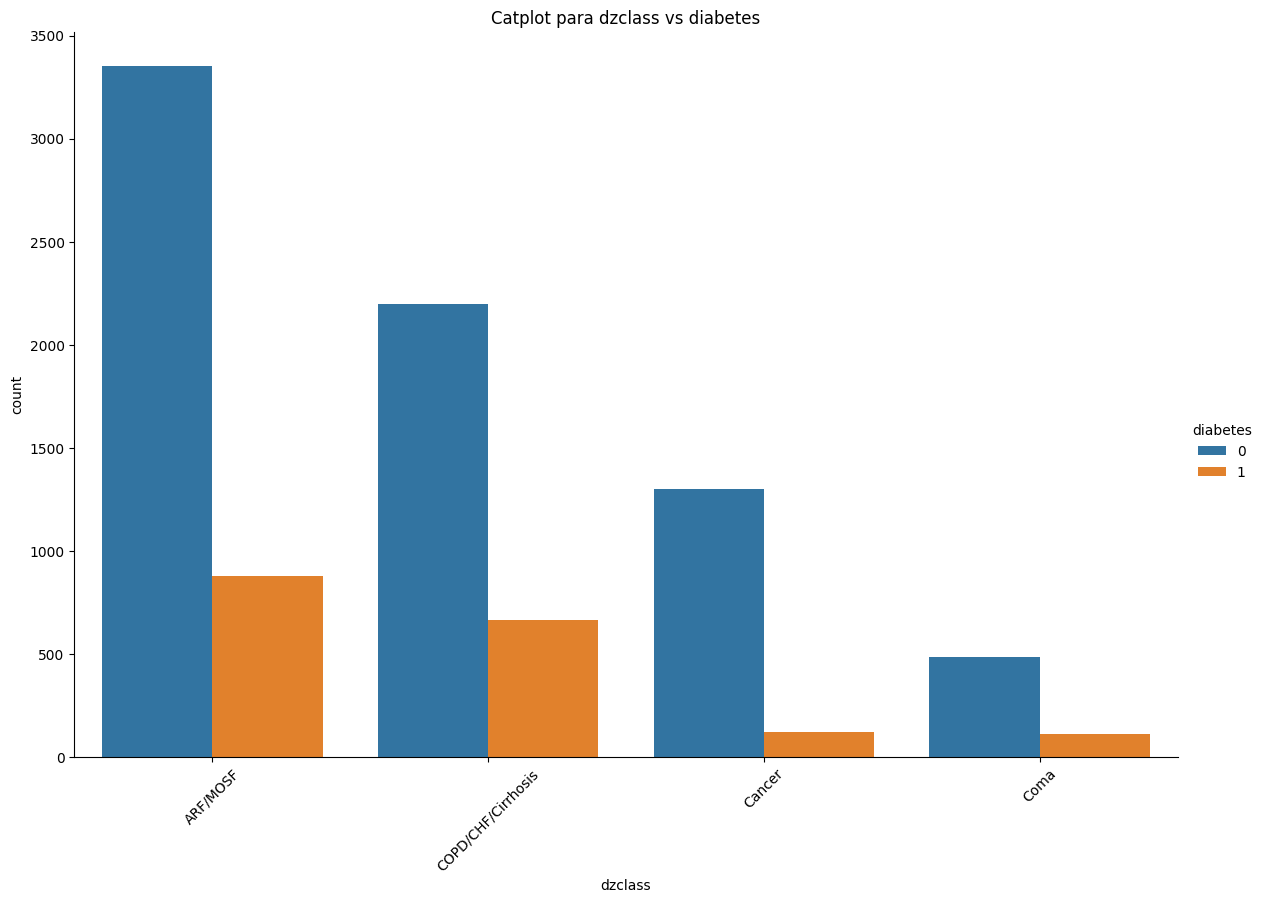

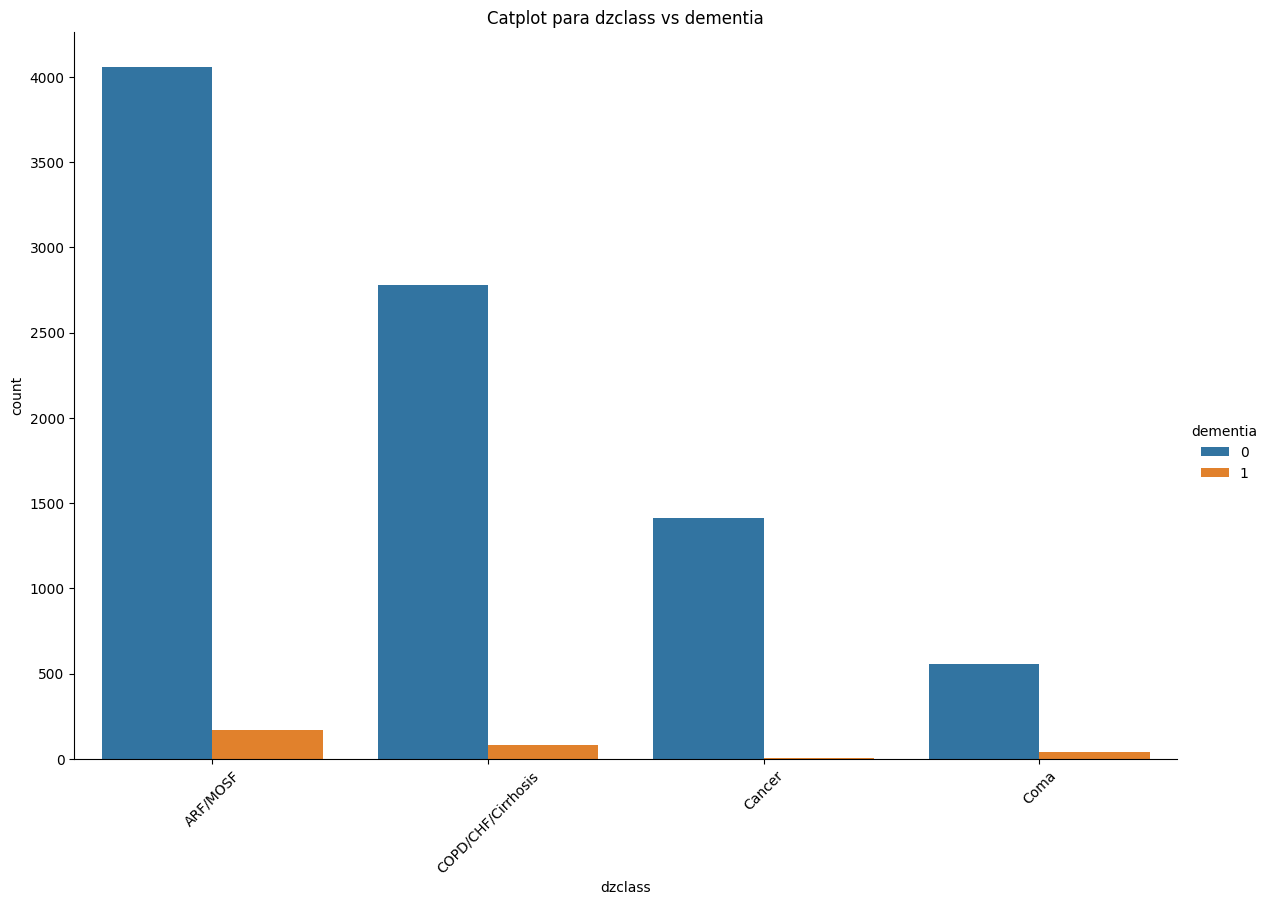

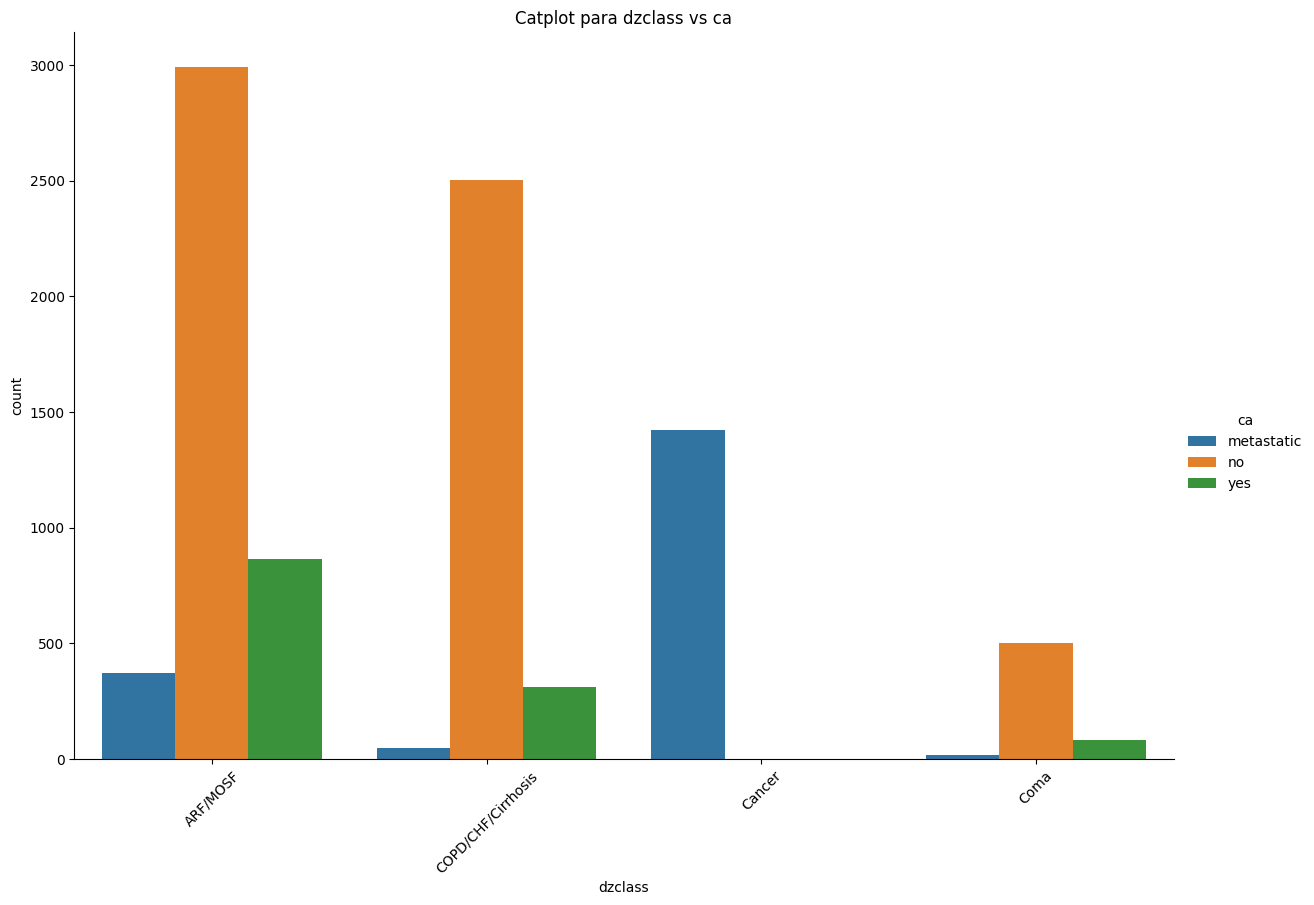

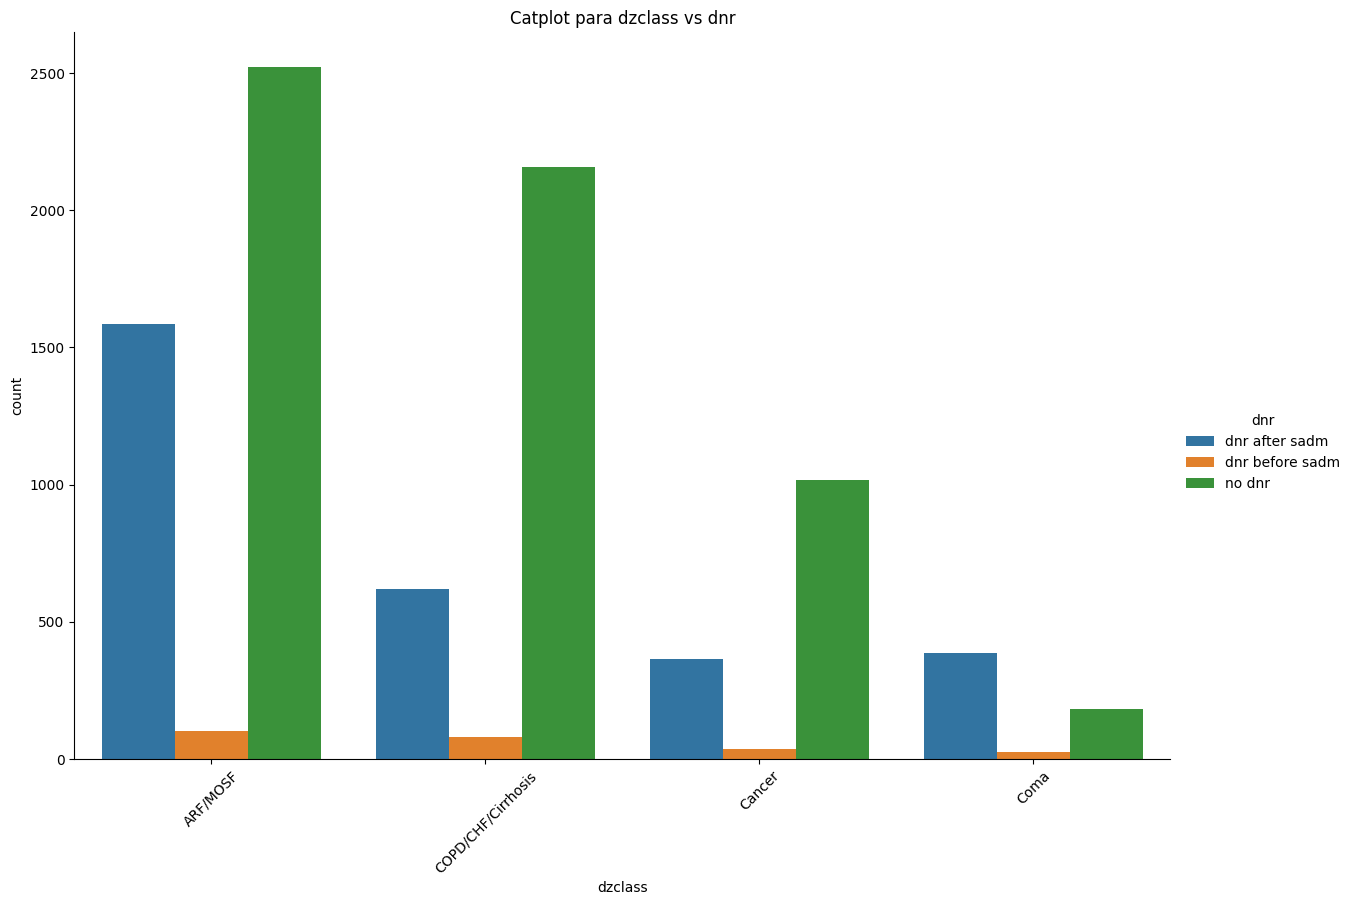

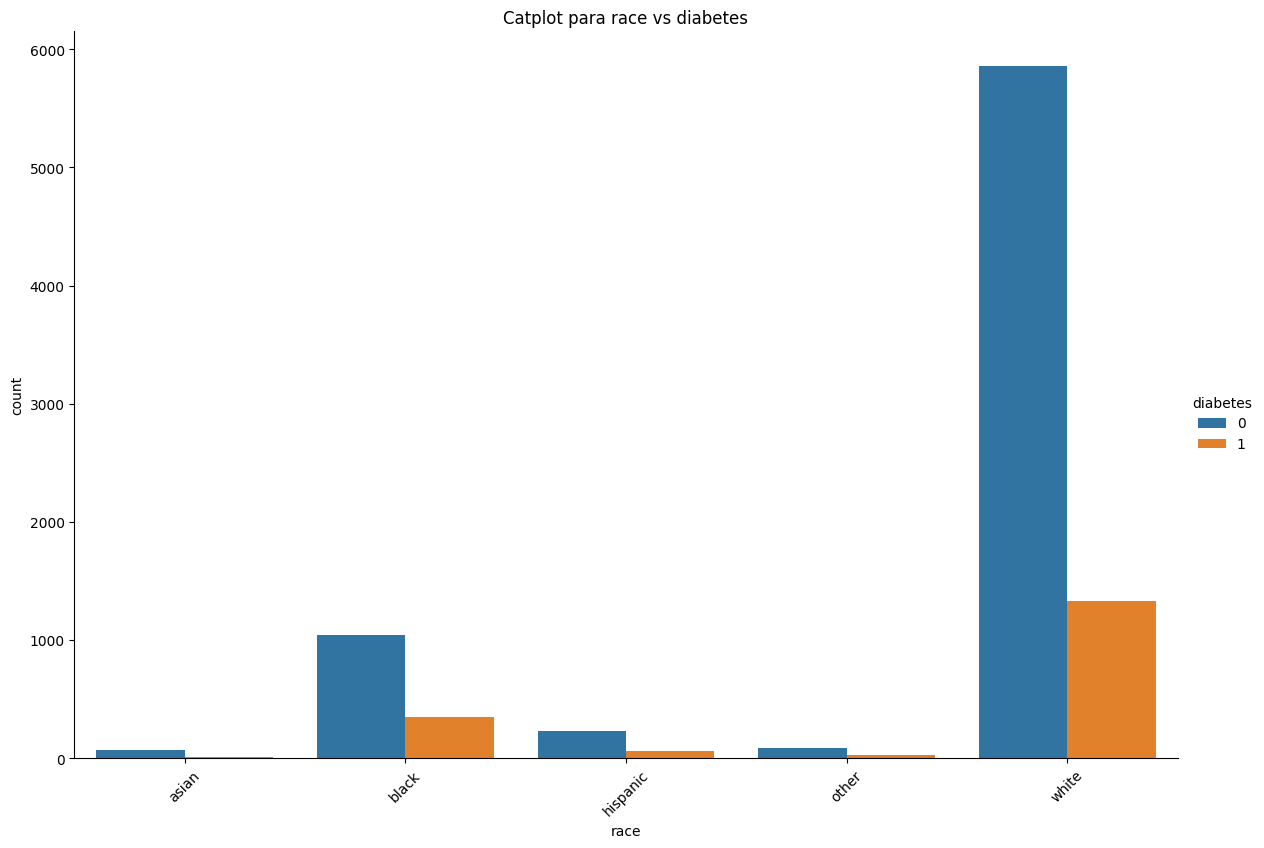

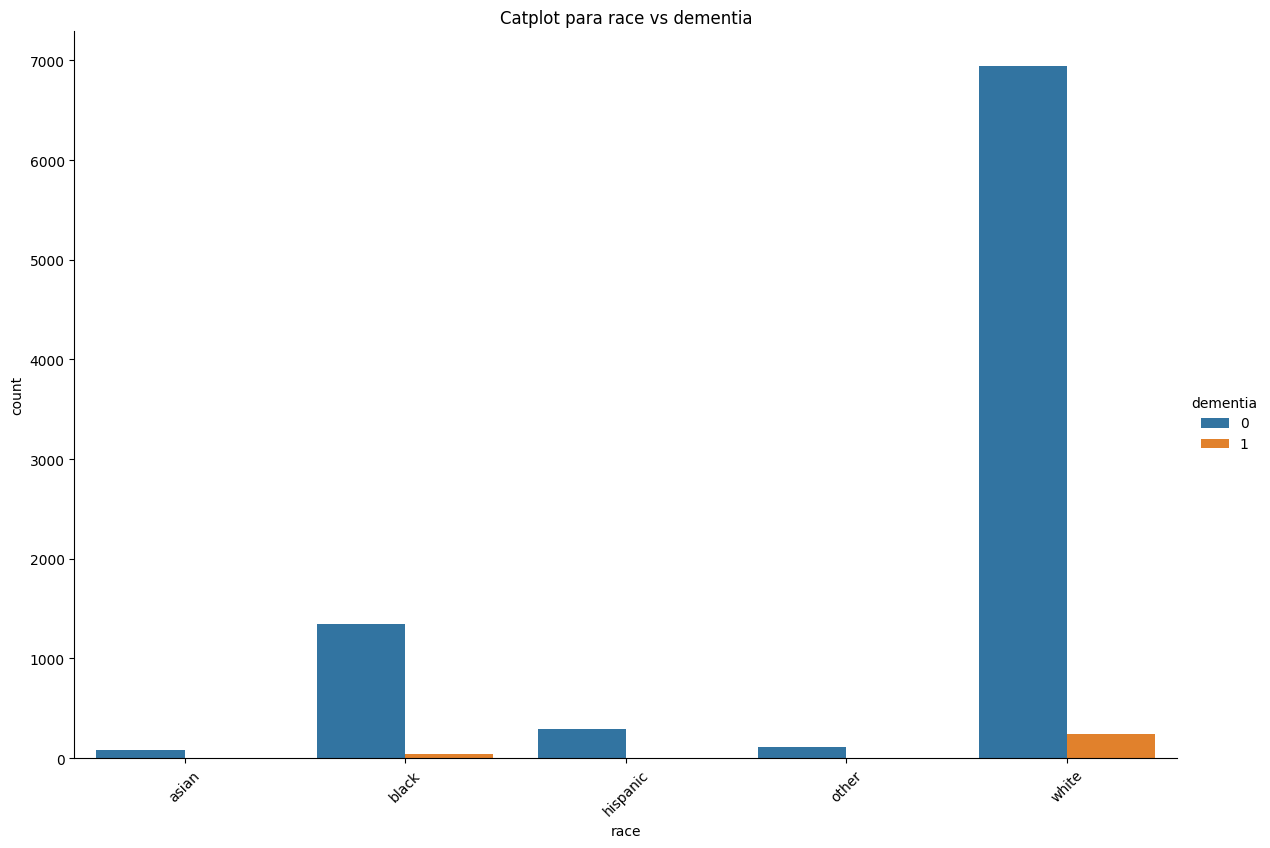

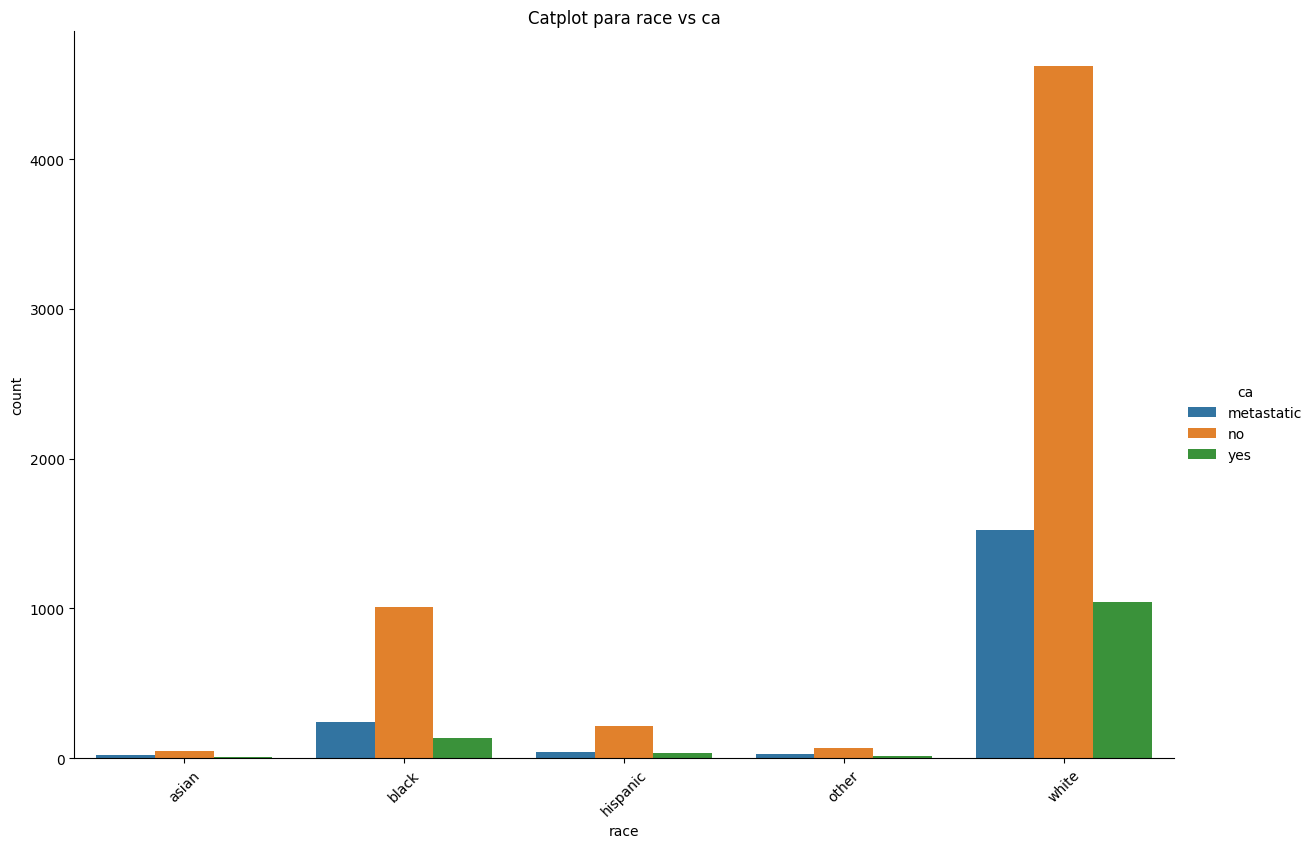

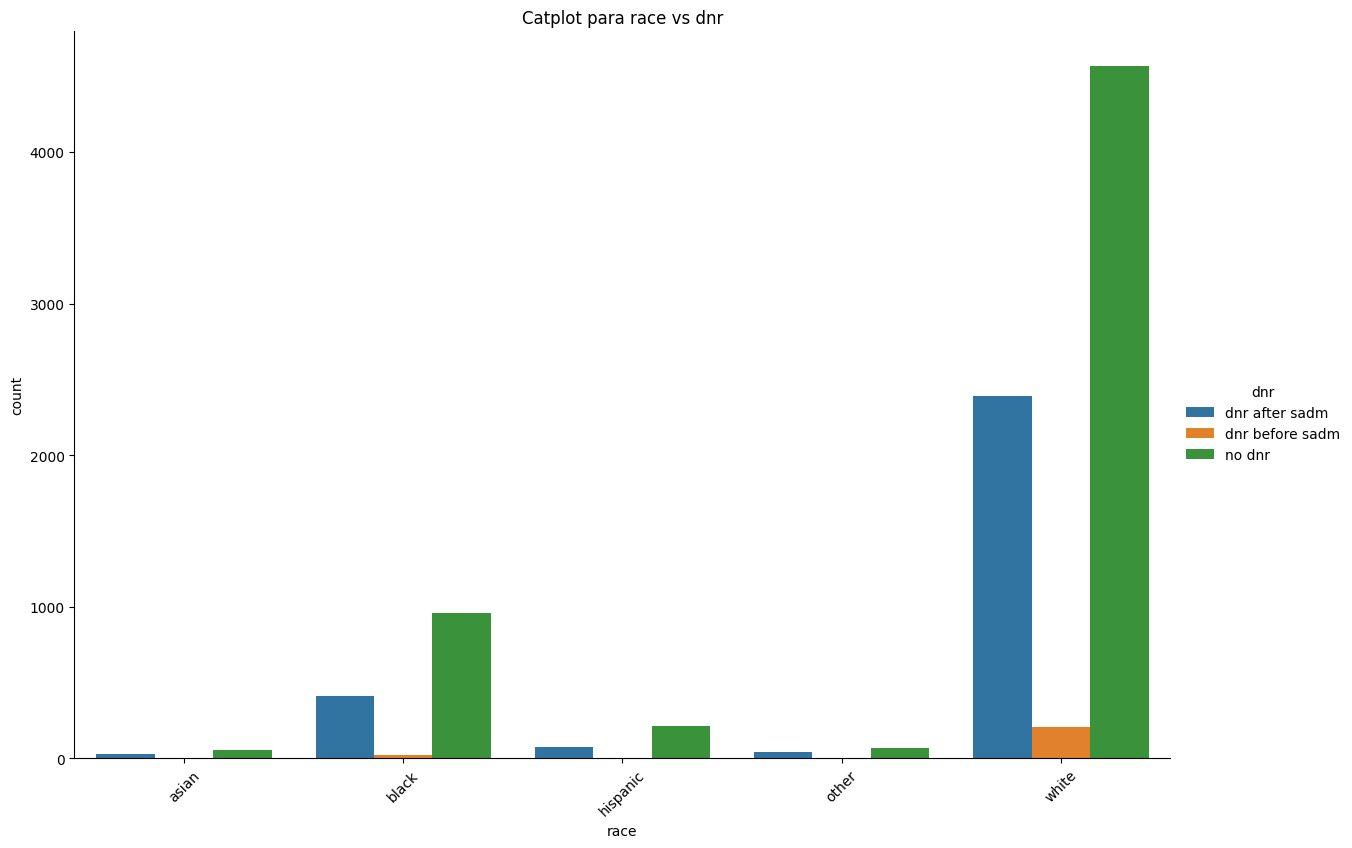

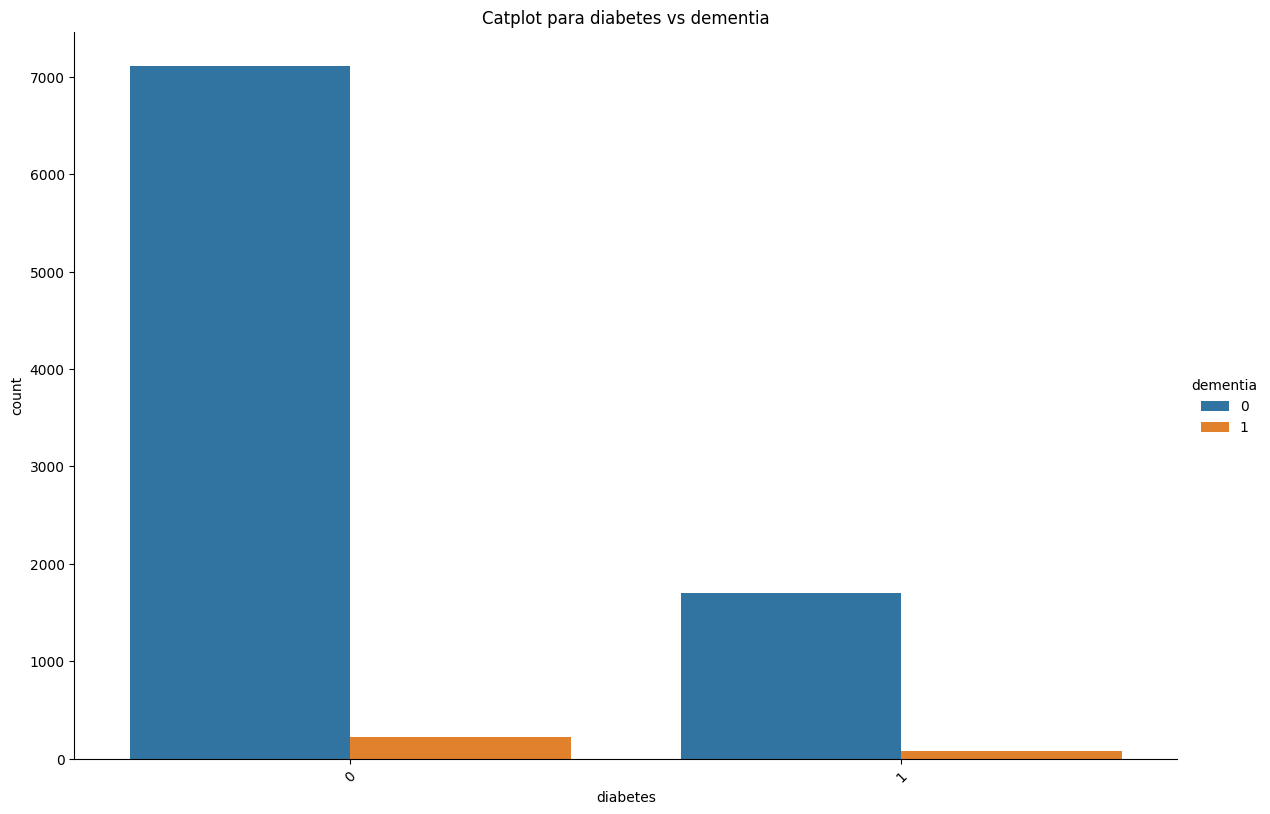

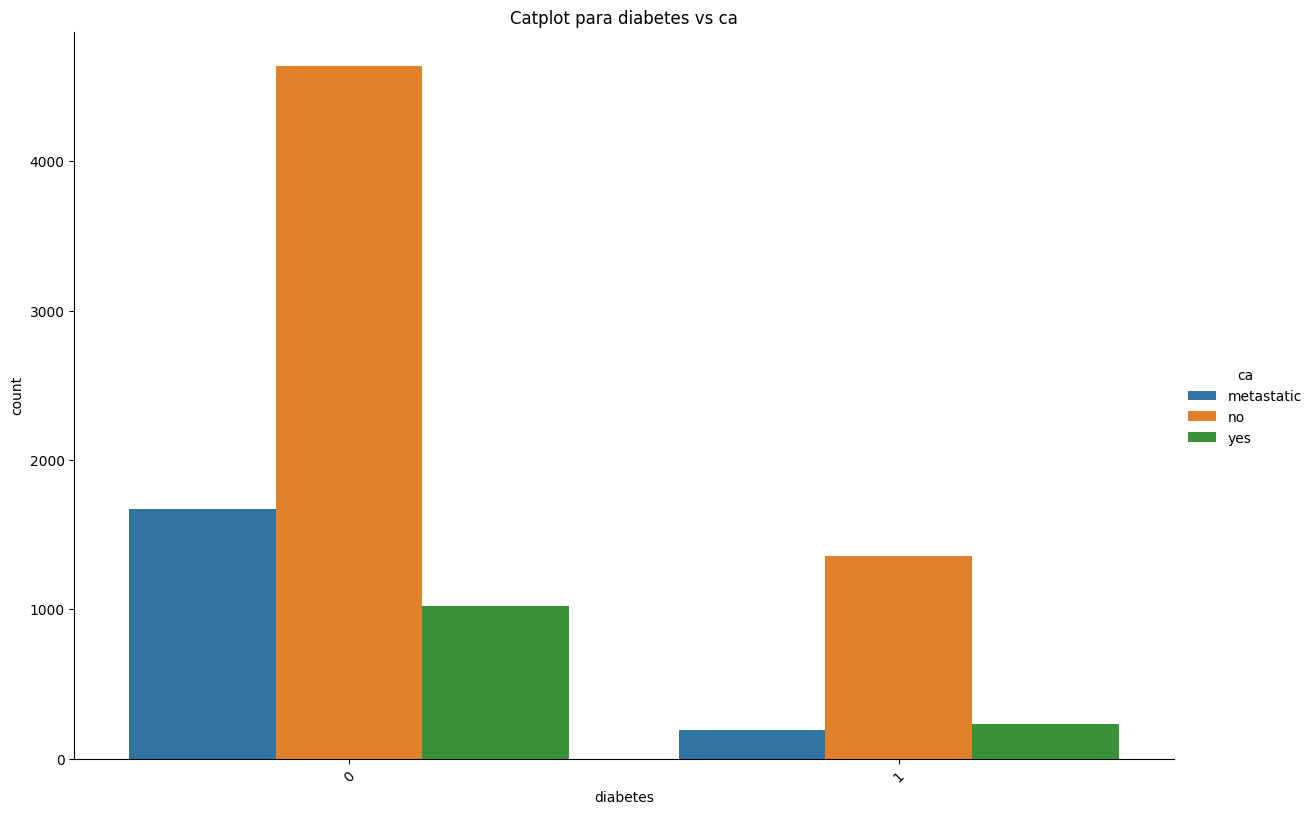

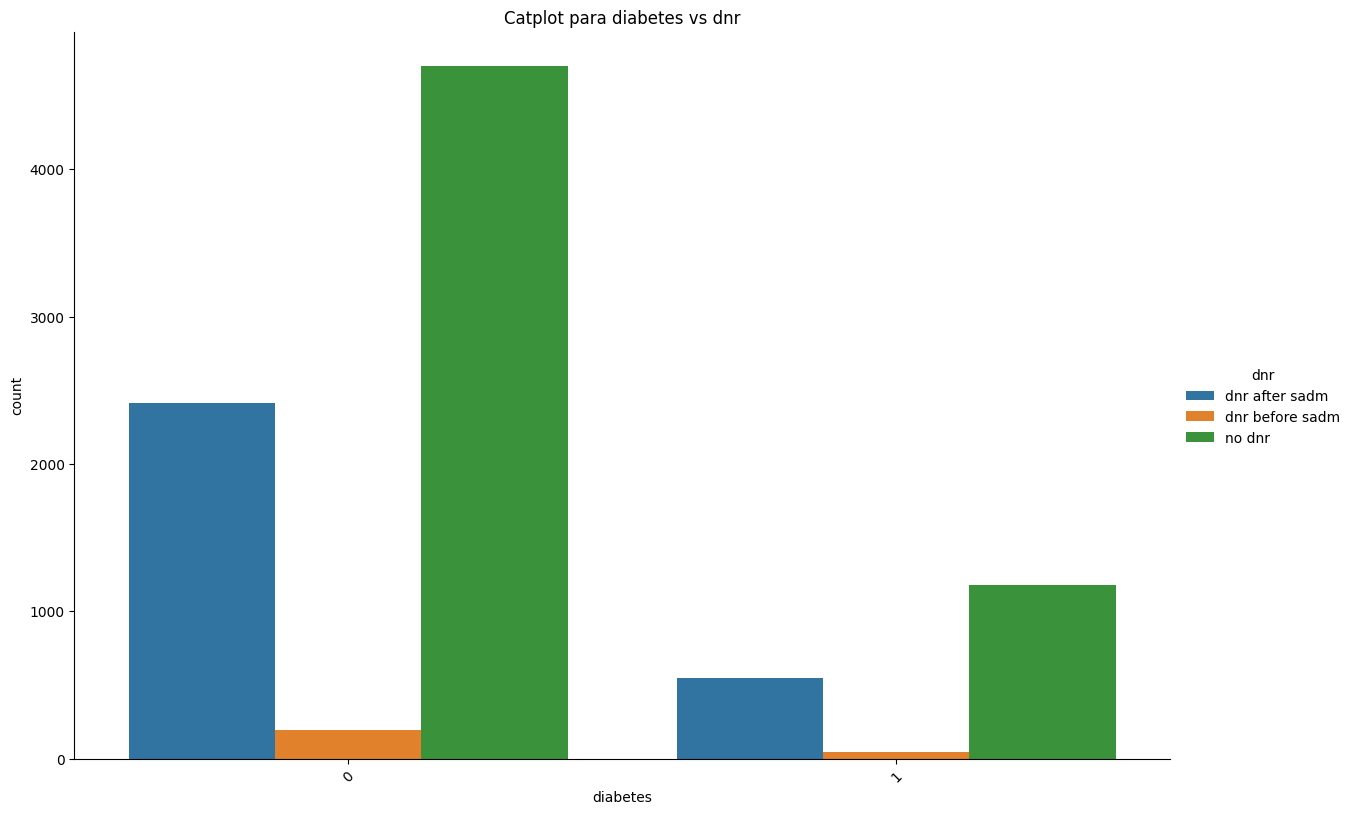

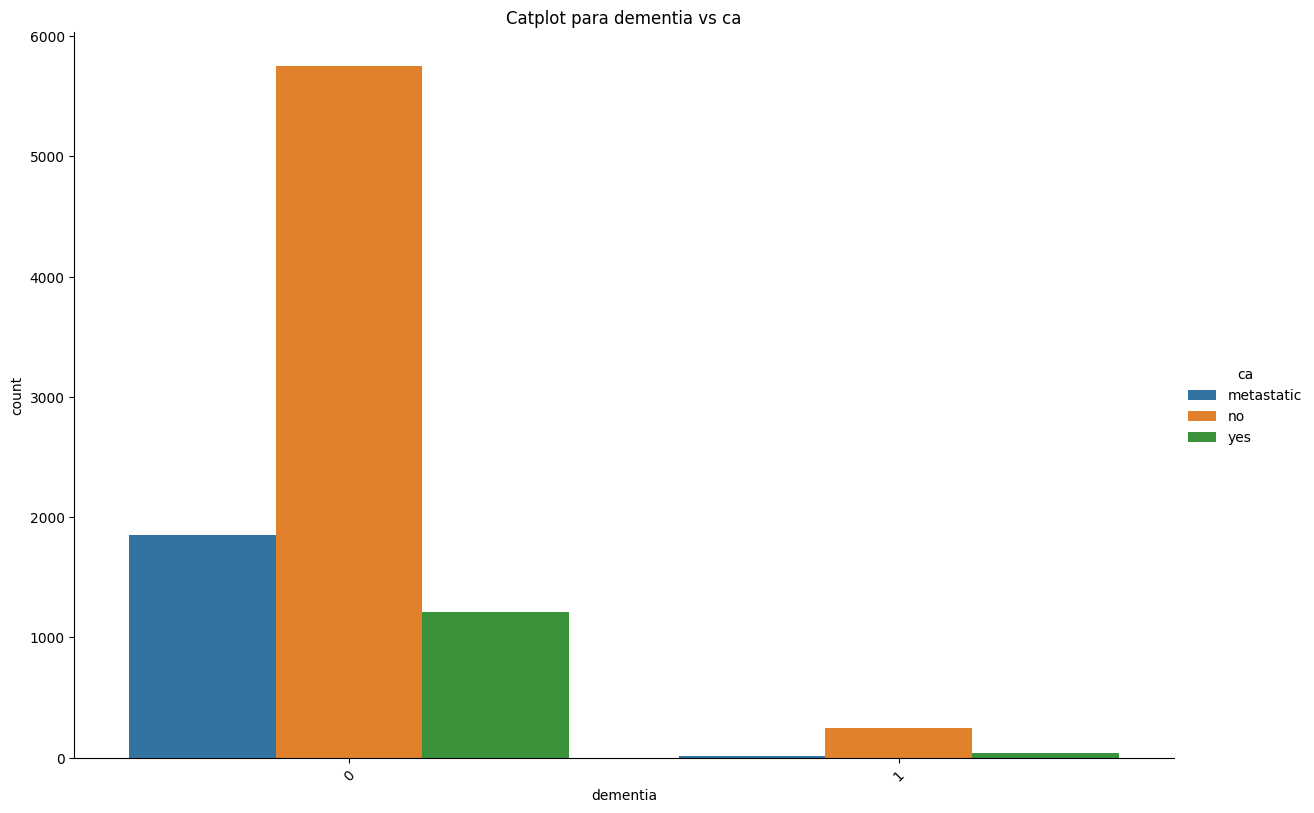

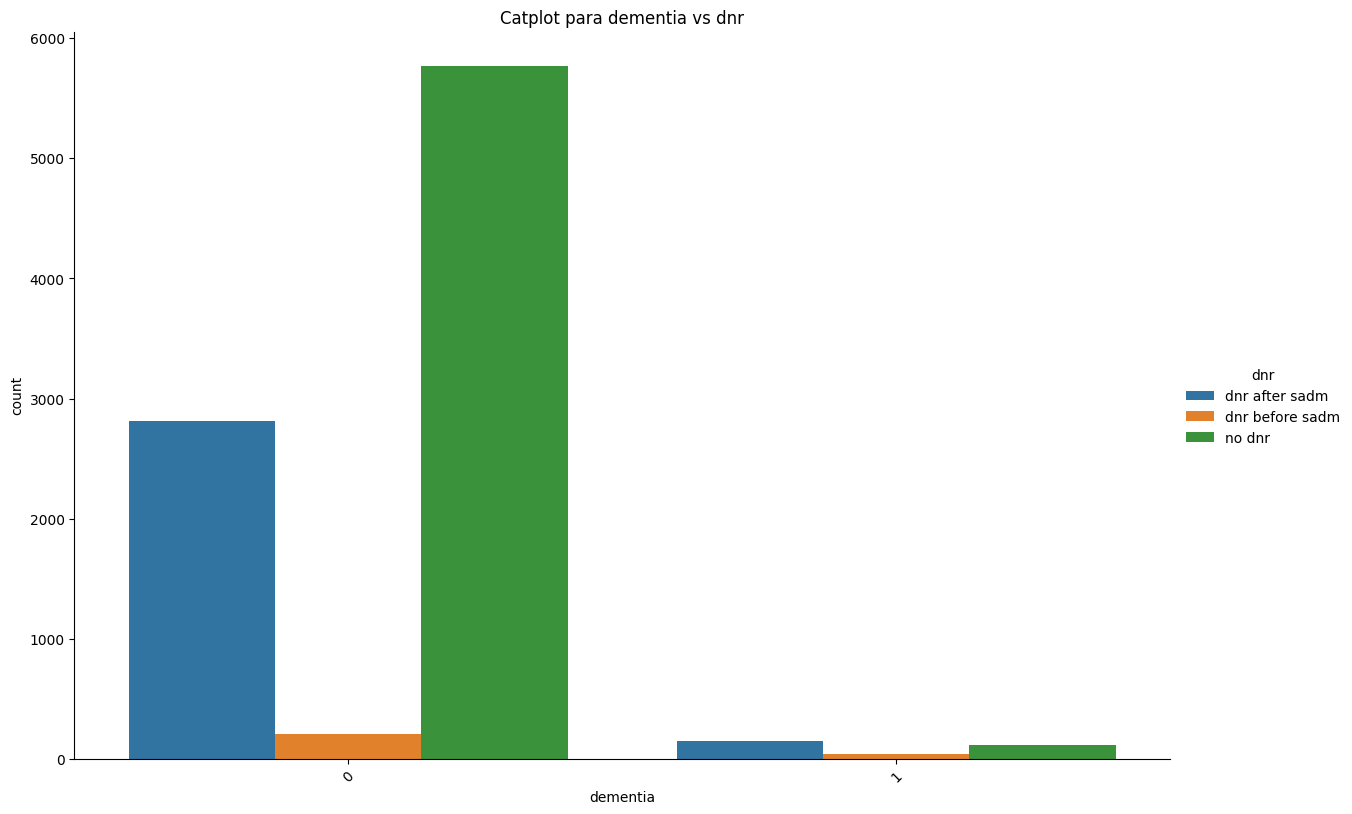

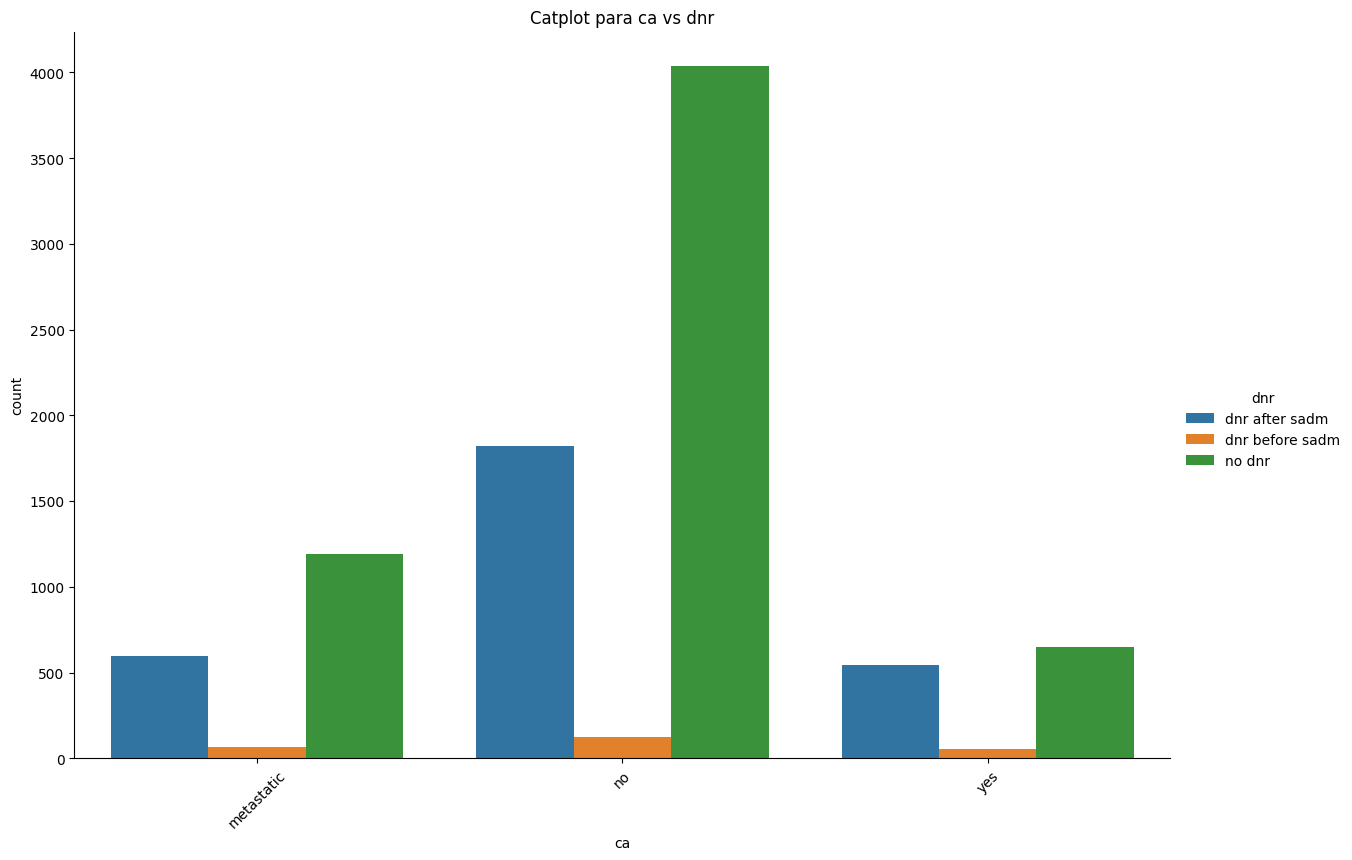

In [35]:
combinations_list = list(combinations(categorical_columns, 2))
plt.figure(figsize=(20,400))
for combination in combinations_list:
    plot = sns.catplot(x=combination[0], hue=combination[1], kind='count', data=data, height=8, aspect=1.5)
    plot.set_xticklabels(rotation=45)
    plt.title(f'Catplot para {combination[0]} vs {combination[1]}')
    plt.show()

Luego de ver gráficamente la interacción entre las variables categóricas, se puede concluir:
- Que el estudio al tener una mayor cantidad de hombres que de mujeres, las proporciones de categorización de enfermedades en hombres será mayor. Pues es lo esperado, y de hecho las porporciones con respecto a las mujeres siguen mas o menos las mismas proporciones, es decir, por ejemplo, en mujeres, la mayor cantidad de enfermedades se agrupan en la categoría ARF/MOSF w/SEPSIS, al igual que en los hombres. Y este es el comportamiento con cada uno de las categorias de enfermedades (dzgroup). No obstante, se ve que por ejemplo los hombres si presentan un mayor cantidad de casos de Cirrhosis por ejemplo.
- Que todos los pacientes con enfermedades categorizadas (dzgroup) en MOSF w/Malig que indica múltiples fallos orgánicos con malignidad pues solo presenta cáncer, esto se puede deber a que el fallo multisistema puede ser originado por cáncer y metastasis a otros organos.
- Que las personas con cancer casi no presentan demencia.
- Que las razas asiática, hispánica y otros no presenta demencia.
- Que personas con demencia tenían cancer en mayor proporción que aquellas sin demencia.
- Que las personas con demencia habían dado con mayor proporción la orden de resucitar frente a los que no tenían demencia (no se dan detalles si la orden es dada por los familiares que toman tutoría de los enfermos con este tipo de enfermedad, dada su limitación cognitiva).

#### CHI2 y TABLA DE CONTINGENCIA PARA LAS VARIABLES CATEGÓRICAS

Ahora se realiza una prueba chi2 entre las variables categóricas (pares) y se grafica una tabla de contingencia para estos pares, esto con el ánimo de ver si existen relaciones entre ambas variables. Para esto se tiene como hipótesis nula H0: Que las vaiables son independientes y por contraste la H1: Las variables estan relacionadas. Se uso como umbral de p-value 0.05. Valores de p valor menor al umbral rechazarán la hipótesis nula.

In [36]:
for i in range(len(categorical_columns)):
    for j in range(i + 1, len(categorical_columns)):
        var1 = categorical_columns[i]
        var2 = categorical_columns[j]
        
       
        tabla_contingencia = pd.crosstab(data[var1], data[var2])
        
       
        chi2, p, dof, expected = chi2_contingency(tabla_contingencia)
        
        print(f"\nVariables categóricas: {var1} y {var2}")
        print(f"Tabla de Contingencia entre {var1} y {var2}:")
        print(tabla_contingencia)
        print(f"Chi-cuadrado: {chi2}, p-valor: {p}")
        
        if p < 0.05:
            print(f"Las variables '{var1}' y '{var2}' tienen una relación significativa.\n")
        else:
            print(f"No hay una relación significativa entre '{var1}' y '{var2}'.\n")



Variables categóricas: sex y dzgroup
Tabla de Contingencia entre sex y dzgroup:
dzgroup  ARF/MOSF w/Sepsis  CHF  COPD  Cirrhosis  Colon Cancer  Coma  \
sex                                                                    
female                1591  528   476        184           223   311   
male                  1924  859   491        324           289   285   

dzgroup  Lung Cancer  MOSF w/Malig  
sex                                 
female           339           328  
male             569           384  
Chi-cuadrado: 78.91900497985822, p-valor: 2.2878742233029138e-14
Las variables 'sex' y 'dzgroup' tienen una relación significativa.


Variables categóricas: sex y dzclass
Tabla de Contingencia entre sex y dzclass:
dzclass  ARF/MOSF  COPD/CHF/Cirrhosis  Cancer  Coma
sex                                                
female       1919                1188     562   311
male         2308                1674     858   285
Chi-cuadrado: 37.77036086696117, p-valor: 3.161250653550081e

Es resultado de esta prueba nos indica que todas las variables categóricas tienen relación entre si.
Notese como por ejemplo en la comparación entre las variables categóricas dzgroup y dzclass, el valor del chi2 es el más alto, además de presentar un p value de cero. Indicandonos que la relación entre ambas es muy fuerte. Esto debido a que una es parte de la otra.
Se puede ahora realizar la misma prueba pero entre las variables categóricas y la variable objetivo para ver si existe relación entre estas.

#### CHI2 Y TABLA DE CONTIGENCIA DE LAS VARIABLES CATEGÓRICAS FRENTE A LA VARIABLE OBJETIVO.

En esta prueba chi2 se evalua si existe una relación significativa estadísticamente entre las variables categórcias y la variable objetivo. 

La hippótesis nula H0: No existe relación significativa entre la variable categórica y la variable objetivo vs H1: Si existe dicha relación significativa. 

El umbral utilizado de p-value es de 0.05. Valores obtenidos de p-value menores al umbral rechazarán la H0.

In [37]:
for column in categorical_columns:

    tabla_contingencia = pd.crosstab(data[column], data['hospdead'])

    chi2, p, dof, expected = chi2_contingency(tabla_contingencia)
    
    print(f"\nVariable categórica: {column}")
    print("Tabla de Contingencia:")
    print(tabla_contingencia)
    print(f"Chi-cuadrado: {chi2}, p-valor: {p}")
    
    if p < 0.05:
        print(f"La variable '{column}' tiene una relación significativa con 'hospdead'.")
    else:
        print(f"La variable '{column}' NO tiene una relación significativa con 'hospdead'.")


Variable categórica: sex
Tabla de Contingencia:
hospdead     0     1
sex                 
female    2925  1055
male      3820  1305
Chi-cuadrado: 1.218142941778959, p-valor: 0.269725408539919
La variable 'sex' NO tiene una relación significativa con 'hospdead'.

Variable categórica: dzgroup
Tabla de Contingencia:
hospdead              0     1
dzgroup                      
ARF/MOSF w/Sepsis  2331  1184
CHF                1300    87
COPD                864   103
Cirrhosis           390   118
Colon Cancer        483    29
Coma                234   362
Lung Cancer         806   102
MOSF w/Malig        337   375
Chi-cuadrado: 1361.517019305006, p-valor: 8.181590003847858e-290
La variable 'dzgroup' tiene una relación significativa con 'hospdead'.

Variable categórica: dzclass
Tabla de Contingencia:
hospdead               0     1
dzclass                       
ARF/MOSF            2668  1559
COPD/CHF/Cirrhosis  2554   308
Cancer              1289   131
Coma                 234   362
Chi-cuadr

Luego de ejecutar la prueba de chi2 de cada variable categórica frente a la variable objetivo, según esta prueba, casi todas las variables tienen una relación significativa contra la variable objetivo, salvo las variables sex y diabetes.

#### TASA DE CONVERSIÓN

Como se pudo observar, algunas de las variables categóricas guardan una relación significativa con la varaible categórica, pero en que medida? una manera de aproximarse a esto es usando la tasa de conversión, la cual toma el promedio de la varaible objetiva, que al ser binaria, nos indicará la proporción de casos con etiqueta 1 (es decir, la proporción de casos de pacientes que murieron) y se relacionará contra cada variable categórica, en otras palabras podremos ver las proporciones de personas que murieron por cada categoría de las variables categóricas. Con esto haremos un zoom al análisis gráfico ya realizado de la distribución de las variables categórcias frente a la variable objetivo, además que nos dejará ver en proporción a cuanto asciende el número de muertos por categoría.


Tasa de Conversión para la variable 'sex':
  Categoria  Tasa de Conversión
0    female            0.265075
1      male            0.254634


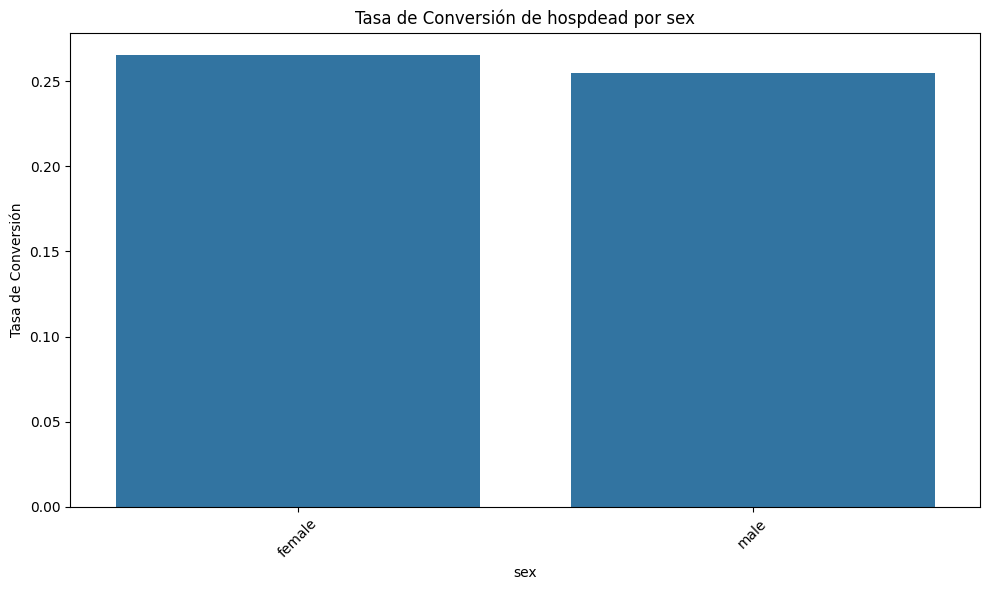


Tasa de Conversión para la variable 'dzgroup':
           Categoria  Tasa de Conversión
0  ARF/MOSF w/Sepsis            0.336842
1                CHF            0.062725
2               COPD            0.106515
3          Cirrhosis            0.232283
4       Colon Cancer            0.056641
5               Coma            0.607383
6        Lung Cancer            0.112335
7       MOSF w/Malig            0.526685


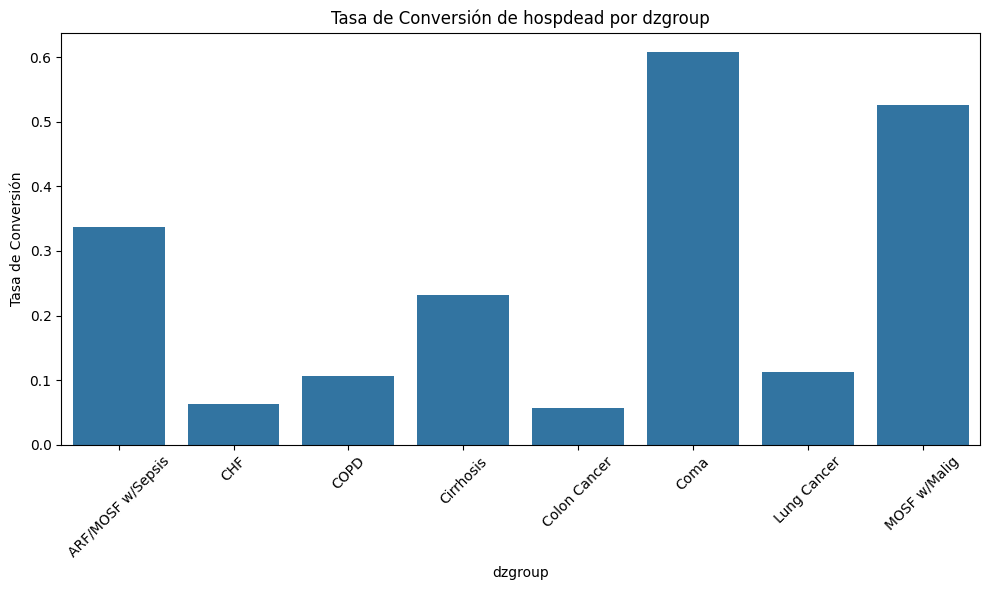


Tasa de Conversión para la variable 'dzclass':
            Categoria  Tasa de Conversión
0            ARF/MOSF            0.368819
1  COPD/CHF/Cirrhosis            0.107617
2              Cancer            0.092254
3                Coma            0.607383


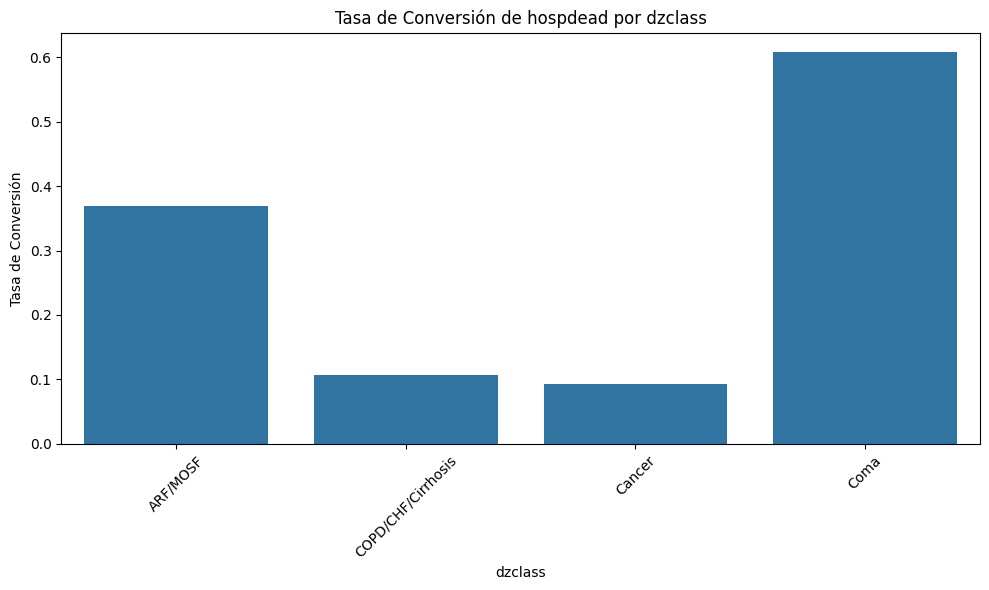


Tasa de Conversión para la variable 'race':
  Categoria  Tasa de Conversión
0     asian            0.379747
1     black            0.275341
2  hispanic            0.234483
3     other            0.330357
4     white            0.253511


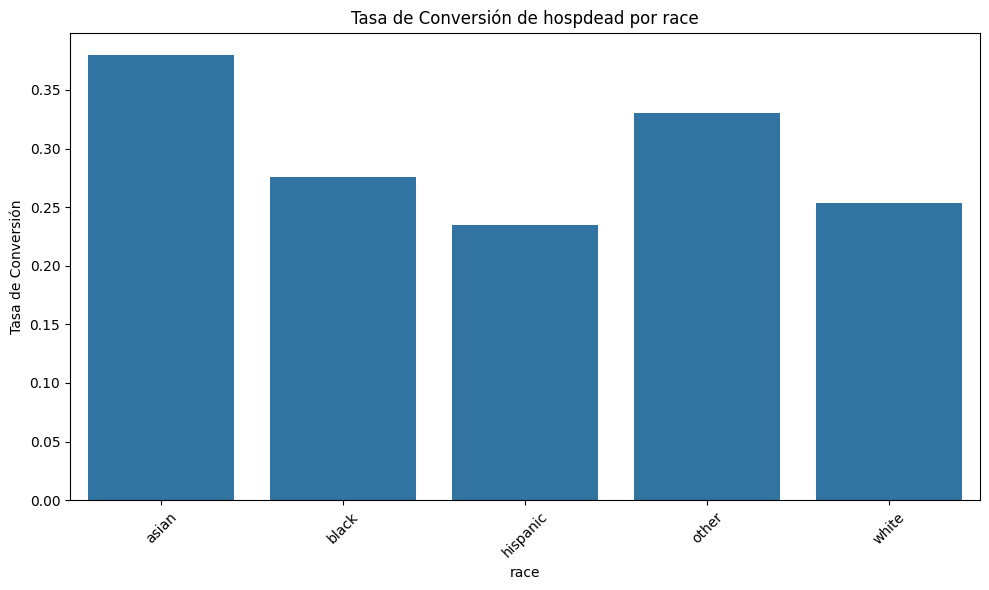


Tasa de Conversión para la variable 'diabetes':
  Categoria  Tasa de Conversión
0         0            0.262044
1         1            0.247469


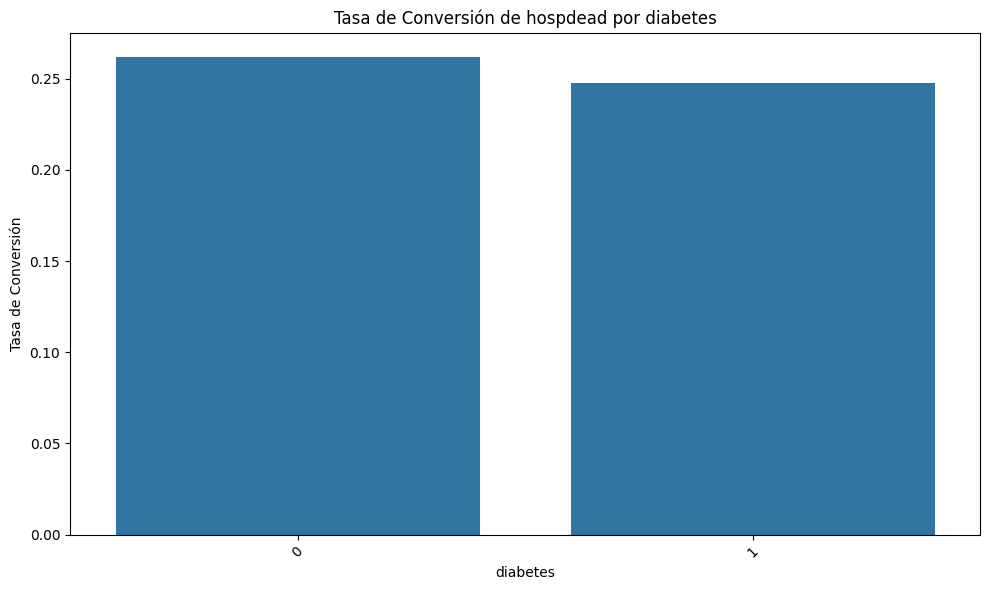


Tasa de Conversión para la variable 'dementia':
  Categoria  Tasa de Conversión
0         0            0.257123
1         1            0.320946


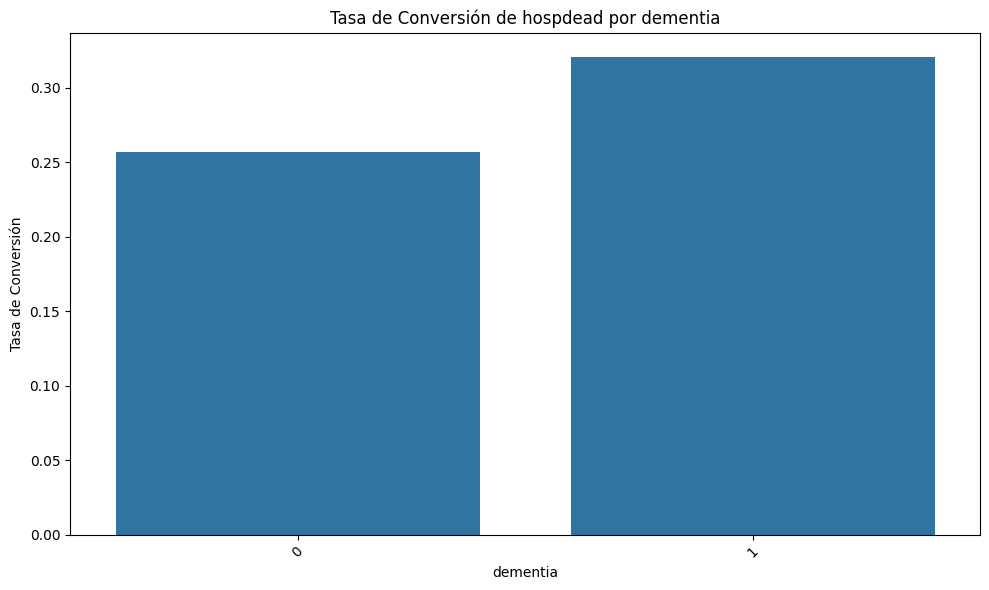


Tasa de Conversión para la variable 'ca':
    Categoria  Tasa de Conversión
0  metastatic            0.175996
1          no            0.260717
2         yes            0.375399


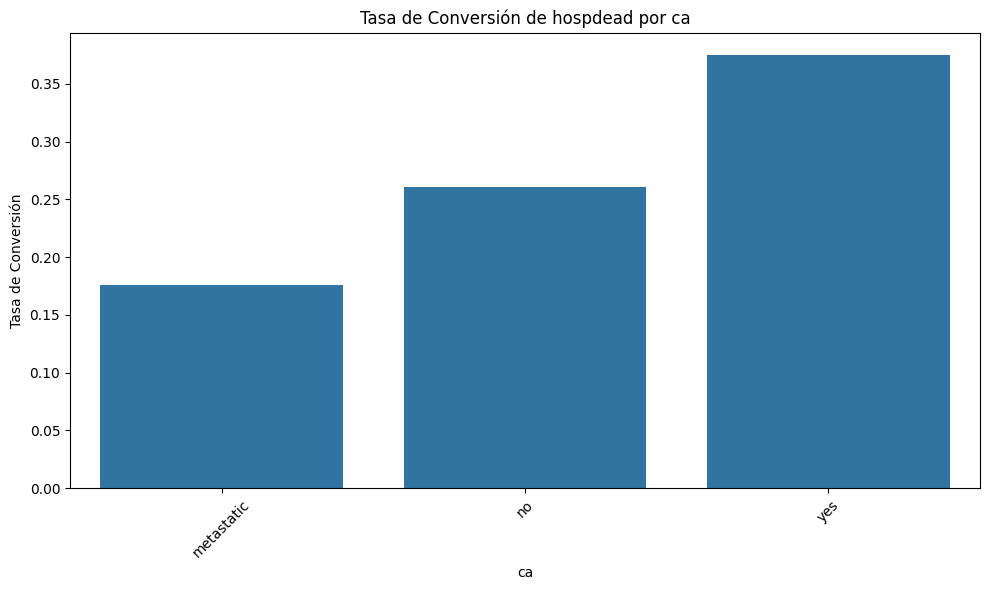


Tasa de Conversión para la variable 'dnr':
         Categoria  Tasa de Conversión
0   dnr after sadm            0.618403
1  dnr before sadm            0.313808
2           no dnr            0.075340


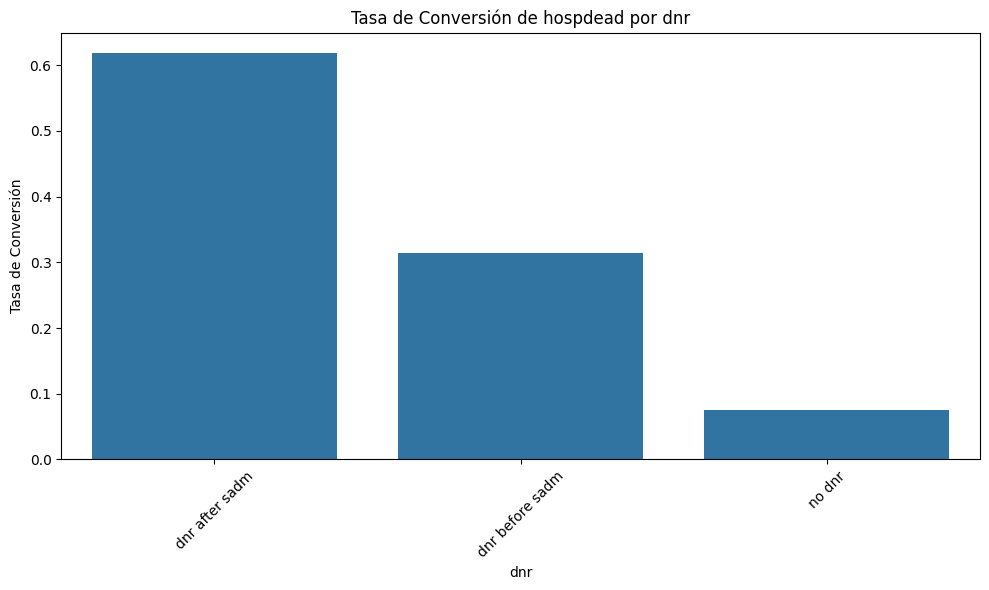

In [38]:
for column in categorical_columns:
    conversion_rate = data.groupby(column, observed=True)['hospdead_numeric'].mean().reset_index()
    conversion_rate.columns = ['Categoria', 'Tasa de Conversión']
    
    print(f"\nTasa de Conversión para la variable '{column}':")
    print(conversion_rate)
    
    # Graficar la tasa de conversión
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Categoria', y='Tasa de Conversión', data=conversion_rate)
    plt.title(f'Tasa de Conversión de hospdead por {column}')
    plt.xlabel(column)
    plt.ylabel('Tasa de Conversión')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


Podemos concluir que:
- En efecto a pesar de haber más hombres en el estudio, hay más mujeres que mueren. Así, un 26% de las muejeres murió.
- Sorpresivamente, aunque hay una mayor cantidad de personas con enfermedades clasifciadas en la categoría: ARF/MOSF w/Sepsis, la mayor proporción de muertes la obtuvo las personas con coma, pues murieron cerca del 60% de los pacientes.
- A pesar de haber más pacientes de raza blanca, en proprociones, los asiaticos murieron más (37%)
- De las personas que tenían cancer un 37% de las personas murieron.

### DIAGNÓSTICO

Luego de esta sección de EDA, se puede realizar el siguiente diagnóstico:

- Existe el problema de valores faltantes en 15 variables. La variable con mayor cantidad de missings es avtisst, con cerca de un 9%.
- Si bien no estamos frente a un caso grave de desbalanceo de clases, si existe una mayor cantidad de casos de no muerte (74.1%)
- Hay dos variables surv2m y surv6m con una varianza baja, más no igual a cero.
- Ninguna de las variables numéricas presenta una distribución normal.
- También has presencia de valores outliers en 15 variables númericas. Siendo la Variable scoma auella con mayor cantidad de datos atípcios (21%).
- Existen variables (númericas) altamente correlacionadas (linealmente). Aquellas con un coeficiente de correlación cercano al 1 son surv2m y surv6m. Asimismo hay otras correlaciones directas (aps-sps) e indirectas (surv2m, surv6m - sps,aps) muy altas. Esto puede indicar que existe una alta probabilidad de tener variables altamente correlacionadas y que se puede presentar multicolinealidad.
- Existen también variables categóricas altamente relacionadas (chi2), como dzgroup y dzclass, al ser lap rimra una subdivisión de la segunda.
- También se encontraron variables que no estaban tan relacionadas o no generaban tanto impacto sobre la variable objetivo (usando test de Mann-Whitney U y Chi2). No obstante, se cree que tal vez no son prueba suficiente para excluirlas del set de entrenamiento, sin antes evaluar y ver el impacto de estas en los clasificadores.

En ese orden de ideas, se logró identificar que en lso datos hay problemas de valores faltantes, valores atípicos y de multicolinealidad. Dichos porblemas deben tratarse antes de pasarse al clasificador, dado que podría verse afectado el aprendizaje de este. Esto sobretodo es cierto en algoritmos como la regresión logística y el SVM. Si bien hay familias de clasificadores que son más robustos a estos problemas (árboreos), no debe de descuidarse esta problemática a la hora de usar estos.


## 2. PREPROCESMAIENTO DE LOS DATOS

Para hacer frente a los problemas de calidad de datos encontrados en la sección de EDA, se procede entonces a crear un pipeline de procesamiento de los datos que nos ayude a mitigar estos.
No obstante, el primer paso que se realizará será el de eliminar las variables altamente correlacionadas o que son muy similares. La razón para tomar esta decisión es que a pesar que hayan modelos que sean robustos a esto (arbóreos), el introducir una variable redundante no tiene ninguna utilidad y si podría llevarnos a problemas de overfitting (los arbóreos). En caso de no usar uno de los clasificadores robustos para este escenario, tendríamos problemas de multicolinealidad. De esta manera, se eliminarán aquellas variables numéricas con un coeficiente de correlación superior a 0.8. sobre este umbral se encuentran las variables surv2m y surv6m. Se decide eliminar la variable surv6m, la razón de esto, es que dado obtuvo una correlación biserial frente a la variable objetivo menor que surv2m, lo cual nos indica que la segunda tiene más correlación con la variable objetivo.
Frente a las variables categóricas, dzgroup y dzclass, son muy similares, pues una es parte de la otra. Se decide así eliminar dzclass y dejar el mayor detalle que nos brinda dzgroup.

In [39]:
data=data.drop(['surv6m', 'dzclass', 'hospdead_numeric'], axis=1)

La variable hospdead_numeric se creo intencionalmente para poder calcular la correlación biserial, ya en este punto puede eliminarse

Continuando con el pipeline de procesamiento de datos, este estará compuesto por 2 pasos principales:
- Un preprocessor, un objeto ColumnTransformer, que a su vez esta compuesto por dos pasos (pipelines). Cada paso está definido para cada tipo de variable (numérica y categórica), puesto que los preprocesos que se realizarán serán diferentes en cada caso.
Ahondando en las transformaciones que se harán para cada tipo de variable tenemos:
- Un pipeline para variables numéricas, el cual como primer paso imputará los datos faltantes usando la mediana de los datos, esto se realizará con SimpleImputer(). Luego, se escalarán los datos, esto para eliminar las diferencias en magnitudes y unidades de medida y además para tratar de controlar el problema de los datos outliers. Por esto se uso un escalador robusto con RobustSclaer().
- el siguiente pipeline, es para las variables categóricas, el cual como primer paso imputará los valores missing de las variables categóricas creando una categoria adicional llamada 'missing'. La decisión de hacer esto obedeció a que se encontró que la única variable categórica que presentaba missings era race. Y de haber utilizado por ejemplo una estrategía diferente, como por ejemplo, usado la imputación basada en la moda, muy probablemente se habrían imputado valores de raza blanca que es la preponderante en el estudio, agravando aún así más el desbalance en estas categorías. Por tal motivo, se optó por crear una categoría extra. el segundo paso, será la numerización de las variables categóricas mediante One Hot Encoding y teniendo cuidado de eliminar una de las variables dummy creadas para evitar multicolinealidad perfecta entre las nuevas variables recién creadas (o la trampa de la variable dummy).

Finalmente, el preprocesador ColumnTransformer compuesto de los dos pipelines recién descritos, es incorporado en un pipeline final que se encarga de preprocesar los datos y de tratar de lidiar con los problemas de calidad de datos encontrados

In [40]:
numeric_features = data.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_features = data.select_dtypes(include='category').drop(['hospdead'], axis=1).columns.tolist()

### PIPELINE PARA APLICARSE SOBRE LAS COLUMNAS NUMÉRICAS

In [41]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())
])

### PIPELINE PARA APLICARSE SOBRE LAS COLUMNAS CATEGÓRICAS

In [42]:
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

### COLUMN TRANSFORMER (PIPELINE VARIABLES NUMÉRICAS Y PIPELINE VARIABLES CATEGÓRICAS)

In [43]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

### PIPELINE FINAL DE PREPROCESAMIENTO DE DATOS

In [44]:
data_preprocessing_pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

Este pipeline todavía no se usará, puesto que se incorporará en un pipeline que lleve a cabo la ejecución de lso clasificadores y que preprocese los datos una vez se hayan hecho ya las particiones de train y test, para evitar el problema 'data leakages', el cual es que al hacer el preprocesamiento, sobre todo el conjunto de datos, se filtre información o datos al conjunto de prueba, por ende es mejor realizar el preprocesamiento de manera individaul sobre cada set.

## 3. DIVISIÓN DE DATA SETS

In [45]:
X=data.drop(['hospdead'], axis=1)

In [46]:
y=data['hospdead']

Se definen las variables independientes (X) y la variable objetivo (y).

Se realiza a continuación, la división entre los set de entrenamiento y de prueba usando un pareto 80-20 respectivamente. Asimismo se usa la opción de stratify, para que la proporción de las etiquetas se distribuya guardando proporciones en los sets.

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f'Tamaño X_train: {X_train.shape}, Tamaño y_train: {y_train.shape}, Tamaño X_test: {X_test.shape}, Tamaño y_test: {y_test.shape}')

Tamaño X_train: (7284, 23), Tamaño y_train: (7284,), Tamaño X_test: (1821, 23), Tamaño y_test: (1821,)


## 4. BENCHMARK CLASSIFIER

En esta sección se acomplará todo (el pipeline de procesamiento de datos, hyperparameter tunning) y se aplicará sobre un primer clasificador sencillo que nos servirá de benchmark para luego comparar los resultados obtenidos frente a este clasificador.

El clasificador empleado como benchmark será NaiveBayes. Dado que es usaul en la literatira usar modelos sencillos como este o la regresión logística.

Se define el clasificador

In [48]:
naive_bayes_model = GaussianNB()

Se defina la el diccionario con el nombre (llave) del hyperparametro y los valores que puede tomar este (valor). Los valores que pueden tomar los hiperparametros se definen de manera aleatoria, dado que se usará un RandomizedSearchCV, esto dado a que la bñusqueda de los mejores hiperparametros es más rápida que usando GridSearchCV y dado a que se ha evidenciado que RandomizedSearchCV obtiene buenso resultados cuando también se usan valores aleatorios de los hiperparametros.

In [49]:
param_distributions_bm = {
    'model__var_smoothing': uniform(0.00001, 0.01)
}

Se crea el pipeline que incorpora los pasos de procesador de datos y el fit del clasificador

In [50]:
full_pipeline_bm = Pipeline([
    ('preprocessor', data_preprocessing_pipeline),
    ('model', naive_bayes_model)
])

Se configura el Stratified Kfold con 10 divisiones, con mezclado antes de ser divididos en folds y con semilla aleatoria para garantizar resultados reproducibles.
Luego este se emplea en la validación cruzada del optimizador parámetros RamdomizedSearchCV.
Este optimizador ejecutará el pipeline antes descrito, hará 100 iteraciones, combinando los hiperparámetros de manera aleatoria, usando una semilla aleatoria también para garantizar la reproducibilidad de resultados. El optimizador buscará la combinación de mejores hiperparámetros y el mejor clasificador en base al que obtenga el mejor f1. Se elige el f1, por encima de accuracy, el segundo no siempre es una buena métrica en escenarios de desbalance de datos (y aunque no es que sea precisamente este el caso, si existe una ligera tendencia a tener más datos de la clase 0), por tal motivo, se elige el f1_weighted, pues nos dará un rendimiento más holístico del clasificador al ser la media armónica de las métricas precision y recall. Y precisamente el weighted el cual pondera por la cantidad de instancias en cada etiqueta.

In [51]:
skf_bm = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

random_search_bm = RandomizedSearchCV(
    estimator=full_pipeline_bm,
    param_distributions=param_distributions_bm,
    n_iter=20,
    scoring='f1_weighted',
    refit='f1_weighted',
    cv=skf_bm,
    random_state=42,
    n_jobs=-1
)

Se ajusta el optimizador de hiperparametros usando cross validation y el pipeline de procesamiento de datos sobre los set de entrenamiento. Luego se imprimen los mejores hiperparametros y el mejor modelo. Recuordar que este solamente es el mejor modelo de Benchmark.

In [52]:
random_search_bm.fit(X_train, y_train)

best_params_bm = random_search_bm.best_params_
best_model_bm = random_search_bm.best_estimator_

print("Mejores hiperparámetros encontrados:", best_params_bm)
print("\nMejor modelo ajustado:")
print(best_model_bm)

Mejores hiperparámetros encontrados: {'model__var_smoothing': 0.0030524224295953774}

Mejor modelo ajustado:
Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('preprocessor',
                                  ColumnTransformer(transformers=[('num',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='median')),
                                                                                   ('scaler',
                                                                                    RobustScaler())]),
                                                                   ['age',
                                                                    'num.co',
                                                                    'scoma',
                                                                    'avtisst',
              

Se evalua ahora el mejor modelo de benchmark contra el set de prueba y se obtienen las métricas de desempeño (classification report, matriz de confusión y las curvas ROC y Precision Recall). Para el calculo y grafica de la curva ROC y Precision-Recall, se definieron las funciones declaradas al inicio del exámen.

Classification Report best Benchmark Model:
              precision    recall  f1-score   support

           0       0.91      0.89      0.90      1349
           1       0.71      0.76      0.73       472

    accuracy                           0.86      1821
   macro avg       0.81      0.83      0.82      1821
weighted avg       0.86      0.86      0.86      1821

Confusion Matrix best Benchmark Model


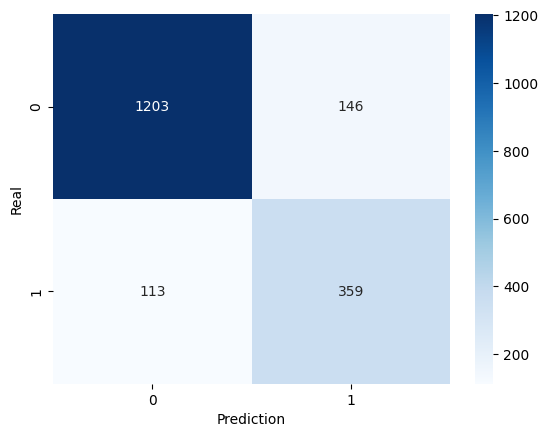

ROC Curve AUC: 0.911


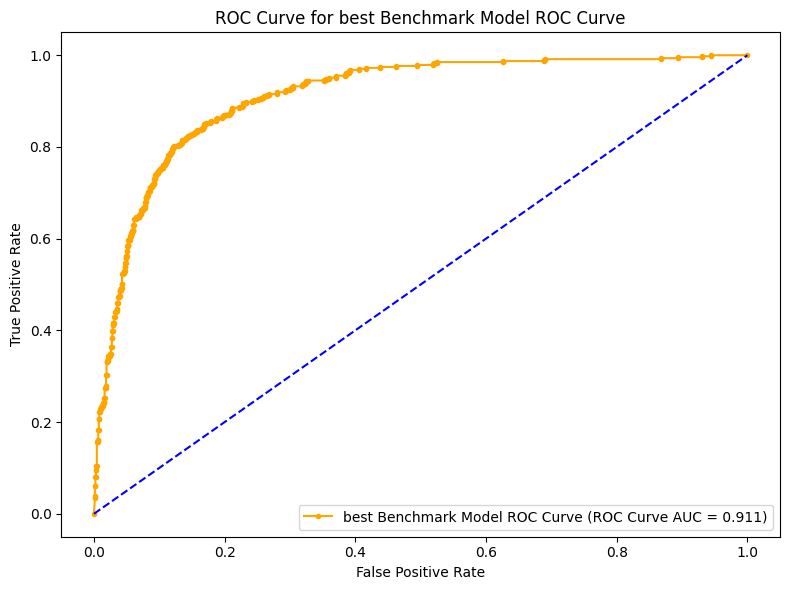

Precision-Recall Curve AUC: 0.773


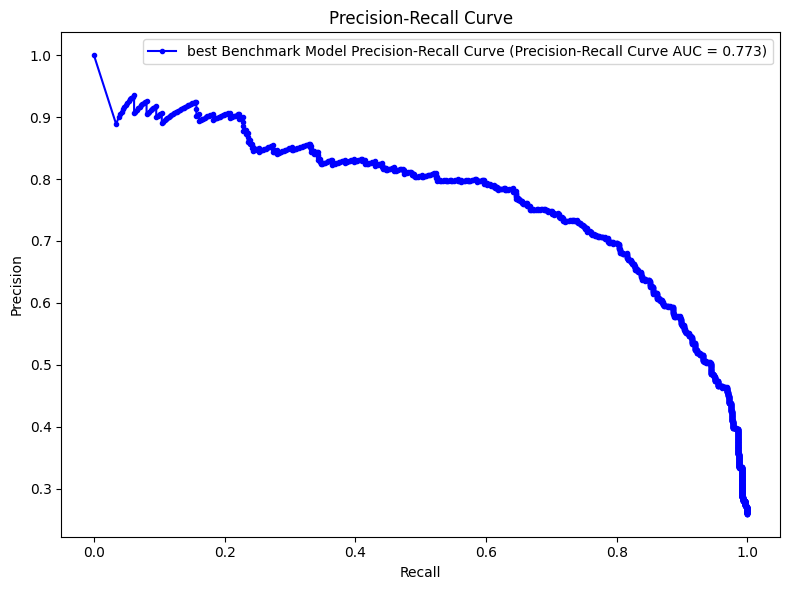

In [53]:
y_pred_bm = best_model_bm.predict(X_test)
print('Classification Report best Benchmark Model:')
print(classification_report(y_test, y_pred_bm))

print('Confusion Matrix best Benchmark Model')
sns.heatmap(confusion_matrix(y_test, y_pred_bm), annot=True, fmt='g', cmap='Blues')
plt.xlabel('Prediction')
plt.ylabel('Real')
plt.show()

auc_roc = plot_roc_curve(best_model_bm, X_test, y_test, label='best Benchmark Model ROC Curve')
auc_value = plot_precision_recall_curve(best_model_bm, X_test, y_test, label='best Benchmark Model Precision-Recall Curve')

## 5. "MANUAL AUTOML" - CLASIFICATION

En esta sección, se hará el ejercicio de clasificación de los datos. Se hará una especie de AutoML de manera manual, no empleando librerias como: TPOT, Auto-sklearn, H2O, MLJAR, entre otras.  Sino que se optó por hacerlo de manera manual, para poder mostrar paso a paso del proceso.

Así, se emplearán los siguientes clasificadores: Regresión Logística, SVM, Árbol de decisión, Random Forest, Gradient Boosting, Xgboost y LightGBM. La razón para elegir estos clasificadores y no otros, es primero para emplear los clasificadores más sencillos como la regresión logística y SVM (que ambos necesitan de mucho preprocesamiento de lso datos para dar resultados óptimos). Y el uso de clasificadores más potentes, resilientes y robustos a problemas de calidad de datos, como el xgboost y el LightGBM.

Se define así, un diccionario de diccionarios con lso clasificadores y con los valores de los hiperparámetros (elegidos aleatoriamente al igual que en el benchmark).

Se incorporaron hiperparametros que controlaban el overfitting, mediante penalizaciones como la regularización (Logistic Regresion, SVM, Xgboost y LightGBM), o que limitan el crecimiento de los árboles (Decision Tree, Random Forest, Gradient Boosto, Xgboost, LightGBM) o que controlan el número de campos a ser usados (Decision Tree, Random Forest, Gradient Boosto).

In [54]:
classifiers = {
    'Logistic Regression': (LogisticRegression(), {
        'model__C': loguniform(0.001, 100),
        'model__penalty': ['l2'],
        'model__solver': ['saga'],
        'model__max_iter': [500, 1000]
    }),
    'SVM': (SVC(probability=True), {
        'model__C': loguniform(0.001, 100),
        'model__gamma': loguniform(0.001, 100),
        'model__kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
        'model__degree': np.arange(2, 6)
    }),
    'Decision Tree': (DecisionTreeClassifier(), {
        'model__max_depth': np.arange(3, 20),
        'model__criterion': ['gini', 'entropy'],
        'model__min_samples_split': np.arange(2, 20),
        'model__min_samples_leaf': np.arange(1, 20),
        'model__max_features': ['sqrt', 'log2', None]
    }),
    'Random Forest': (RandomForestClassifier(), {
        'model__n_estimators': np.arange(50, 300, 50),
        'model__max_depth': np.arange(3, 15),
        'model__criterion': ['gini', 'entropy'],
        'model__min_samples_split': np.arange(2, 20),
        'model__min_samples_leaf': np.arange(1, 20),
        'model__max_features': ['sqrt', 'log2', None],
        'model__bootstrap': [True, False]
    }),
    'Gradient Boosting': (GradientBoostingClassifier(), {
        'model__n_estimators': np.arange(50, 300, 50),
        'model__learning_rate': uniform(0.01, 0.1),
        'model__max_depth': np.arange(3, 10),
        'model__min_samples_split': np.arange(2, 20),
        'model__min_samples_leaf': np.arange(1, 20),
        'model__subsample': uniform(0.5, 0.5),
        'model__max_features': ['sqrt', 'log2', None]
    }),
    'XGBoost': (XGBClassifier(eval_metric='logloss'), {
        'model__n_estimators': np.arange(50, 300, 50),
        'model__learning_rate': uniform(0.01, 0.1),
        'model__max_depth': np.arange(3, 10),
        'model__subsample': uniform(0.7, 0.3),
        'model__colsample_bytree': uniform(0.3, 0.7),
        'model__colsample_bylevel': uniform(0.3, 0.7),
        'model__min_child_weight': np.arange(1, 10),
        'model__reg_alpha': loguniform(0.001, 100),
        'model__reg_lambda': loguniform(0.001, 1e4)
    }),
    'LightGBM': (LGBMClassifier(verbosity=-1), {
        'model__n_estimators': np.arange(50, 300, 50),
        'model__learning_rate': uniform(0.01, 0.1),
        'model__max_depth': np.arange(3, 10),
        'model__num_leaves': np.arange(20, 150, 10),
        'model__min_child_samples': np.arange(1, 20),
        'model__subsample': uniform(0.5, 0.5),
        'model__colsample_bytree': uniform(0.3, 0.7),
        'model__reg_alpha': loguniform(0.001, 100),
        'model__reg_lambda': loguniform(0.001, 100)
    })
}

 Luego se creará un data frame (results), para almacenar los mejores resultados obtenidos por cada clasificador.

In [55]:
results_df = pd.DataFrame()

Se crea un bucle for para que itere por los elementos (llaves y valores) del diccionario de diccionarios en donde se encuentran tanto las instancias de los clasificadores como los hiperparámetros y valores de estos.

Asimismo, se define el pipeline (empleado también en el modelo de benchmark, el cual preprocesa los datos y ajusta el clasificador).

Luego se define el Stratified Kfold con los mismos parámetros que se definieron en el modelo de benchmark y el optimizador que hará el hyperparameter tunning (RandomSearchCV, con los mismos parámetros que en el benchmark).

Finalmente para cada clasificador se obtendrán los mejores hiperparámteros, el mejor modelo y sobre este último se realizará la evaluación contra el set de prueba.

Para la evaluación se imprimirá el classification_report, la matriz de confusión y se graficarán las curvas ROC y Precision-Recall obteniendo también sus AUC.

Entrenando y buscando hiperparámetros para: Logistic Regression

Classification Report para Logistic Regression:
              precision    recall  f1-score   support

           0       0.92      0.96      0.94      1349
           1       0.86      0.75      0.80       472

    accuracy                           0.90      1821
   macro avg       0.89      0.85      0.87      1821
weighted avg       0.90      0.90      0.90      1821



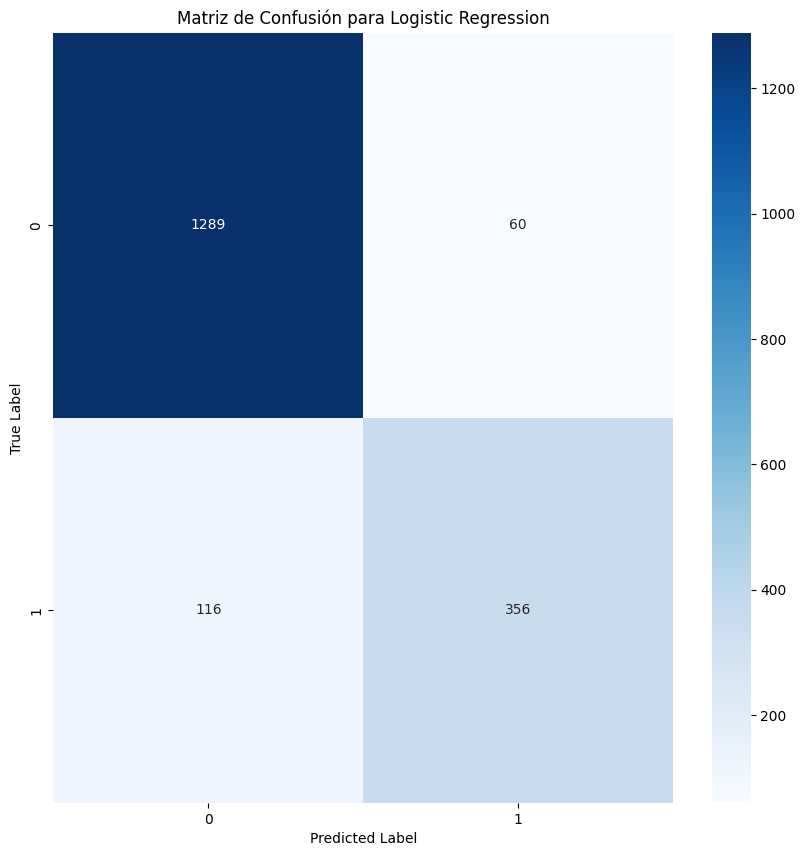

ROC Curve AUC: 0.947


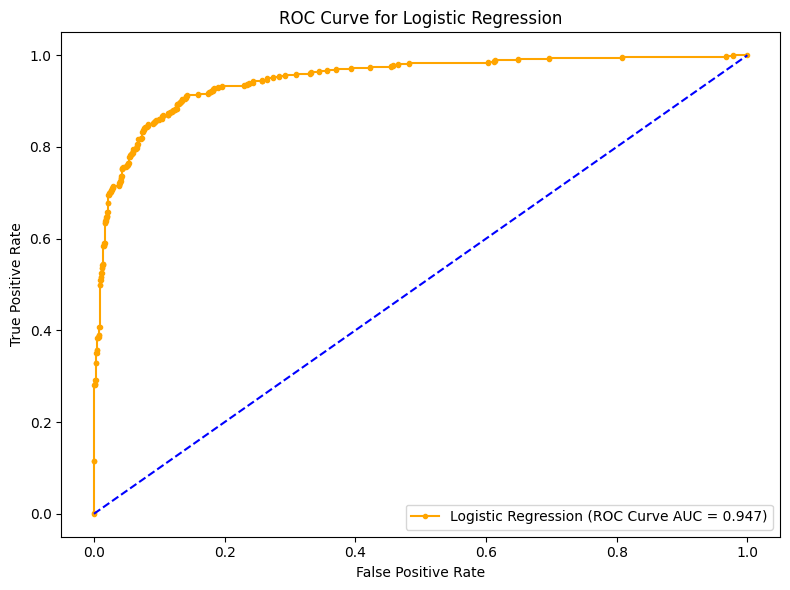

Precision-Recall Curve AUC: 0.889


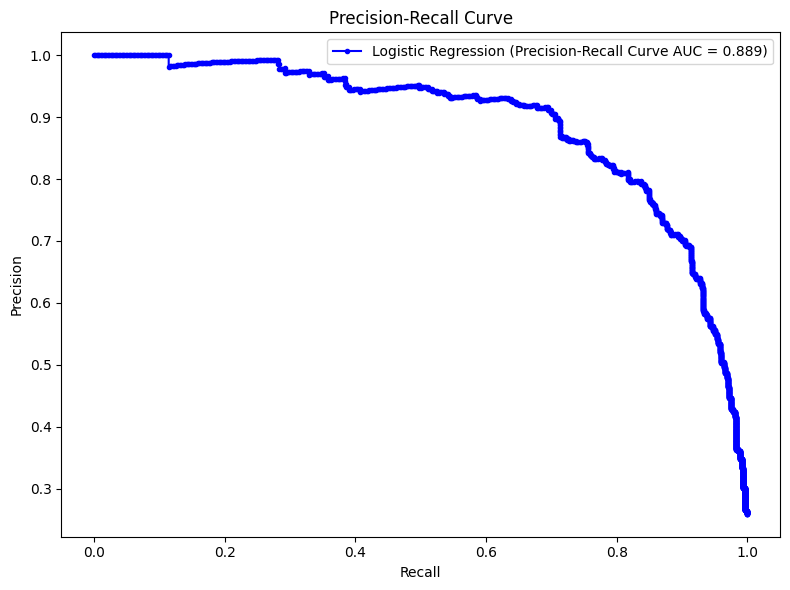

Entrenando y buscando hiperparámetros para: SVM

Classification Report para SVM:
              precision    recall  f1-score   support

           0       0.92      0.95      0.94      1349
           1       0.85      0.75      0.80       472

    accuracy                           0.90      1821
   macro avg       0.89      0.85      0.87      1821
weighted avg       0.90      0.90      0.90      1821



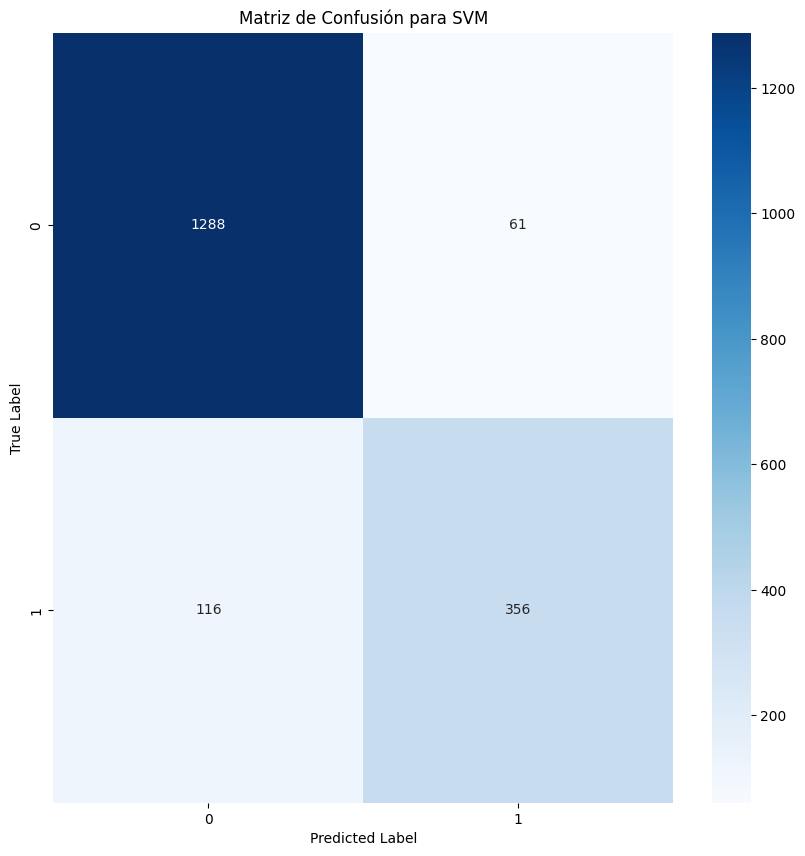

ROC Curve AUC: 0.947


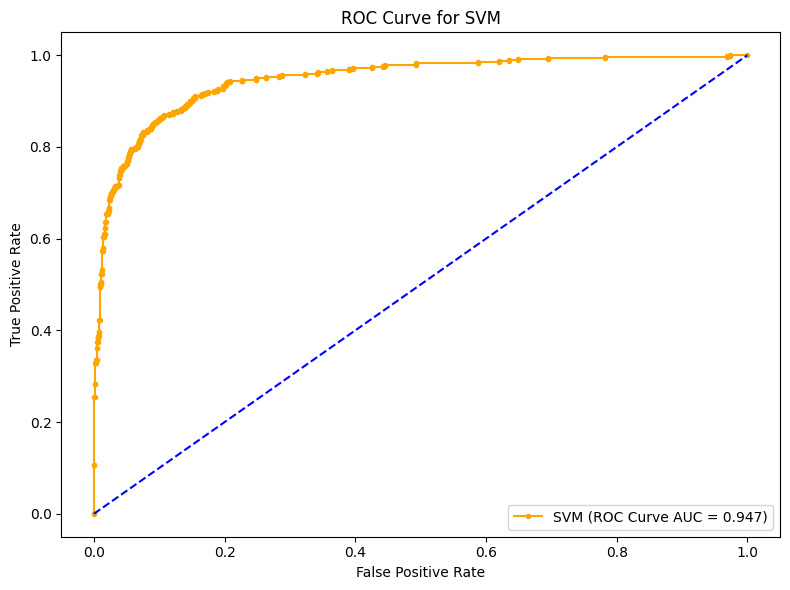

Precision-Recall Curve AUC: 0.889


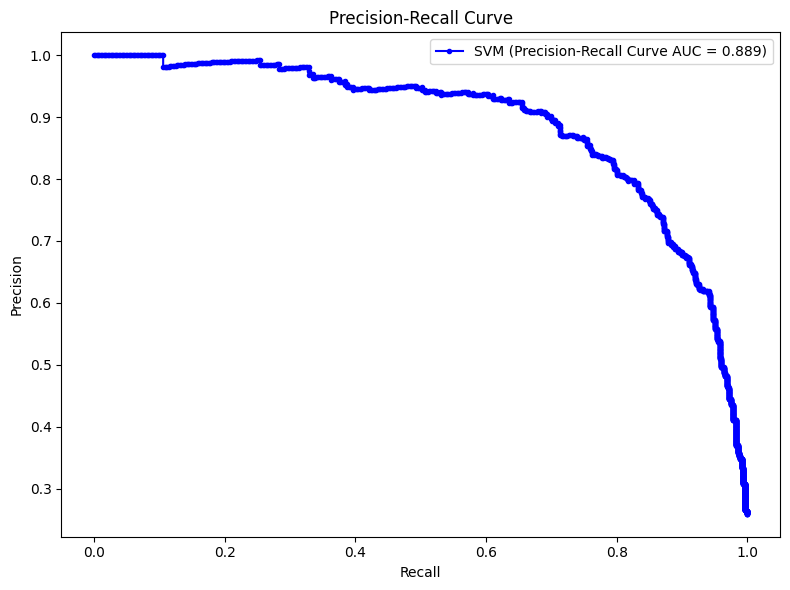

Entrenando y buscando hiperparámetros para: Decision Tree

Classification Report para Decision Tree:
              precision    recall  f1-score   support

           0       0.93      0.94      0.93      1349
           1       0.81      0.78      0.80       472

    accuracy                           0.90      1821
   macro avg       0.87      0.86      0.86      1821
weighted avg       0.90      0.90      0.90      1821



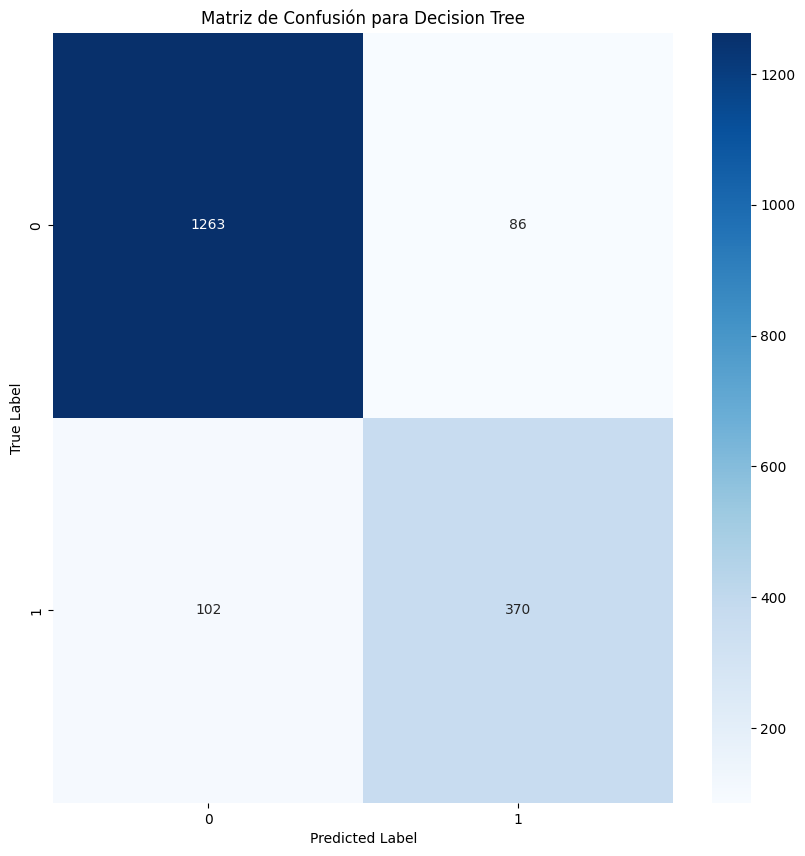

ROC Curve AUC: 0.905


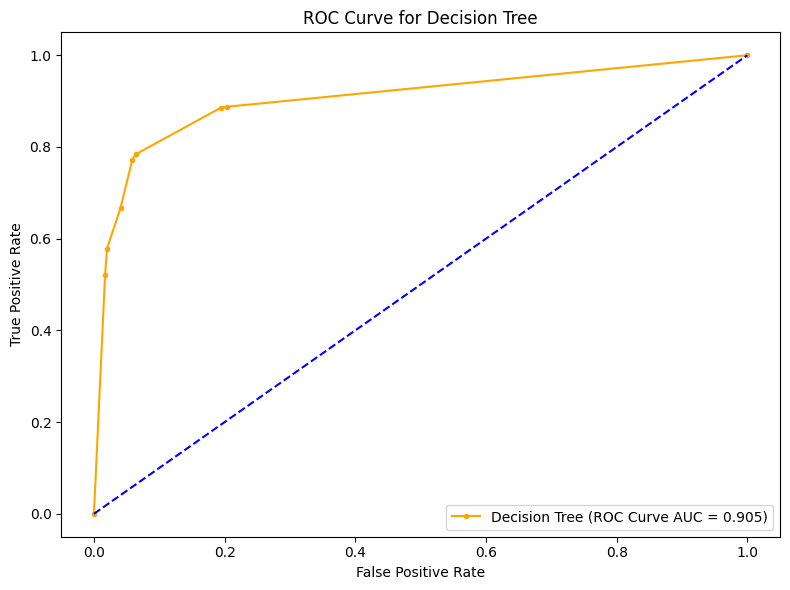

Precision-Recall Curve AUC: 0.849


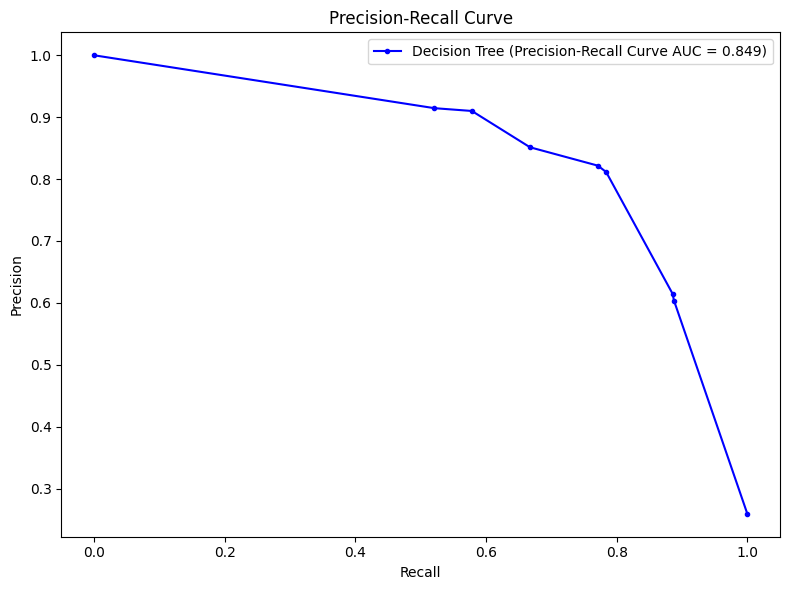

Entrenando y buscando hiperparámetros para: Random Forest

Classification Report para Random Forest:
              precision    recall  f1-score   support

           0       0.93      0.95      0.94      1349
           1       0.86      0.80      0.83       472

    accuracy                           0.91      1821
   macro avg       0.90      0.88      0.89      1821
weighted avg       0.91      0.91      0.91      1821



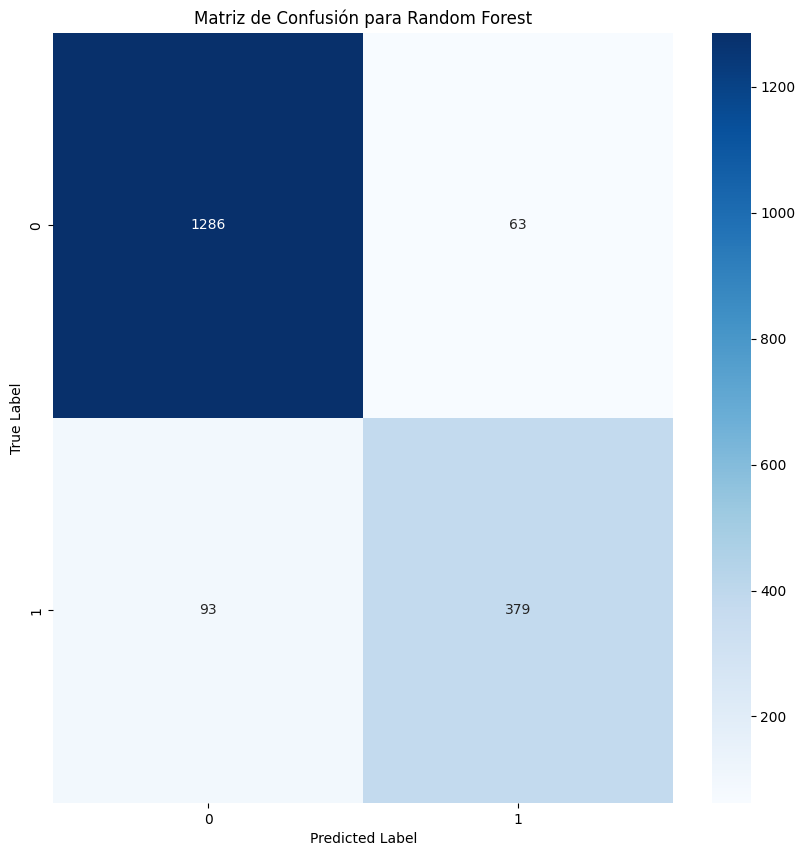

ROC Curve AUC: 0.951


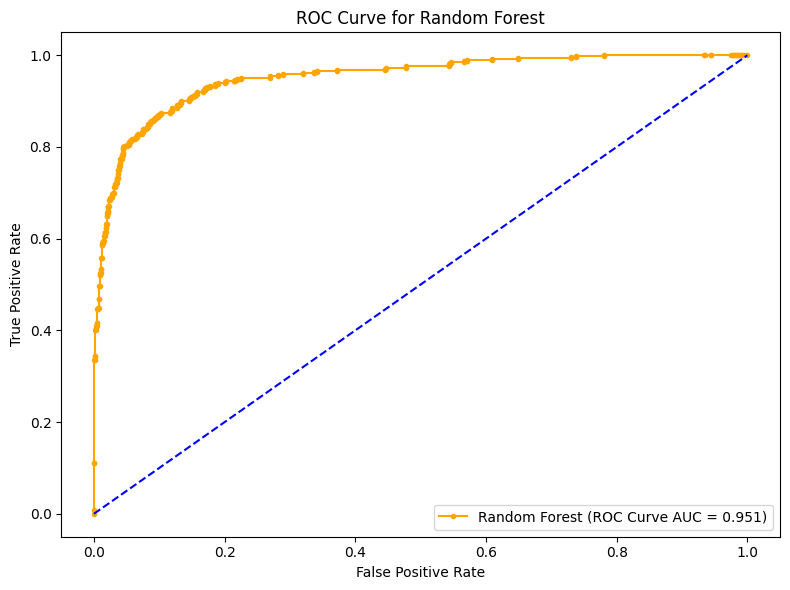

Precision-Recall Curve AUC: 0.898


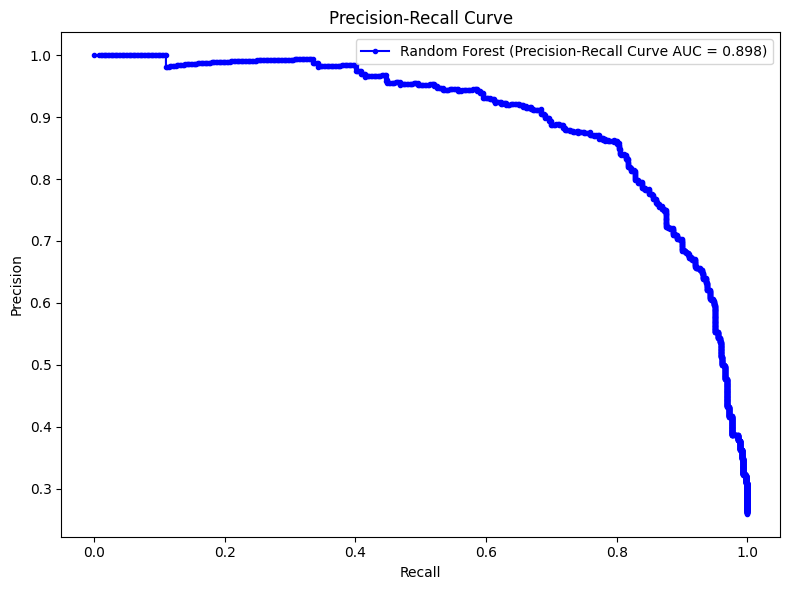

Entrenando y buscando hiperparámetros para: Gradient Boosting

Classification Report para Gradient Boosting:
              precision    recall  f1-score   support

           0       0.93      0.95      0.94      1349
           1       0.84      0.78      0.81       472

    accuracy                           0.91      1821
   macro avg       0.89      0.87      0.88      1821
weighted avg       0.91      0.91      0.91      1821



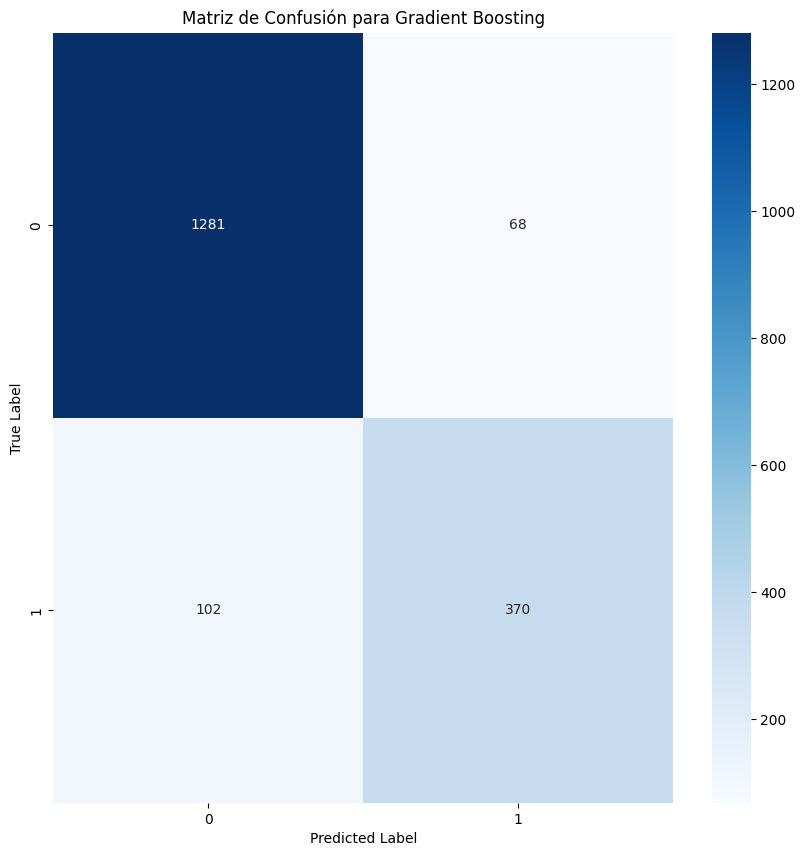

ROC Curve AUC: 0.952


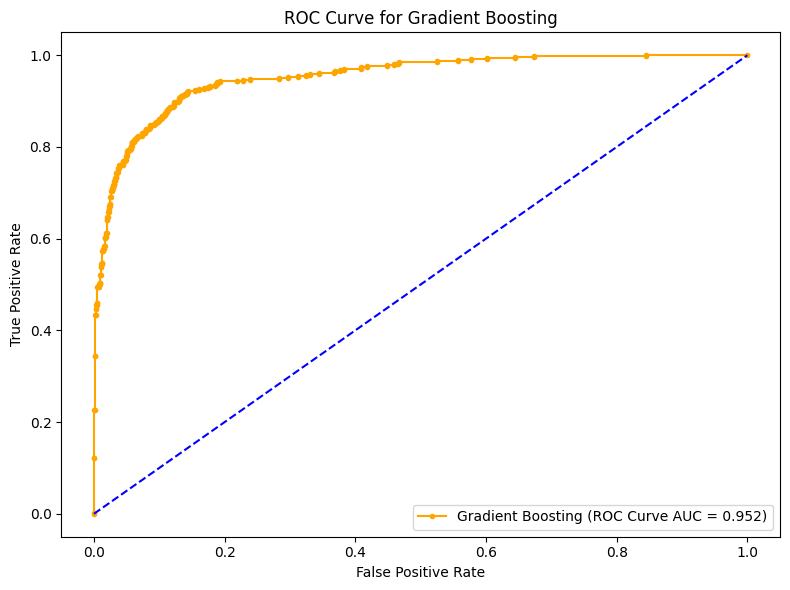

Precision-Recall Curve AUC: 0.898


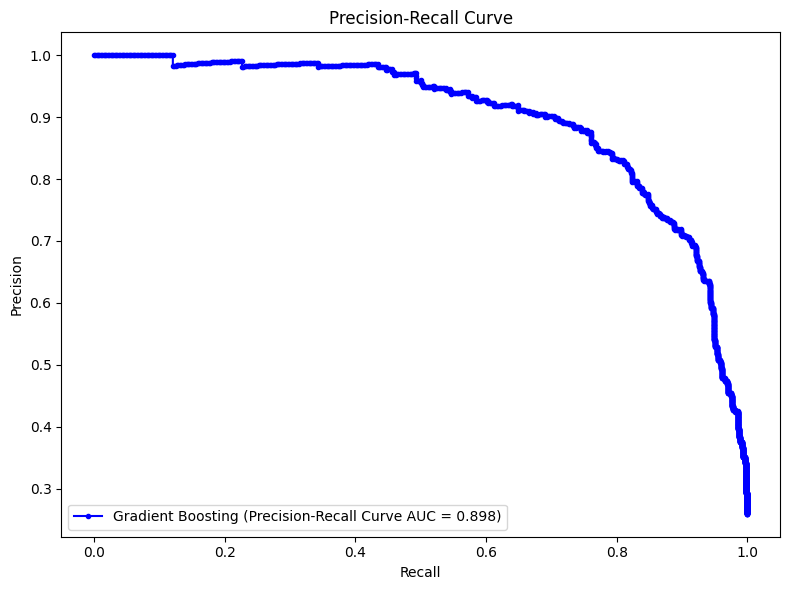

Entrenando y buscando hiperparámetros para: XGBoost

Classification Report para XGBoost:
              precision    recall  f1-score   support

           0       0.93      0.96      0.94      1349
           1       0.86      0.79      0.82       472

    accuracy                           0.91      1821
   macro avg       0.89      0.87      0.88      1821
weighted avg       0.91      0.91      0.91      1821



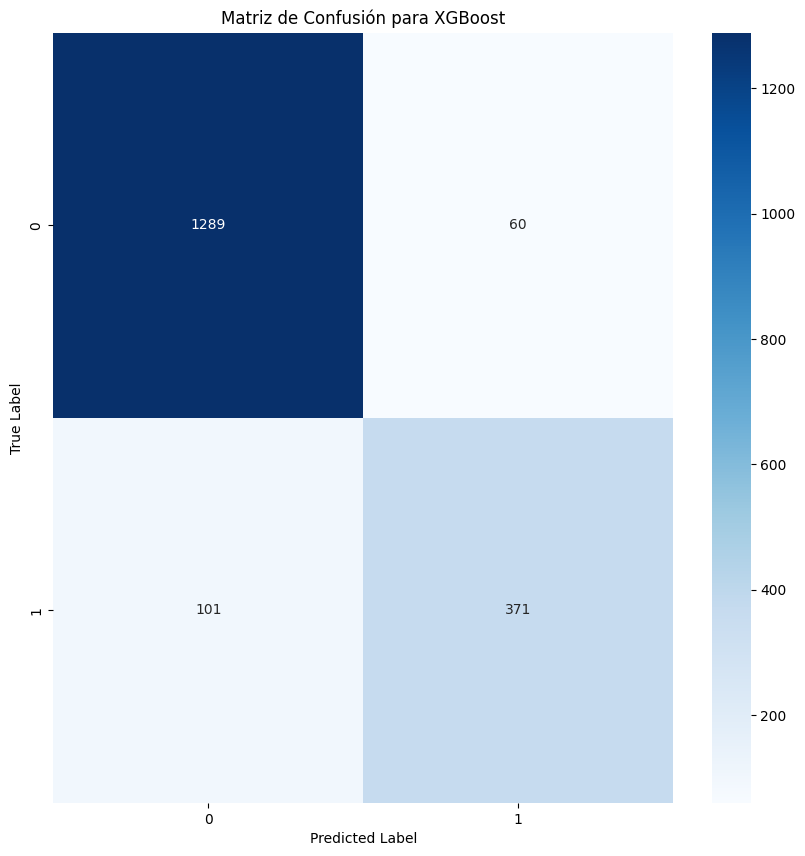

ROC Curve AUC: 0.955


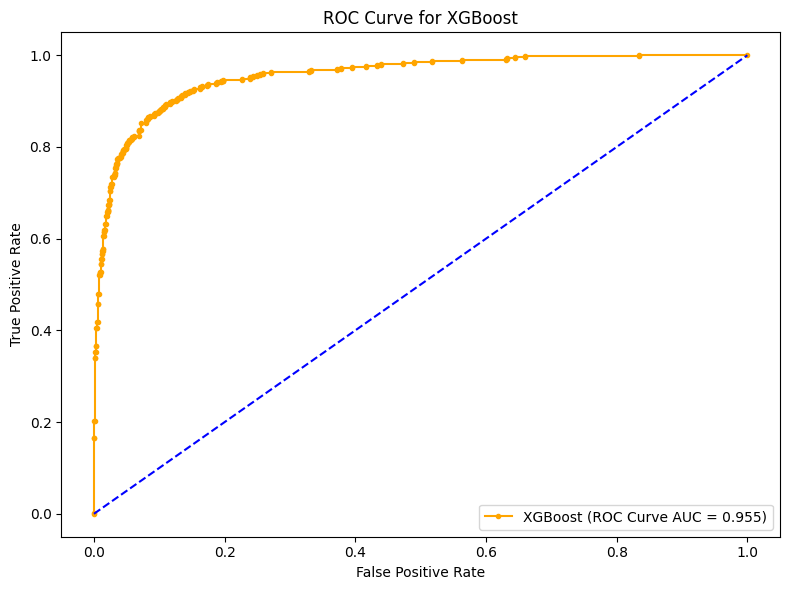

Precision-Recall Curve AUC: 0.903


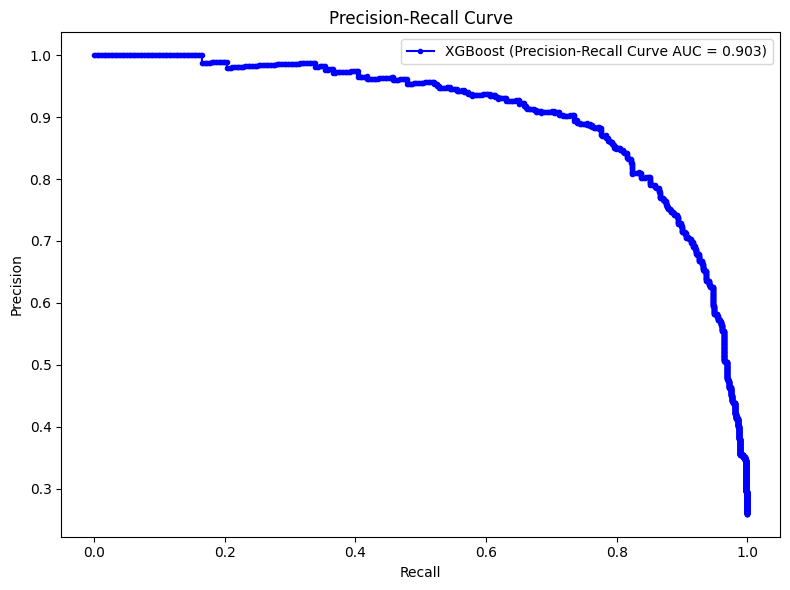

Entrenando y buscando hiperparámetros para: LightGBM

Classification Report para LightGBM:
              precision    recall  f1-score   support

           0       0.93      0.95      0.94      1349
           1       0.85      0.80      0.82       472

    accuracy                           0.91      1821
   macro avg       0.89      0.87      0.88      1821
weighted avg       0.91      0.91      0.91      1821



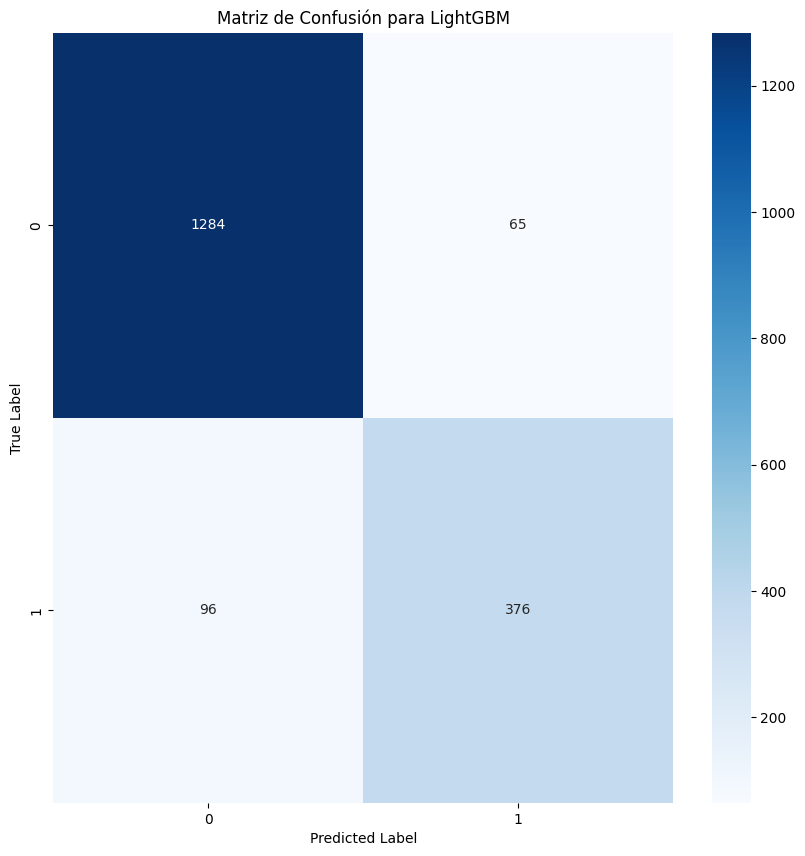

ROC Curve AUC: 0.953


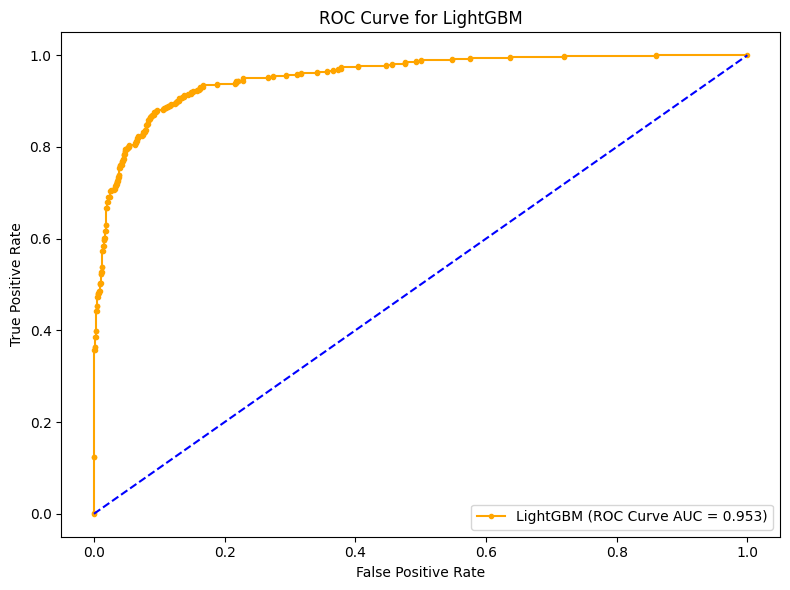

Precision-Recall Curve AUC: 0.901


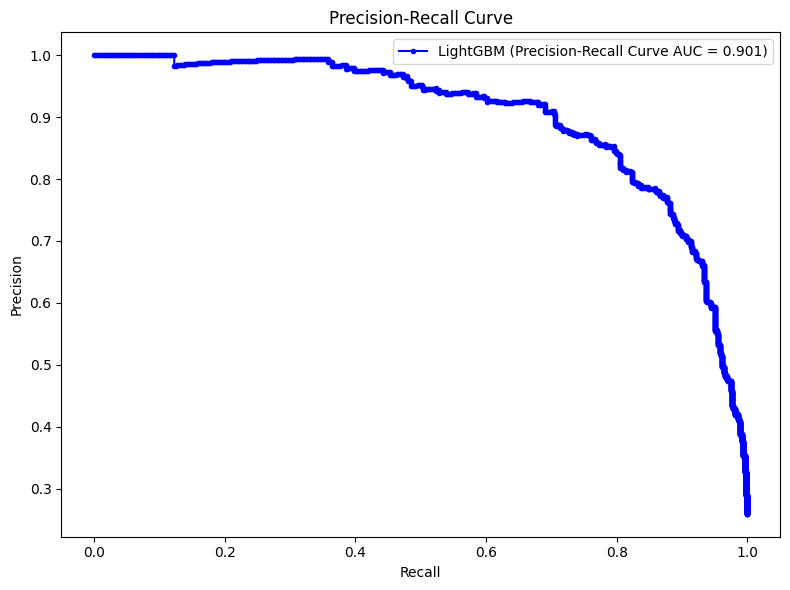

In [56]:
# Bucle for sobre los clasificadores y sus grillas de hiperparámetros
for classifier_name, (classifier, param_grid) in classifiers.items():
    print(f"Entrenando y buscando hiperparámetros para: {classifier_name}")
    
    # Pipeline de preprocesamiento de datos y fit de cada clasificador
    full_pipeline = Pipeline([
        ('preprocessor', data_preprocessing_pipeline),
        ('model', classifier)
    ])
    
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    random_search = RandomizedSearchCV(
        estimator=full_pipeline,
        param_distributions=param_grid,
        n_iter=20,
        scoring='f1_weighted',
        refit='f1_weighted',
        cv=skf,
        random_state=42,
        n_jobs=-1
    )
    
    random_search.fit(X_train, y_train)
    
    # Obtener los mejores modelos y sus métricas de evaluación
    best_model=random_search.best_estimator_
    y_pred = best_model.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True)
    

    print(f"\nClassification Report para {classifier_name}:")
    print(classification_report(y_test, y_pred))
    
    # Matriz de confusión
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 10))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1], yticklabels=[0, 1])
    plt.title(f"Matriz de Confusión para {classifier_name}")
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    # Curva ROC
    auc_roc = plot_roc_curve(best_model, X_test, y_test, label=classifier_name)
    
    # Curva Precision-Recall
    auc_pr = plot_precision_recall_curve(best_model, X_test, y_test, label=classifier_name)
    
    # Guardado de las métricas en el data Frame de resultados
    report_df = pd.DataFrame(report).transpose()
    report_df['Model'] = classifier_name
    report_df['Best Params'] = str(random_search.best_params_)
    report_df['AUC ROC'] = auc_roc
    report_df['AUC Precision-Recall'] = auc_pr
    
    results_df = pd.concat([results_df, report_df])

El data frame en el cual se almacenaron todos los resultados del mejor modelo obtenido por cada clasificador luce de la siguiente manera

In [57]:
results_df.head(10)

precision    recall  f1-score      support                Model  \
0              0.917438  0.955523  0.936093  1349.000000  Logistic Regression   
1              0.855769  0.754237  0.801802   472.000000  Logistic Regression   
accuracy       0.903350  0.903350  0.903350     0.903350  Logistic Regression   
macro avg      0.886603  0.854880  0.868947  1821.000000  Logistic Regression   
weighted avg   0.901453  0.903350  0.901285  1821.000000  Logistic Regression   
0              0.917379  0.954781  0.935707  1349.000000                  SVM   
1              0.853717  0.754237  0.800900   472.000000                  SVM   
accuracy       0.902801  0.902801  0.902801     0.902801                  SVM   
macro avg      0.885548  0.854509  0.868303  1821.000000                  SVM   
weighted avg   0.900878  0.902801  0.900765  1821.000000                  SVM   

                                                                                                                        Best Params  \
0                       {'model__C': 0.37253938395788866, 'model__max_iter': 1000, 'model__penalty': 'l2', 'model__solver': 'saga'}   
1                       {'model__C': 0.37253938395788866, 'model__max_iter': 1000, 'model__penalty': 'l2', 'model__solver': 'saga'}   
accuracy                {'model__C': 0.37253938395788866, 'model__max_iter': 1000, 'model__penalty': 'l2', 'model__solver': 'saga'}   
macro avg               {'model__C': 0.37253938395788866, 'model__max_iter': 1000, 'model__penalty': 'l2', 'model__solver': 'saga'}   
weighted avg            {'model__C': 0.37253938395788866, 'model__max_iter': 1000, 'model__penalty': 'l2', 'model__solver': 'saga'}   
0             {'model__C': 0.37253938395788866, 'model__degree': 5, 'model__gamma': 0.21568228019263963, 'model__kernel': 'linear'}   
1             {'model__C': 0.37253938395788866, 'model__degree': 5, 'model__gamma': 0.21568228019263963, 'model__kernel': 'linear'}   
accuracy      {'model__C': 0.37253938395788866, 'model__degree': 5, 'model__gamma': 0.21568228019263963, 'model__kernel': 'linear'}   
macro avg     {'model__C': 0.37253938395788866, 'model__degree': 5, 'model__gamma': 0.21568228019263963, 'model__kernel': 'linear'}   
weighted avg  {'model__C': 0.37253938395788866, 'model__degree': 5, 'model__gamma': 0.21568228019263963, 'model__kernel': 'linear'}   

               AUC ROC  AUC Precision-Recall  
0             0.946968              0.889469  
1             0.946968              0.889469  
accuracy      0.946968              0.889469  
macro avg     0.946968              0.889469  
weighted avg  0.946968              0.889469  
0             0.946746              0.888844  
1             0.946746              0.888844  
accuracy      0.946746              0.888844  
macro avg     0.946746              0.888844  
weighted avg  0.946746              0.888844

Siendo consistentes con el criterio elegido para el optimizador de hiperparámetros, se ordena los resultados pro el f1_weighted, el cual tiene en cuenta el f1 de acuerdo a la cantidad de instancias en cada clase.

In [58]:
weighted_avg_df = results_df[results_df.index == 'weighted avg']
weighted_avg_sorted_df = weighted_avg_df.sort_values(by='f1-score', ascending=False)
weighted_avg_sorted_df

precision    recall  f1-score  support                Model  \
weighted avg   0.913096  0.914333  0.913398   1821.0        Random Forest   
weighted avg   0.910262  0.911587  0.910588   1821.0             LightGBM   
weighted avg   0.910089  0.911587  0.910242   1821.0              XGBoost   
weighted avg   0.905123  0.906645  0.905482   1821.0    Gradient Boosting   
weighted avg   0.901453  0.903350  0.901285   1821.0  Logistic Regression   
weighted avg   0.900878  0.902801  0.900765   1821.0                  SVM   
weighted avg   0.895760  0.896760  0.896174   1821.0        Decision Tree   

                                                                                                                                                                                                                                                                                                                                                         Best Params  \
weighted avg                                                                                                                                                   {'model__n_estimators': 100, 'model__min_samples_split': 17, 'model__min_samples_leaf': 2, 'model__max_features': None, 'model__max_depth': 13, 'model__criterion': 'gini', 'model__bootstrap': True}   
weighted avg                      {'model__colsample_bytree': 0.7681888768645251, 'model__learning_rate': 0.07659223566174966, 'model__max_depth': 6, 'model__min_child_samples': 8, 'model__n_estimators': 150, 'model__num_leaves': 40, 'model__reg_alpha': 0.22965432344634354, 'model__reg_lambda': 0.00396251783257234, 'model__subsample': 0.8566223936114975}   
weighted avg  {'model__colsample_bylevel': 0.9404717728806464, 'model__colsample_bytree': 0.8950270044528594, 'model__learning_rate': 0.054945067413820346, 'model__max_depth': 3, 'model__min_child_weight': 7, 'model__n_estimators': 250, 'model__reg_alpha': 4.446628955475449, 'model__reg_lambda': 29.033694281285644, 'model__subsample': 0.9661638227728979}   
weighted avg                                                                                                                      {'model__learning_rate': 0.04308980248526492, 'model__max_depth': 9, 'model__max_features': None, 'model__min_samples_leaf': 5, 'model__min_samples_split': 4, 'model__n_estimators': 200, 'model__subsample': 0.8187787356776066}   
weighted avg                                                                                                                                                                                                                                             {'model__C': 0.37253938395788866, 'model__max_iter': 1000, 'model__penalty': 'l2', 'model__solver': 'saga'}   
weighted avg                                                                                                                                                                                                                                   {'model__C': 0.37253938395788866, 'model__degree': 5, 'model__gamma': 0.21568228019263963, 'model__kernel': 'linear'}   
weighted avg                                                                                                                                                                                                         {'model__min_samples_split': 16, 'model__min_samples_leaf': 10, 'model__max_features': None, 'model__max_depth': 3, 'model__criterion': 'gini'}   

               AUC ROC  AUC Precision-Recall  
weighted avg  0.950618              0.898145  
weighted avg  0.953167              0.900706  
weighted avg  0.954918              0.903295  
weighted avg  0.951606              0.898074  
weighted avg  0.946968              0.889469  
weighted avg  0.946746              0.888844  
weighted avg  0.904731              0.848929

In [59]:
best_params_f1_weigthed = eval(weighted_avg_sorted_df.iloc[0]['Best Params'])
best_params_f1_weigthed

{'model__n_estimators': 100,
 'model__min_samples_split': 17,
 'model__min_samples_leaf': 2,
 'model__max_features': None,
 'model__max_depth': 13,
 'model__criterion': 'gini',
 'model__bootstrap': True}

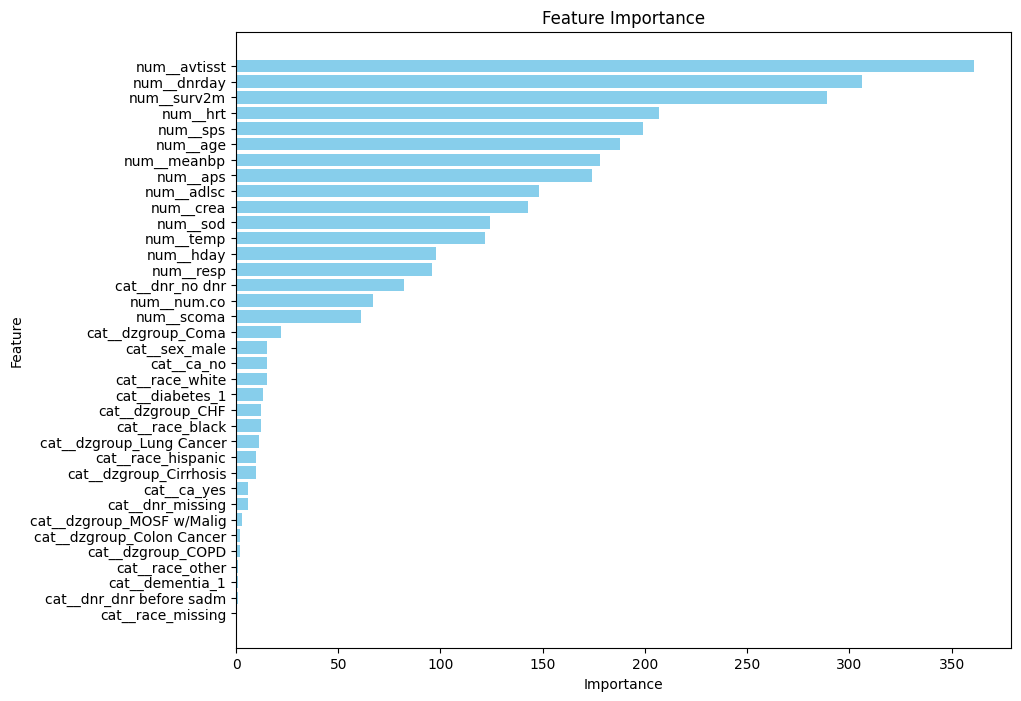

C:\Users\USER}\AppData\Local\Programs\Python\Python311\Lib\site-packages\shap\explainers\_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


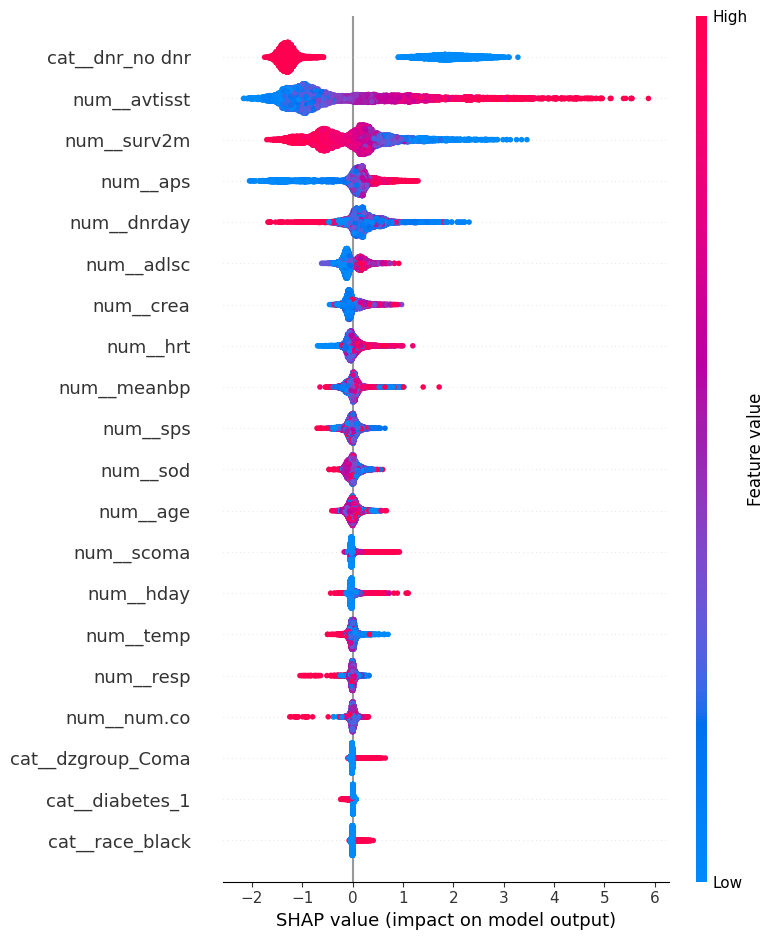

In [60]:
best_lightgbm_model = LGBMClassifier(**best_params_f1_weigthed)
full_pipeline_f1_weigthed = Pipeline([
    ('preprocessor', data_preprocessing_pipeline),
    ('model', best_lightgbm_model)
])

full_pipeline_f1_weigthed.fit(X_train, y_train)

# Se obtiene la importancia de las variables
model = full_pipeline_f1_weigthed.named_steps['model']
feature_importances = model.feature_importances_


X_train_transformed = full_pipeline_f1_weigthed.named_steps['preprocessor'].transform(X_train)
transformed_feature_names = full_pipeline_f1_weigthed.named_steps['preprocessor'].get_feature_names_out()

# Se crea un DataFrame para la importancia de las variables
feature_importance_df = pd.DataFrame({
    'Feature': transformed_feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

feature_importance_df = pd.DataFrame({
    'Feature': transformed_feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Se grafican las importancisa de las variables
plt.figure(figsize=(10, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()

###SHAP values


explainer = shap.TreeExplainer(model)

# Calculo de los SHAP values
shap_values = explainer.shap_values(X_train_transformed)


plt.figure(figsize=(10, 10))


# Gráfico de resumen detallado de SHAP values
shap.summary_plot(shap_values, X_train_transformed, feature_names=transformed_feature_names)

## 6. RESULTADOS

Como pudo observarse en la sección anterior, los resultados generales de todos los clasificadores entrenados son bastantes altos en todas sus métricas y parecidos entre si. De hecho, todos los clasificadores obtienen mejores valores en sus métricas de clasificación frente al modelo de benchmark.

No obstante, a pesar de su similitud en las métricas de clasificación, ba´sándonos en la métrica de f1_weighted, l acual también fue elegida para elegir el mejor modelo del hyperparameter tunning, se tiene que el mejor modelo es el lightgbm.
Obteniendo:

- Accuracy: 0.91
- Recall_weighted: 0.91
- Precision_weighted: 0.91
- f1_weighted: 0.91
- ROC_AUC: 0.95
- Precision-Recall_AUC: 0.90

**FEATURE IMPORTANCES**

Complementando estos resultados, se obtienen las feature importances (que solamente pueden ser obtenidos de lso modelso arboreos), o que nos puede ayudar a ver cuales variables fueron las más decisivas en el ejercicio de clasificación.

Así, la variable más importante fue avtisst, la cual esta relacionada con el costo de UCI. Esto nos indicaría que a mayor costo de UCI es muy probable que el paciente muera. Quizá altos valores de UCI implican o bien que el paciente lleva mucho tiempo en cuidados intensivos o que su condición es tan grave que se le han aplicado muchso tratamientos en UCI, lo cual estaría relacionado con una mayor gravedad en la enfermedad.

De igual forma, la segunda variables más importante es el día en que el paciente dió la orden de no reanimar.

Las siguientes dos variables en importancia son surv2m (el cual esta relacionado con el score dado de probabilidad de supervivencia en los próximos 2 meses), esta variable al parecer permitiría al modelo saber si un paciente es más o menos propenso a morir. Y por otro lado, la variable del ritmo cardiaco es importante para el modelo a la hora de realizar la clasificación.


Por el otro lado, viendo las variables menos importantes para el modelo, son la categoria de raza faltante (la construida por los valores faltantes presentes en esta variable), la categoría de demencia, la categoria de raza 'otra', etc. Esto nos indicaría que es probable que se pueda hacer una selección de características eliminando estas para una iteración futura.


**SHAP VALUES**

Complementando los resultados previos se obtienen los SHAP values de las features, lo cual nos permiten ver la contribución y dirección que aportan las variables a la predicción final del modelo para cada instancia.

Así, podemos ver que la variable categórica dnr_nodnr, que indica que no se tiene la orden de no resucitar, es muy importante para la predicción del modelo, pues no solo esta representada en color roho (indica impacto alto) sino que la densidad de sus puntos es muy grande y se aleja del eje Y y el valor cero. Sino que además tiene un impacto negativo sobre la predicción, es decir que aumenta a la predicción de la etiqueta cero. Esto tiene sentido pues indica que las personas sin orden de no resucitar, quizá no la han dado porque su condición no es grave como para pensar en resucitación.

Por otro lado, siguiendo este mismo ejemplo, la variable surv2m, empuja más a la etiqueta cero, lo cual también tiene mucho sentido, pues un score que mide la probabilidad de sobrevivencia a mayores valores nos indica que hay menos propbabilidades de morir.

De igual forma, valores bajos de avtisst, implican menor porbabilidad de morir, esto puede verse en la densidad roja con valor negativo en la gráfica de SHAP values.


**CONCLUSIÓN**

A modo de conclusión, puede pensarse que es extraño que todos lso clasificadores den valores tan simialres y altos en su smétricas de clasificación. Esto me llevó a pensar que quizá las variables surv2m y surv6m estaban filtrando de cierta manera información al modelo, pues estas mismas son un score de probabilidad de supervivencia generado por otro modelo, lo cual en otras palbras e slo mismo que estoy intentando predecir. De esta manera, el incorporar estas variables tan relacionadas con las etiquetas puede llevar a que el modelo obtenga tan bueno resultados pues en parte le estoy 'soplando apriori una cierta relación entr eest avariable y la etiqueta.

Así, considero que podría realizarse una iteración posterior del modelo eliminando estas variable sal igual que eliminando las variables que en la feature importances nos dieron como muy poco relevantes.

Asimismo, creo que se podría usar directamente los datos (con su problemas de calidad) con uno de los modelso supervisados más robustos frente a estos problemas, como lo son el xgboost y el lightgbm (de hecho esto se hace al final, en la sección 7 a modo de epilogo con el lightgbm). La razón de esto es que quizá ciertos pasos del preprocesmaiento como lo es el OHE pueden generar tanats variables dicotomas que podrían afectar de algún modo la caja negra del modelo. Así, estos modelos pueden lidiar bien con las variable scategóricas sin necsidad de aumentar dimensionalmente el dataset.



## 7. CLASIFICATION USANDO XGBOOST SIN PREPROCESAMIENTO DE DATOS

A modo de epilogo se intenta un ejercicio de clasificación usando un modelo robusto a los problemas de calidad de datos encontrados como lo es el lightgbm. Para esto se pasa el datset sinmayor preproecesmiento (de hecho sin pasar por el pipeline de preproecesamiento de datos).


Classification Report para LightGBM:
              precision    recall  f1-score   support

           0       0.93      0.95      0.94      1349
           1       0.85      0.79      0.82       472

    accuracy                           0.91      1821
   macro avg       0.89      0.87      0.88      1821
weighted avg       0.91      0.91      0.91      1821



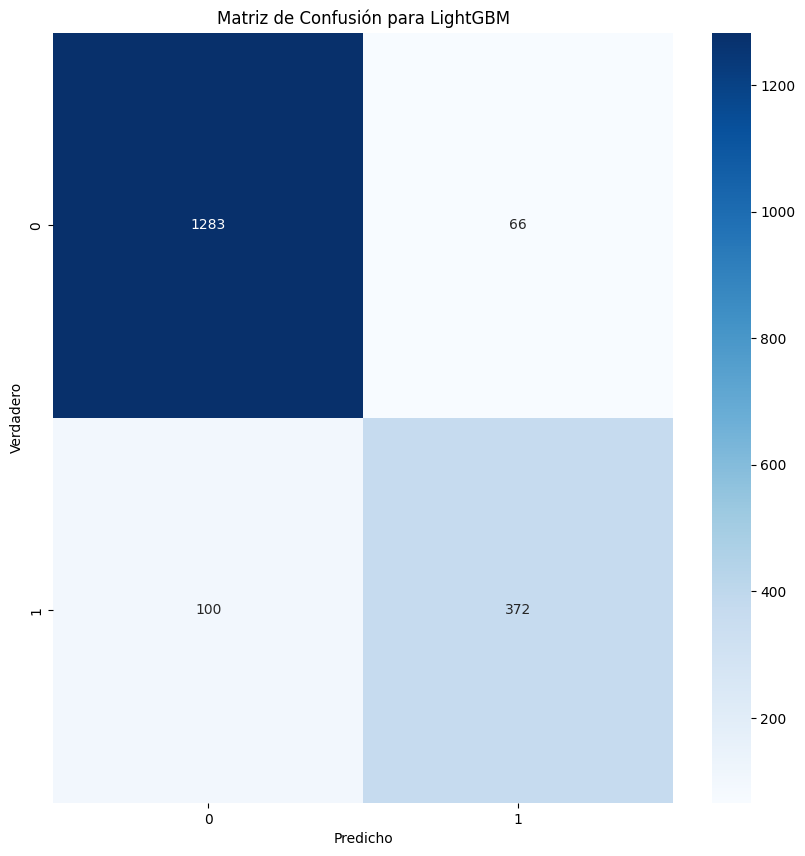

ROC Curve AUC: 0.953


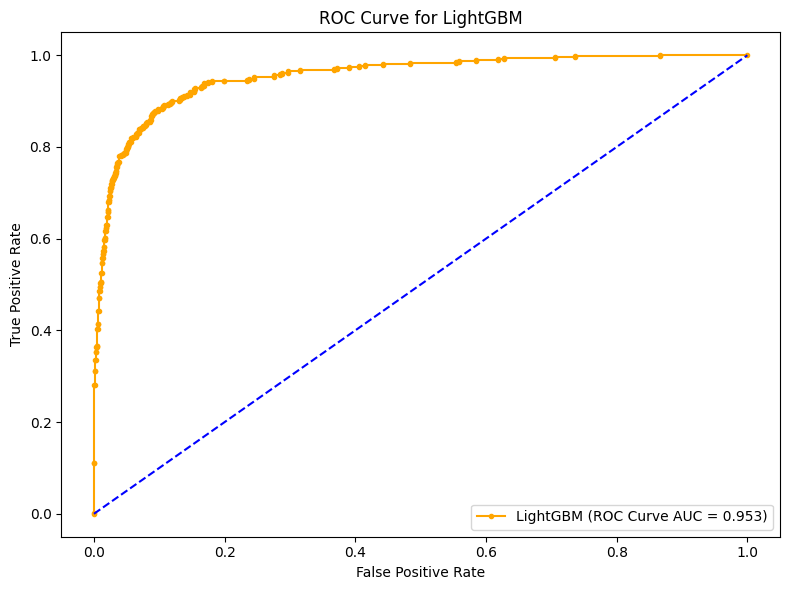

Precision-Recall Curve AUC: 0.900


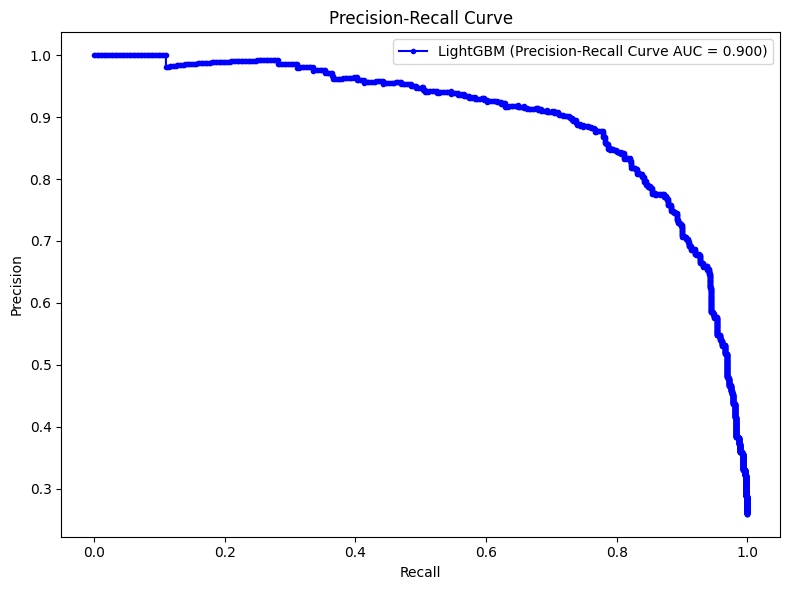

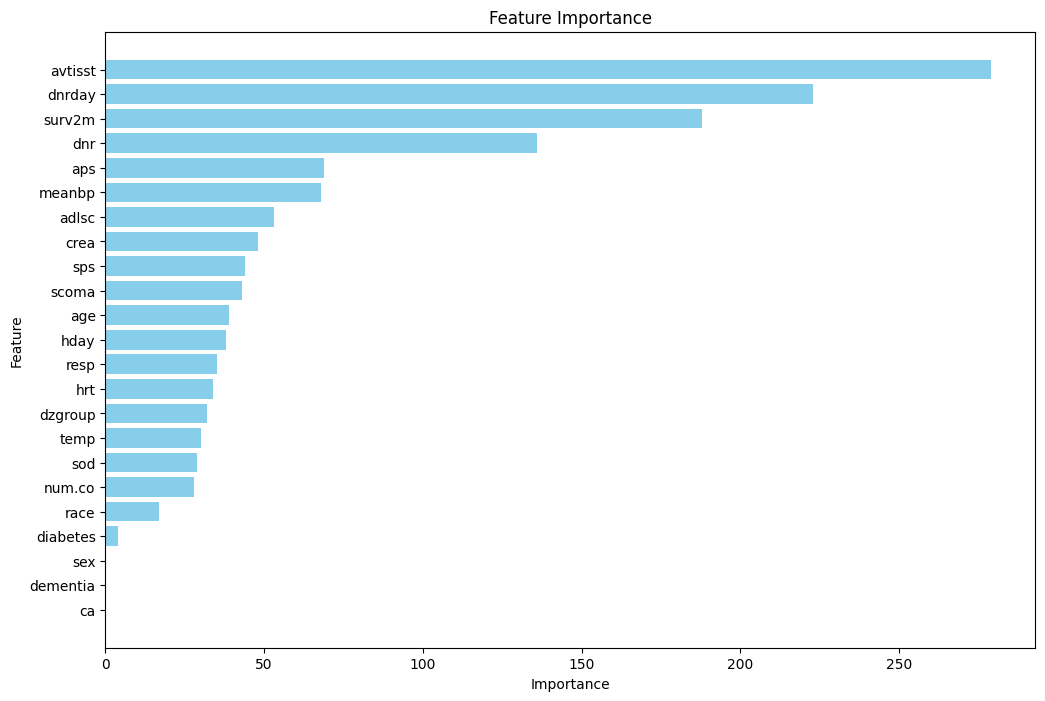


Feature Importances:
    Feature  Importance
5   avtisst         279
15   dnrday         223
9    surv2m         188
14      dnr         136
8       aps          69
16   meanbp          68
22    adlsc          53
20     crea          48
7       sps          44
4     scoma          43


C:\Users\USER}\AppData\Local\Programs\Python\Python311\Lib\site-packages\shap\explainers\_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


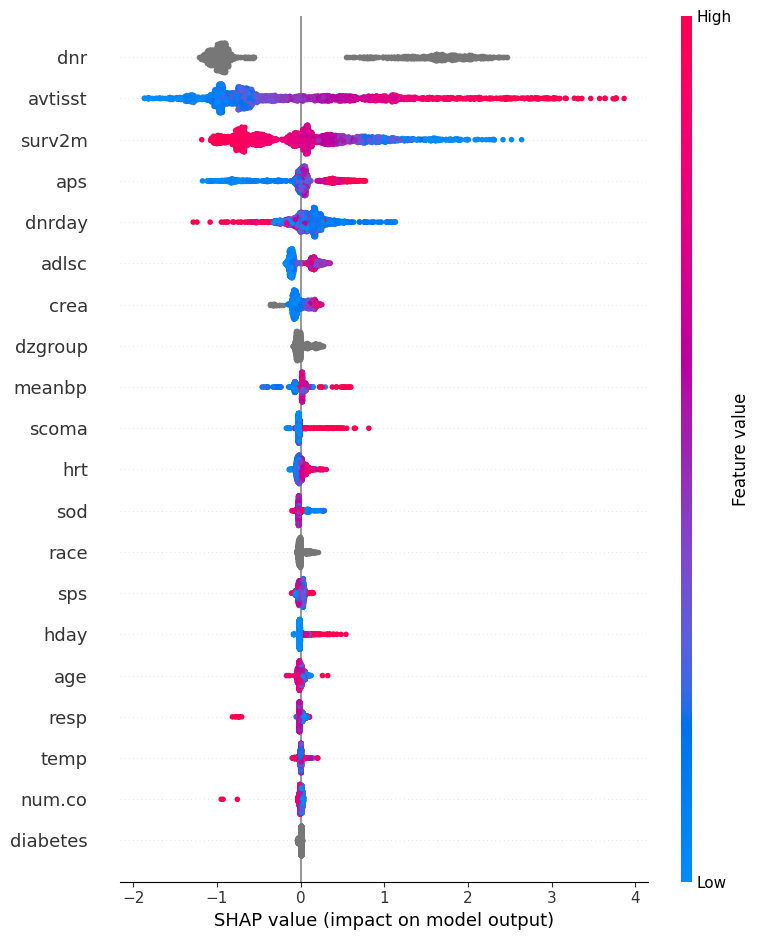

In [62]:
lgb_model = lgb.LGBMClassifier()

param_distributions = {
    'n_estimators': randint(50, 300),
    'learning_rate': uniform(0.01, 0.1),
    'max_depth': randint(3, 10),
    'num_leaves': randint(20, 150),
    'subsample': uniform(0.7, 0.3),
    'colsample_bytree': uniform(0.7, 0.3),
    'reg_alpha': uniform(0, 1),
    'reg_lambda': uniform(0, 1),
}


skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
random_search_lgb = RandomizedSearchCV(
    estimator=lgb_model,
    param_distributions=param_distributions,
    n_iter=20,
    scoring='f1_weighted',
    refit='f1_weighted',
    cv=skf,
    random_state=42,
    n_jobs=-1
)


random_search_lgb.fit(X_train, y_train, **{'categorical_feature': categorical_features})


best_model_lgb = random_search_lgb.best_estimator_


y_pred_lgb = best_model_lgb.predict(X_test)
print(f"\nClassification Report para LightGBM:")
print(classification_report(y_test, y_pred_lgb))

conf_matrix = confusion_matrix(y_test, y_pred_lgb)
plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1], yticklabels=[0, 1])
plt.title("Matriz de Confusión para LightGBM")
plt.ylabel('Verdadero')
plt.xlabel('Predicho')
plt.show()


auc_roc = plot_roc_curve(best_model_lgb, X_test, y_test, label='LightGBM')


auc_pr = plot_precision_recall_curve(best_model_lgb, X_test, y_test, label='LightGBM')


feature_importances = best_model_lgb.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)


plt.figure(figsize=(12, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis() 
plt.show()

print("\nFeature Importances:")
print(feature_importance_df.head(10))

explainer = shap.TreeExplainer(best_model_lgb)

shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, feature_names=X_train.columns)


Los valores obtenidos por esta prueba en cuant a las métricas de clasificación son muy similares a las obtenidas por el mejor modelo de clasificación luego de recorrer el pipeline de preprocesamiento d edatos (y haber lidiado con lso problemas de calidad). Esto nos indica que es muy posible utilziar un modelo robustos en estos problemas de calidad de datos y obtener al mismo tiempo buenso resultados.

---